###  Finding statistically significant features
- Feature selection [Jump](#feature_select)
    - Tsfresh [Jump](#Tsfresh)
    - Talib [Jump](#Talib)
    - Run for all tickers [Jump](#run_all)
    - To use [Jump](#use)
    - Generate final features for all tickers [Jump](#final)

In [2]:
# !pip install tsfresh
# !pip install ta

In [1]:
# import necessary library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.dataframe_functions import impute

import ta
from collections import Counter
import pickle
from collections import defaultdict


# Feature engineering libraries
- tsfresh
  - automatically calculates a large number of time series characteristics, which can then be used to train machine learning models.
- talib

# tsfresh
- a library to automatically extract features from **time series data**. These features are relevant characteristics to improve **machine learning model**
- It does
  - **Feature extraction**: extracts features
    - basic features: mean, median, standard deviation
    - time-based patterns: autocorrelation
    - complex features: Fourier transforms, time-based patterns,
    - extract over 700 features
    -  in stock price prediction, features like **lagged values, rolling means/medians, volatility measures (rolling standard deviation), momentum indicators, and autocorrelation, features that capture ternds/seasonality/cyclical patterns, fourier fetaures** features are often found to be significant
    - (Q) are these included in the extracted features?
      - original price itself (no)
      - lagged price (no)
      - Rolling Means/Medians and Volatility Measures (no, but tsfresh has moving averages and standard deviation)
      -Momentum Indicators (no)
      - Autocorrelation Features (yes)
      - Features Capturing Trends/Seasonality/Cyclical Pattern (yes, e.g. fourier features)

  - **efficient calculation**: process multiple time series efficiently, using parallelization to speed up the computation
  - **relevance testing**: perform hypothesis tests to determine which features are statistically significant and relevant to the target variable you're trying to predict.
  - **Imputation**: handle any missing values that result from the extraction process.

## How to use tsfresh?
- **prepare data**: data in pandas DataFrame. A column for time, columns for time series data, columns for values you want to extract features from
- **Feature Extraction**: Call extract_features() on your DataFrame. You can specify which kinds of features to extract and customize other parameters.
- **Imputation**: Use impute() to handle any NaNs or infinite values in your extracted features.
  - **For finite values**: If a feature has finite values but also contains missing values (NaNs), tsfresh will fill these NaNs with the median of the finite values in that feature.
  - **For features with all missing values**: If a feature consists entirely of NaNs (which might happen if a particular feature couldn't be calculated for your dataset), tsfresh will fill these with zeros.
- **Feature Selection**: you can use select_features() to choose the most relevant features based on the hypothesis tests and a target variable
    - feature selection process in tsfresh uses the Mann-Whitney U test combined with the Benjamini-Yekutieli procedure to control for the false discovery rate (FDR).
  - **Mann-Whitney U test**:
    - non-parametric test used to compare two independent samples
    - e.g. Group A Observations: 3, 6. Group B Observations: 2, 4, 5
    - **ranking**: combine all observations from both groups (3, 6, 2, 4, 5.), rank them in ascending order "2 (rank 1), 3 (rank 2), 4 (rank 3), 5 (rank 4), 6 (rank 5)."
  - H0: no relationship between a feature and target variable (tmr's stock price)
  - 5% significance
    - **U Statistic**:
      - Group A (3, 6) has ranks 2 and 5
      - Group B (2, 4, 5) has ranks 1, 3, 4
      - For group A: Sum of Ranks = 2 + 5 = 7. U-statistics (U1) = 7 - (2 * (2 + 1) / 2) = 7 - 3 = 4
      - For group B: Sum of Ranks = 1 + 3 + 4 = 8. U-stataistics (U2) =  8 - (3 * (3 + 1) / 2) = 8 - 6 = 2
    - **test statistics**: U = min(U1, U2) = min(4, 2) = 2
    - **p-value**:
      - **for small sample size**
        - **Enumerate All Combinations**: List all possible ways the ranks could be divided between the two groups.
        - **Calculate U for Each Combination**: For each combination, calculate the U statistic.
        - **Count Extreme Values**: Count how many times a value as extreme or more extreme than the observed U statistic occurs.
        - **Calculate P-value**: p-value is the proportion of these extreme occurrences out of all possible combinations. If indeed 2 groups are similar, then we would expect very few extreme combinations, hence low p-value
      - **for large sample size (30 data)**
        - u statistics is approximated to a normal distribution. Convert u statistics to a z-score = (U - mean)/ std.
        - mean = (n1 x n2)/2
          - n1, n2 = num of data in group A, group B
        - std = sqrt( [n1 x n2 x (n1+n2+1)] /12)
  - Use **Benjamini-Yekutieli procedure** to adjsut p-values to account for the fact that multiple comparisons (e.g. multiple Mann-Whitney U tests for different features) increase the chance of finding falsely significant results.
    - **Order P-values**:  several tests, each producing a p-value. list these p-values in ascending order.
    - **Adjustment**: calc adjusted p_value for each test, e.g. 3rd smallest p-value in a set of 10 test is 0.04, adjusted p-value = 0.04 x 10/3 * adjustment factor
    - **thresholding**: adjusted p-value below threshold (e.g. 5%) are statistically significant
- **Use Extracted Features**: Use the extracted (and selected) features as input for your machine learning models.

<a id='feature_select'></a>
# Feature selection
# Tsfresh 

In [171]:
candle_data = pd.read_excel('combine_data.xlsx')

In [172]:
candle_data

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,MMM,2019-06-06,137.123749,139.088623,135.836121,137.725754,107.361252,4283833
1,MMM,2019-06-07,138.428101,139.707352,137.658859,139.306015,108.593109,2413169
2,MMM,2019-06-10,140.560196,142.324417,140.359528,140.710709,109.68811,2700090
3,MMM,2019-06-11,142.065216,142.441467,140.886291,141.229095,110.092201,2663731
4,MMM,2019-06-12,142.031769,142.265884,140.961533,141.312714,110.157387,2591014
...,...,...,...,...,...,...,...,...
622923,ZTS,2024-05-28,170.039993,171.710007,169.199997,171.300003,171.300003,2304300
622924,ZTS,2024-05-29,169.479996,173.429993,169.410004,170.800003,170.800003,3071200
622925,ZTS,2024-05-30,170.679993,174.169998,168.309998,169.440002,169.440002,2904700
622926,ZTS,2024-05-31,170.000000,172.149994,167.960007,169.559998,169.559998,4088400


In [38]:
df = candle_data[candle_data['Ticker'] == candle_data['Ticker'].unique()[0]]

In [39]:
df_prepared = df[['Date', 'Close']].copy()
df_prepared['Date'] = pd.to_datetime(df_prepared['Date'])
df_prepared.columns = ['time', 'value']
df_prepared['id'] = 1
df_prepared['id'] = df_prepared['id'].astype(int)
df_prepared['value'] = pd.to_numeric(df_prepared['value'], errors='coerce')
df_prepared.dropna(inplace=True)

In [40]:
df_prepared

,time,value,id
0,2019-06-06,137.725754,1
1,2019-06-07,139.306015,1
2,2019-06-10,140.710709,1
3,2019-06-11,141.229095,1
4,2019-06-12,141.312714,1
...,...,...,...
1252,2024-05-28,98.680000,1
1253,2024-05-29,97.559998,1
1254,2024-05-30,98.199997,1
1255,2024-05-31,100.139999,1


In [41]:
df_forecasting, y = make_forecasting_frame(df_prepared['value'], kind='price', max_timeshift=1, rolling_direction=1)
df_forecasting = df_forecasting.drop(columns=['kind'])
df_forecasting['id'] = df_forecasting['id'].apply(lambda x: x[1])
df_forecasting['id'] = df_forecasting['id'].astype(int)

Rolling: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s]


In [42]:
df_forecasting

,id,time,value
1,1,0,137.725754
3,2,1,139.306015
5,3,2,140.710709
7,4,3,141.229095
9,5,4,141.312714
...,...,...,...
2247,1252,1251,99.669998
2249,1253,1252,98.680000
2251,1254,1253,97.559998
2253,1255,1254,98.199997


In [43]:
default_fc_parameters = ComprehensiveFCParameters()

features = extract_features(
    df_forecasting, 
    column_id='id', 
    column_sort='time', 
    default_fc_parameters=default_fc_parameters,
    show_warnings=False, 
    n_jobs=1
)

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.75it/s]


In [44]:
features

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,0.0,0.0,137.725754,18968.383260,NaN,NaN,NaN,137.725754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,139.306015,19406.165815,NaN,NaN,NaN,139.306015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,140.710709,19799.503515,NaN,NaN,NaN,140.710709,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,141.229095,19945.657416,NaN,NaN,NaN,141.229095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.0,0.0,0.0,141.312714,19969.283025,NaN,NaN,NaN,141.312714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,0.0,0.0,0.0,0.0,99.669998,9934.108535,NaN,NaN,NaN,99.669998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1253,0.0,0.0,0.0,0.0,98.680000,9737.742461,NaN,NaN,NaN,98.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1254,0.0,0.0,0.0,0.0,97.559998,9517.953124,NaN,NaN,NaN,97.559998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1255,0.0,0.0,0.0,0.0,98.199997,9643.239401,NaN,NaN,NaN,98.199997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
len(features.columns)

783

In [46]:
threshold = 0.3
nan_cols = features.columns[features.isnull().mean() > threshold].tolist()
zero_inf_cols = features.columns[(features == 0).any() | (features == np.inf).any() | (features == -np.inf).any()].tolist()
cols_to_drop = list(set(nan_cols + zero_inf_cols))
features = features.drop(columns=cols_to_drop)

In [47]:
y.index = y.index.map(lambda x: x[1])

In [48]:
tsfresh_selected_features = select_features(features, y, fdr_level=0.01)  # Adjust the fdr_level to a stricter value

In [49]:
tsfresh_selected_features['Date'] = df_prepared['time'].iloc[1:].values
columns = ['Date'] + [col for col in tsfresh_selected_features.columns if col != 'Date']
tsfresh_selected_features = tsfresh_selected_features[columns]

In [50]:
tsfresh_selected_features

,Date,value__sum_values,"value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.8,value__quantile__q_0.7,value__quantile__q_0.6,...,value__minimum,value__absolute_maximum,value__maximum,value__root_mean_square,value__mean,value__median,value__abs_energy,value__quantile__q_0.2,"value__fft_coefficient__attr_""abs""__coeff_0",value__benford_correlation
1,2019-06-07,137.725754,26.710503,37.774355,53.421005,84.466026,137.725754,137.725754,137.725754,137.725754,...,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,137.725754,137.725754,0.864123
2,2019-06-10,139.306015,27.016978,38.207777,54.033956,85.435186,139.306015,139.306015,139.306015,139.306015,...,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,139.306015,139.306015,0.864123
3,2019-06-11,140.710709,27.289404,38.593045,54.578808,86.296673,140.710709,140.710709,140.710709,140.710709,...,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,140.710709,140.710709,0.864123
4,2019-06-12,141.229095,27.389940,38.735225,54.779880,86.614595,141.229095,141.229095,141.229095,141.229095,...,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,141.229095,141.229095,0.864123
5,2019-06-13,141.312714,27.406157,38.758159,54.812314,86.665877,141.312714,141.312714,141.312714,141.312714,...,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,141.312714,141.312714,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-05-28,99.669998,19.329978,27.336717,38.659955,61.126757,99.669998,99.669998,99.669998,99.669998,...,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,99.669998,99.669998,-0.297356
1253,2024-05-29,98.680000,19.137978,27.065188,38.275955,60.519599,98.680000,98.680000,98.680000,98.680000,...,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,98.680000,98.680000,-0.297356
1254,2024-05-30,97.559998,18.920765,26.758002,37.841529,59.832711,97.559998,97.559998,97.559998,97.559998,...,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,97.559998,97.559998,-0.297356
1255,2024-05-31,98.199997,19.044886,26.933536,38.089772,60.225217,98.199997,98.199997,98.199997,98.199997,...,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,98.199997,98.199997,-0.297356


In [51]:
tsfresh_selected_features.columns

Index(['Date', 'value__sum_values',
       'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'value__quantile__q_0.9', 'value__quantile__q_0.8',
       'value__quantile__q_0.7', 'value__quantile__q_0.6',
       'value__quantile__q_0.4',
       'value__fft_coefficient__attr_"real"__coeff_0',
       'value__quantile__q_0.3', 'value__quantile__q_0.1', 'value__minimum',
       'value__absolute_maximum', 'value__maximum', 'value__root_mean_square',
       'value__mean', 'value__median', 'value__abs_energy',
       'value__quantile__q_0.2', 'value__fft_coefficient__attr_"abs"__coeff_0',
       'value__benford_correlation'],
      dtype='object')

<a id='Talib'></a>
# Talib

In [30]:
df_prepared = df[['Date', 'Open','High','Low','Close','Volume']].copy()

In [31]:
df_prepared['Date'] = pd.to_datetime(df_prepared['Date'])

In [32]:
talib_selected_features = ta.add_all_ta_features(
    df_prepared, open="Open", high="High", low="Low", close="Close", volume="Volume"
)

In [33]:
talib_selected_features

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,2019-06-06,137.123749,139.088623,135.836121,137.725754,4283833,6.937947e+05,4283833,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169,2.161397e+06,6697002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.147397,1.140864,1.147397
2,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090,4.264708e+05,9397092,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.008351,1.003301,2.167318
3,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731,-1.062939e+06,12060823,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.368406,0.367729,2.543708
4,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014,-2.258755e+06,14651837,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059207,0.059190,2.604422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900,-5.821975e+07,-217813861,-0.086852,1.549035e+05,...,2.203126,2.775043,-0.571917,-8.921753,-6.207467,-2.714286,101.864164,-0.993276,-0.998242,-28.350365
1253,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600,-5.627221e+07,-222640461,-0.137588,-6.394834e+05,...,1.812685,2.582572,-0.769886,-7.424306,-6.450835,-0.973471,101.725526,-1.134985,-1.141475,-29.163577
1254,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300,-5.195436e+07,-218120161,-0.094135,-1.348445e+05,...,1.537250,2.373507,-0.836257,-6.712403,-6.503148,-0.209254,101.571703,0.656006,0.653864,-28.698886
1255,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400,-3.189112e+07,-196365761,0.160897,5.913503e+06,...,1.459459,2.190698,-0.731238,18.112022,-1.580114,19.692136,101.422433,1.975563,1.956302,-27.290288


In [34]:
len(features.columns)-6

777

In [35]:
talib_selected_features.dropna(axis=1, inplace=True) 

In [36]:
talib_selected_features

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,...,volatility_kcli,volatility_atr,trend_ichimoku_b,trend_adx,trend_adx_pos,trend_adx_neg,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,others_cr
0,2019-06-06,137.123749,139.088623,135.836121,137.725754,4283833,6.937947e+05,4283833,1000.000000,0.0,...,0.0,0.000000,137.462372,0.000000,0.000000,0.000000,122.966669,0.0,0.0,0.000000
1,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169,2.161397e+06,6697002,1011.473970,0.0,...,0.0,0.000000,137.771736,0.000000,0.000000,0.000000,122.966669,0.0,0.0,1.147397
2,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090,4.264708e+05,9397092,1011.473970,0.0,...,0.0,0.000000,139.080269,0.000000,0.000000,0.000000,122.966669,1.0,0.0,2.167318
3,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731,-1.062939e+06,12060823,1015.200303,0.0,...,0.0,0.000000,139.138794,0.000000,0.000000,0.000000,122.966669,0.0,0.0,2.543708
4,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014,-2.258755e+06,14651837,1015.801376,0.0,...,0.0,0.000000,139.138794,0.000000,0.000000,0.000000,122.966669,0.0,0.0,2.604422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900,-5.821975e+07,-217813861,1280.743718,0.0,...,1.0,2.019856,95.762474,31.734250,30.414518,28.981822,85.661087,0.0,0.0,-28.350365
1253,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600,-5.627221e+07,-222640461,1280.743718,0.0,...,1.0,2.009870,95.829365,29.763171,28.331435,30.778064,85.661087,0.0,0.0,-29.163577
1254,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300,-5.195436e+07,-218120161,1289.145473,0.0,...,1.0,1.942884,95.829365,27.776699,28.150073,29.271260,85.661087,0.0,0.0,-28.698886
1255,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400,-3.189112e+07,-196365761,1289.145473,0.0,...,0.0,2.031596,95.829365,26.538586,32.481139,26.338527,85.661087,0.0,0.0,-27.290288


In [37]:
talib_selected_features.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_nvi', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kch', 'volatility_kcl', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_atr', 'trend_ichimoku_b', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_visual_ichimoku_b',
       'trend_psar_up_indicator', 'trend_psar_down_indicator', 'others_cr'],
      dtype='object')

# combine features from tsfresh and talib

In [186]:
talib_selected_features['Date']

0      2019-06-06
1      2019-06-07
2      2019-06-10
3      2019-06-11
4      2019-06-12
          ...    
1252   2024-05-28
1253   2024-05-29
1254   2024-05-30
1255   2024-05-31
1256   2024-06-03
Name: Date, Length: 1257, dtype: datetime64[ns]

In [197]:
tsfresh_selected_features['Date']

1      2019-06-07
2      2019-06-10
3      2019-06-11
4      2019-06-12
5      2019-06-13
          ...    
1252   2024-05-28
1253   2024-05-29
1254   2024-05-30
1255   2024-05-31
1256   2024-06-03
Name: Date, Length: 1256, dtype: datetime64[ns]

In [198]:
final_features = pd.merge(tsfresh_selected_features, talib_selected_features, on='Date', suffixes=('_tsfresh', '_talib'))

In [199]:
final_features

,Date,value__sum_values,"value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.8,value__quantile__q_0.7,value__quantile__q_0.6,...,volatility_kcli,volatility_atr,trend_ichimoku_b,trend_adx,trend_adx_pos,trend_adx_neg,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,others_cr
0,2019-06-07,137.725754,26.710503,37.774355,53.421005,84.466026,137.725754,137.725754,137.725754,137.725754,...,0.0,0.000000,137.771736,0.000000,0.000000,0.000000,122.966669,0.0,0.0,1.147397
1,2019-06-10,139.306015,27.016978,38.207777,54.033956,85.435186,139.306015,139.306015,139.306015,139.306015,...,0.0,0.000000,139.080269,0.000000,0.000000,0.000000,122.966669,1.0,0.0,2.167318
2,2019-06-11,140.710709,27.289404,38.593045,54.578808,86.296673,140.710709,140.710709,140.710709,140.710709,...,0.0,0.000000,139.138794,0.000000,0.000000,0.000000,122.966669,0.0,0.0,2.543708
3,2019-06-12,141.229095,27.389940,38.735225,54.779880,86.614595,141.229095,141.229095,141.229095,141.229095,...,0.0,0.000000,139.138794,0.000000,0.000000,0.000000,122.966669,0.0,0.0,2.604422
4,2019-06-13,141.312714,27.406157,38.758159,54.812314,86.665877,141.312714,141.312714,141.312714,141.312714,...,0.0,0.000000,139.138794,0.000000,0.000000,0.000000,122.966669,0.0,0.0,2.507280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2024-05-28,99.669998,19.329978,27.336717,38.659955,61.126757,99.669998,99.669998,99.669998,99.669998,...,1.0,2.019856,95.762474,31.734250,30.414518,28.981822,85.661087,0.0,0.0,-28.350365
1252,2024-05-29,98.680000,19.137978,27.065188,38.275955,60.519599,98.680000,98.680000,98.680000,98.680000,...,1.0,2.009870,95.829365,29.763171,28.331435,30.778064,85.661087,0.0,0.0,-29.163577
1253,2024-05-30,97.559998,18.920765,26.758002,37.841529,59.832711,97.559998,97.559998,97.559998,97.559998,...,1.0,1.942884,95.829365,27.776699,28.150073,29.271260,85.661087,0.0,0.0,-28.698886
1254,2024-05-31,98.199997,19.044886,26.933536,38.089772,60.225217,98.199997,98.199997,98.199997,98.199997,...,0.0,2.031596,95.829365,26.538586,32.481139,26.338527,85.661087,0.0,0.0,-27.290288


In [201]:
columns_except_date = final_features.columns.difference(['Date'])
columns_except_date

Index(['Close', 'High', 'Low', 'Open', 'Volume', 'others_cr', 'trend_adx',
       'trend_adx_neg', 'trend_adx_pos', 'trend_ichimoku_b',
       'trend_psar_down_indicator', 'trend_psar_up_indicator',
       'trend_visual_ichimoku_b', 'value__abs_energy',
       'value__absolute_maximum', 'value__benford_correlation',
       'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'value__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)',
       'value__fft_coefficient__attr_"abs"__coeff_0',
       'value__fft_coefficient__attr_"real"__coeff_0', 'value__maximum',
       'value__mean', 'value__median', 'value__minimum',
       'value__quantile__q_0.1', 'value__quantile__q_0.2',
       'value__quantile__q_0.3', 'value__quantile__q_0.4',
       'value__quantile__q_0.6', 'value__quantile__q_0.7',
       'value__quantile__q_0.8', 'v

<a id='run_all'></a>
# Run for all tickers

In [21]:
def create_statistically_significant_features(i):
    ticker = candle_data['Ticker'].unique()[i]
    print('ticker = ', ticker)
    df = candle_data[candle_data['Ticker'] == ticker]
    
    # tsfresh_selected_features
    
    df_prepared = df[['Date', 'Close']].copy()
    df_prepared['Date'] = pd.to_datetime(df_prepared['Date'])
    df_prepared.columns = ['time', 'value']
    df_prepared['id'] = 1
    df_prepared['id'] = df_prepared['id'].astype(int)
    df_prepared['value'] = pd.to_numeric(df_prepared['value'], errors='coerce')
    df_prepared.dropna(inplace=True)
    
    df_forecasting, y = make_forecasting_frame(df_prepared['value'], kind='price', max_timeshift=1, rolling_direction=1)
    df_forecasting = df_forecasting.drop(columns=['kind'])
    df_forecasting['id'] = df_forecasting['id'].apply(lambda x: x[1])
    df_forecasting['id'] = df_forecasting['id'].astype(int)
    
    default_fc_parameters = ComprehensiveFCParameters()

    features = extract_features(
        df_forecasting, 
        column_id='id', 
        column_sort='time', 
        default_fc_parameters=default_fc_parameters,
        show_warnings=False, 
        n_jobs=1
    )
    
    print('raw len(features.columns) = ', len(features.columns))
    
    threshold = 0.3
    nan_cols = features.columns[features.isnull().mean() > threshold].tolist()
    zero_inf_cols = features.columns[(features == 0).any() | (features == np.inf).any() | (features == -np.inf).any()].tolist()
    cols_to_drop = list(set(nan_cols + zero_inf_cols))
    features = features.drop(columns=cols_to_drop)
    
    y.index = y.index.map(lambda x: x[1])
    tsfresh_selected_features = select_features(features, y, fdr_level=0.01)  # Adjust the fdr_level to a stricter value
    tsfresh_selected_features['Date'] = df_prepared['time'].iloc[1:].values
    columns = ['Date'] + [col for col in tsfresh_selected_features.columns if col != 'Date']
    tsfresh_selected_features = tsfresh_selected_features[columns]
    
    # alib_selected_features
    df_prepared = df[['Date', 'Open','High','Low','Close','Volume']].copy()
    df_prepared['Date'] = pd.to_datetime(df_prepared['Date'])
    talib_selected_features = ta.add_all_ta_features(
        df_prepared, open="Open", high="High", low="Low", close="Close", volume="Volume"
    )
    
    print('raw len(features.columns)-6 = ', len(features.columns)-6)

    talib_selected_features.dropna(axis=1, inplace=True) 
    
    # combine
    final_features = pd.merge(tsfresh_selected_features, talib_selected_features, on='Date', suffixes=('_tsfresh', '_talib'))
    columns_except_date = final_features.columns.difference(['Date'])
    
    print('final_features num = ', len(final_features.columns) -1)
    return final_features, columns_except_date

In [22]:
len(candle_data['Ticker'].unique())

501

In [23]:
candle_data['Ticker'].unique()

array(['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL',
       'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT',
       'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP',
       'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI',
       'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM',
       'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB',
       'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX',
       'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA',
       'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BLDR', 'BG', 'CDNS',
       'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT',
       'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF',
       'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI',
       'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO',
       'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG',
     

In [ ]:
candle_data = pd.read_excel('combine_data.xlsx')

In [24]:
counter = Counter()

for i in range(len(candle_data['Ticker'].unique())):
# for i in range(3):    
    final_features, columns_except_date = create_statistically_significant_features(i)
    counter.update(columns_except_date)
    
    print('i = ', i)
    print('final_features.head() = ', final_features.head())
    print(counter)
    
    with open('counter_data.pkl', 'wb') as f:
        pickle.dump(counter, f)
                    
    print('saved')
    print()
    
# 1min per ticker, 8.2 hr for 500 tickers

ticker =  MMM


Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 32.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  0
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         137.725754   
1 2019-06-10         139.306015   
2 2019-06-11         140.710709   
3 2019-06-12         141.229095   
4 2019-06-13         141.312714   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.710503               
1                                          27.016978               
2                                          27.289404               
3                                          27.389940               
4                                          27.406157               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.774355               
1                                          38.207777               
2                                          38.593045

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.34it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  1
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.240002   
1 2019-06-10          43.830002   
2 2019-06-11          44.380001   
3 2019-06-12          44.590000   
4 2019-06-13          44.919998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.385956               
1                                           8.500381               
2                                           8.607048               
3                                           8.647775               
4                                           8.711775               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.859533               
1                                          12.021354               
2                                          12.172204

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.47it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  2
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          80.089996   
1 2019-06-10          80.739998   
2 2019-06-11          81.269997   
3 2019-06-12          81.120003   
4 2019-06-13          81.949997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.532636               
1                                          15.658698               
2                                          15.761485               
3                                          15.732396               
4                                          15.893365               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.966465               
1                                          22.144742               
2                                          22.290106

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.65it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  3
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          77.070000   
1 2019-06-10          77.430000   
2 2019-06-11          76.949997   
3 2019-06-12          78.169998   
4 2019-06-13          78.570000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.946939               
1                                          15.016757               
2                                          14.923666               
3                                          15.160272               
4                                          15.237849               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.138164               
1                                          21.236902               
2                                          21.105250

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 43.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  4
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         180.399994   
1 2019-06-10         182.919998   
2 2019-06-11         184.440002   
3 2019-06-12         183.369995   
4 2019-06-13         184.589996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          34.986735               
1                                          35.475465               
2                                          35.770254               
3                                          35.562737               
4                                          35.799344               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          49.478716               
1                                          50.169883               
2                                          50.586778

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  5
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         274.799988   
1 2019-06-10         278.160004   
2 2019-06-11         280.339996   
3 2019-06-12         275.989990   
4 2019-06-13         276.839996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          53.294650               
1                                          53.946290               
2                                          54.369078               
3                                          53.525438               
4                                          53.690288               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          75.370016               
1                                          76.291575               
2                                          76.889487

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  6
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              31.82   
1 2019-06-10              32.41   
2 2019-06-11              33.23   
3 2019-06-12              32.41   
4 2019-06-13              32.18   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.171164               
1                                           6.285588               
2                                           6.444619               
3                                           6.285588               
4                                           6.240982               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.727344               
1                                           8.889164               
2                                           9.114067

Feature Extraction: 100%|██████████| 1256/1256 [00:47<00:00, 26.30it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  7
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          16.959999   
1 2019-06-10          16.700001   
2 2019-06-11          16.430000   
3 2019-06-12          16.379999   
4 2019-06-13          16.760000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.289219               
1                                           3.238795               
2                                           3.186431               
3                                           3.176733               
4                                           3.250431               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.651657               
1                                           4.580347               
2                                           4.506293

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 29.91it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  8
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.820000   
1 2019-06-10          54.549999   
2 2019-06-11          54.349998   
3 2019-06-12          54.040001   
4 2019-06-13          54.380001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.437839               
1                                          10.579415               
2                                          10.540627               
3                                          10.480506               
4                                          10.546446               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.761333               
1                                          14.961552               
2                                          14.906697

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  9
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          69.160004   
1 2019-06-10          69.519997   
2 2019-06-11          70.290001   
3 2019-06-12          70.089996   
4 2019-06-13          70.290001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.412876               
1                                          13.482693               
2                                          13.632027               
3                                          13.593239               
4                                          13.632027               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.968671               
1                                          19.067407               
2                                          19.278598

Feature Extraction: 100%|██████████| 1256/1256 [01:03<00:00, 19.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  10
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         221.490005   
1 2019-06-10         223.059998   
2 2019-06-11         221.330002   
3 2019-06-12         219.050003   
4 2019-06-13         219.949997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          42.955723               
1                                          43.260207               
2                                          42.924692               
3                                          42.482510               
4                                          42.657054               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          60.748566               
1                                          61.179172               
2                                          60.70468

Feature Extraction: 100%|██████████| 873/873 [00:44<00:00, 19.52it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  11
final_features.head() =          Date  value__sum_values  \
0 2020-12-11         144.710007   
1 2020-12-14         139.250000   
2 2020-12-15         130.000000   
3 2020-12-16         124.800003   
4 2020-12-17         137.990005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.065027               
1                                          27.006115               
2                                          25.212172               
3                                          24.203685               
4                                          26.761752               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          39.689942               
1                                          38.192414               
2                                          35.65539

Feature Extraction: 100%|██████████| 1256/1256 [00:48<00:00, 26.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  12
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.180000   
1 2019-06-10          79.419998   
2 2019-06-11          79.550003   
3 2019-06-12          79.410004   
4 2019-06-13          79.349998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.162212               
1                                          15.402697               
2                                          15.427910               
3                                          15.400759               
4                                          15.389121               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.442606               
1                                          21.782703               
2                                          21.81836

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.87it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  13
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          68.459999   
1 2019-06-10          69.080002   
2 2019-06-11          70.930000   
3 2019-06-12          73.430000   
4 2019-06-13          72.180000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.277117               
1                                          13.397360               
2                                          13.756149               
3                                          14.240998               
4                                          13.998573               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.776679               
1                                          18.946729               
2                                          19.45413

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  14
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         150.660004   
1 2019-06-10         150.699997   
2 2019-06-11         150.320007   
3 2019-06-12         151.029999   
4 2019-06-13         152.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          29.218968               
1                                          29.226724               
2                                          29.153029               
3                                          29.290725               
4                                          29.478847               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          41.321861               
1                                          41.332830               
2                                          41.22861

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.96it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  15
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         306.359985   
1 2019-06-10         307.660004   
2 2019-06-11         315.029999   
3 2019-06-12         308.880005   
4 2019-06-13         312.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          59.415389               
1                                          59.667514               
2                                          61.096849               
3                                          59.904121               
4                                          60.509212               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          84.026048               
1                                          84.382607               
2                                          86.40399

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  16
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         103.699997   
1 2019-06-10         104.139999   
2 2019-06-11         105.540001   
3 2019-06-12         105.000000   
4 2019-06-13         104.540001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.111555               
1                                          20.196889               
2                                          20.468405               
3                                          20.363677               
4                                          20.274465               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.442033               
1                                          28.562714               
2                                          28.94669

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.94it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  17
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.279999   
1 2019-06-10          49.000000   
2 2019-06-11          48.779999   
3 2019-06-12          48.209999   
4 2019-06-13          49.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.557352               
1                                           9.503049               
2                                           9.460382               
3                                           9.349837               
4                                           9.510807               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.516137               
1                                          13.439341               
2                                          13.37900

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 31.26it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  18
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          99.500000   
1 2019-06-10         100.720001   
2 2019-06-11         100.790001   
3 2019-06-12         100.430000   
4 2019-06-13         100.610001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.297008               
1                                          19.533615               
2                                          19.547191               
3                                          19.477372               
4                                          19.512282               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.290091               
1                                          27.624703               
2                                          27.64390

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.26it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  19
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.388000   
1 2019-06-10          53.418499   
2 2019-06-11          54.138000   
3 2019-06-12          54.051998   
4 2019-06-13          53.955002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.160117               
1                                          10.359972               
2                                          10.499512               
3                                          10.482833               
4                                          10.464021               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.368576               
1                                          14.651213               
2                                          14.84855

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 29.98it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  20
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.216999   
1 2019-06-10          53.301998   
2 2019-06-11          54.019001   
3 2019-06-12          53.936001   
4 2019-06-13          53.851501   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.126953               
1                                          10.337378               
2                                          10.476433               
3                                          10.460336               
4                                          10.443948               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.321675               
1                                          14.619260               
2                                          14.81591

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.70it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  21
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          50.750000   
1 2019-06-10          51.380001   
2 2019-06-11          51.209999   
3 2019-06-12          52.150002   
4 2019-06-13          51.590000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.842444               
1                                           9.964626               
2                                           9.931656               
3                                          10.113960               
4                                          10.005353               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.919318               
1                                          14.092109               
2                                          14.04548

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  22
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.718002   
1 2019-06-10          90.201500   
2 2019-06-11          93.031502   
3 2019-06-12          93.184998   
4 2019-06-13          92.765999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.012010               
1                                          17.493659               
2                                          18.042509               
3                                          18.072278               
4                                          17.991018               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.058616               
1                                          24.739770               
2                                          25.51596

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  23
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              11.15   
1 2019-06-10              11.15   
2 2019-06-11              11.15   
3 2019-06-12              11.18   
4 2019-06-13              11.22   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.162428               
1                                           2.162428               
2                                           2.162428               
3                                           2.168247               
4                                           2.176004               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.058136               
1                                           3.058136               
2                                           3.05813

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.30it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  24
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          76.529999   
1 2019-06-10          75.879997   
2 2019-06-11          75.919998   
3 2019-06-12          74.930000   
4 2019-06-13          76.239998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.842211               
1                                          14.716150               
2                                          14.723908               
3                                          14.531908               
4                                          14.785969               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.990056               
1                                          20.811779               
2                                          20.82275

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.57it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  25
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          30.379999   
1 2019-06-10          30.920000   
2 2019-06-11          30.760000   
3 2019-06-12          30.580000   
4 2019-06-13          31.100000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.891890               
1                                           5.996618               
2                                           5.965588               
3                                           5.930679               
4                                           6.031527               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.332391               
1                                           8.480499               
2                                           8.43661

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  26
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          90.000000   
1 2019-06-10          89.540001   
2 2019-06-11          89.019997   
3 2019-06-12          88.320000   
4 2019-06-13          89.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.454580               
1                                          17.365368               
2                                          17.264519               
3                                          17.128761               
4                                          17.336277               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.684504               
1                                          24.558339               
2                                          24.41571

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  27
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         119.430000   
1 2019-06-10         121.110001   
2 2019-06-11         122.660004   
3 2019-06-12         123.230003   
4 2019-06-13         122.029999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.162228               
1                                          23.488047               
2                                          23.788654               
3                                          23.899200               
4                                          23.666471               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.756337               
1                                          33.217115               
2                                          33.64223

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.17it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  28
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.549999   
1 2019-06-10          52.910000   
2 2019-06-11          53.330002   
3 2019-06-12          53.080002   
4 2019-06-13          52.959999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.385475               
1                                          10.261354               
2                                          10.342809               
3                                          10.294324               
4                                          10.271051               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.687280               
1                                          14.511746               
2                                          14.62694

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  29
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         212.699997   
1 2019-06-10         212.460007   
2 2019-06-11         209.850006   
3 2019-06-12         208.970001   
4 2019-06-13         211.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          41.250991               
1                                          41.204447               
2                                          40.698264               
3                                          40.527596               
4                                          41.018264               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          58.337711               
1                                          58.271888               
2                                          57.55603

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  30
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         117.349998                                    117.349998   
1 2019-06-10         116.290001                                    116.290001   
2 2019-06-11         115.839996                                    115.839996   
3 2019-06-12         115.379997                                    115.379997   
4 2019-06-13         117.089996                                    117.089996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.758833               
1                                          22.553257               
2                                          22.465984               
3                                          22.376771               
4                                          22.70

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  31
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         149.750000   
1 2019-06-10         149.869995   
2 2019-06-11         151.250000   
3 2019-06-12         151.919998   
4 2019-06-13         150.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          29.042482               
1                                          29.065754               
2                                          29.333392               
3                                          29.463331               
4                                          29.166604               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          41.072272               
1                                          41.105184               
2                                          41.48368

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  32
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          83.940002   
1 2019-06-10          85.769997   
2 2019-06-11          86.480003   
3 2019-06-12          86.300003   
4 2019-06-13          85.519997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.279306               
1                                          16.634214               
2                                          16.771913               
3                                          16.737004               
4                                          16.585729               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.022415               
1                                          23.524332               
2                                          23.71906

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.44it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  33
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         174.449997   
1 2019-06-10         175.509995   
2 2019-06-11         175.580002   
3 2019-06-12         174.619995   
4 2019-06-13         175.600006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.832794               
1                                          34.038370               
2                                          34.051947               
3                                          33.865764               
4                                          34.055827               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          47.846797               
1                                          48.137525               
2                                          48.15672

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  34
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          45.965000   
1 2019-06-10          46.595001   
2 2019-06-11          47.075001   
3 2019-06-12          47.770000   
4 2019-06-13          47.730000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.914442               
1                                           9.036624               
2                                           9.129715               
3                                           9.264503               
4                                           9.256746               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.606925               
1                                          12.779717               
2                                          12.91136

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.43it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  35
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          99.970001   
1 2019-06-10         100.690002   
2 2019-06-11         106.550003   
3 2019-06-12         105.169998   
4 2019-06-13         104.370003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.388160               
1                                          19.527797               
2                                          20.664284               
3                                          20.396646               
4                                          20.241496               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.418999               
1                                          27.616475               
2                                          29.22371

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  36
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         189.199997   
1 2019-06-10         193.289993   
2 2019-06-11         195.080002   
3 2019-06-12         194.809998   
4 2019-06-13         197.770004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          36.693406               
1                                          37.486619               
2                                          37.833773               
3                                          37.781408               
4                                          38.355471               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          51.892313               
1                                          53.014085               
2                                          53.50503

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  37
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         187.740005   
1 2019-06-10         190.240005   
2 2019-06-11         190.869995   
3 2019-06-12         189.449997   
4 2019-06-13         189.229996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          36.410256               
1                                          36.895105               
2                                          37.017285               
3                                          36.741891               
4                                          36.699224               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          51.491877               
1                                          52.177558               
2                                          52.35034

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  38
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          28.840000   
1 2019-06-10          28.950001   
2 2019-06-11          28.879999   
3 2019-06-12          28.850000   
4 2019-06-13          28.010000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.593223               
1                                           5.614557               
2                                           5.600981               
3                                           5.595163               
4                                           5.432253               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.910012               
1                                           7.940182               
2                                           7.92098

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.59it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  39
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.305000   
1 2019-06-10          47.537498   
2 2019-06-11          48.145000   
3 2019-06-12          48.702499   
4 2019-06-13          48.547501   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.980382               
1                                           9.219412               
2                                           9.337231               
3                                           9.445352               
4                                           9.415292               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.700178               
1                                          13.038218               
2                                          13.20483

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  40
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          41.380001   
1 2019-06-10          41.509998   
2 2019-06-11          43.139999   
3 2019-06-12          43.750000   
4 2019-06-13          41.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.025228               
1                                           8.050440               
2                                           8.366562               
3                                           8.484865               
4                                           8.048501               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.349387               
1                                          11.385041               
2                                          11.83210

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  41
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          72.919998   
1 2019-06-10          73.400002   
2 2019-06-11          75.709999   
3 2019-06-12          76.139999   
4 2019-06-13          74.889999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.142089               
1                                          14.235180               
2                                          14.683181               
3                                          14.766575               
4                                          14.524150               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.999933               
1                                          20.131585               
2                                          20.76515

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  42
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.580002   
1 2019-06-10          35.639999   
2 2019-06-11          35.419998   
3 2019-06-12          35.000000   
4 2019-06-13          35.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.900378               
1                                           6.912014               
2                                           6.869347               
3                                           6.787892               
4                                           6.795650               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.758608               
1                                           9.775064               
2                                           9.71472

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.45it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  43
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          39.709999   
1 2019-06-10          39.580002   
2 2019-06-11          40.060001   
3 2019-06-12          40.169998   
4 2019-06-13          40.720001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.701349               
1                                           7.676137               
2                                           7.769228               
3                                           7.790561               
4                                           7.897228               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.891352               
1                                          10.855697               
2                                          10.98734

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.23it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  44
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          64.294998   
1 2019-06-10          61.610001   
2 2019-06-11          62.517502   
3 2019-06-12          60.750000   
4 2019-06-13          60.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.469358               
1                                          11.948630               
2                                          12.124631               
3                                          11.781842               
4                                          11.824509               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.634335               
1                                          16.897915               
2                                          17.14681

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.35it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  45
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.309998   
1 2019-06-10          87.790001   
2 2019-06-11          87.820000   
3 2019-06-12          87.449997   
4 2019-06-13          87.709999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.932882               
1                                          17.025974               
2                                          17.031792               
3                                          16.960033               
4                                          17.010458               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.946711               
1                                          24.078363               
2                                          24.08659

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  46
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         104.379997   
1 2019-06-10         104.339996   
2 2019-06-11         103.470001   
3 2019-06-12         104.000000   
4 2019-06-13         103.989998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.243434               
1                                          20.235676               
2                                          20.066949               
3                                          20.169737               
4                                          20.167797               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.628539               
1                                          28.617568               
2                                          28.37895

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.20it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  47
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07          24.244713                                     24.244713   
1 2019-06-10          24.539274                                     24.539274   
2 2019-06-11          24.116314                                     24.116314   
3 2019-06-12          24.252266                                     24.252266   
4 2019-06-13          24.305136                                     24.305136   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.702014               
1                                           4.759141               
2                                           4.677113               
3                                           4.703479               
4                                           4.71

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 36.99it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  48
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         104.220001   
1 2019-06-10         104.209999   
2 2019-06-11         103.120003   
3 2019-06-12         102.620003   
4 2019-06-13         104.330002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.212404               
1                                          20.210464               
2                                          19.999071               
3                                          19.902101               
4                                          20.233738               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.584656               
1                                          28.581913               
2                                          28.28295

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.76it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  49
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         161.160004   
1 2019-06-10         165.300003   
2 2019-06-11         165.119995   
3 2019-06-12         163.199997   
4 2019-06-13         163.770004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.255336               
1                                          32.058247               
2                                          32.023336               
3                                          31.650972               
4                                          31.761519               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.201720               
1                                          45.337207               
2                                          45.28783

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.94it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  50
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         164.300003                                    164.300003   
1 2019-06-10         166.919998                                    166.919998   
2 2019-06-11         167.690002                                    167.690002   
3 2019-06-12         165.110001                                    165.110001   
4 2019-06-13         165.220001                                    165.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.864307               
1                                          32.372428               
2                                          32.521762               
3                                          32.021397               
4                                          32.04

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.81it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  51
final_features.head() =          Date  value__sum_values  \
0 2019-06-07        1090.540039   
1 2019-06-10        1099.140015   
2 2019-06-11        1111.229980   
3 2019-06-12        1095.390015   
4 2019-06-13        1106.770020   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         211.499097               
1                                         213.166975               
2                                         215.511700               
3                                         212.439700               
4                                         214.646736               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         299.104891               
1                                         301.463626               
2                                         304.77956

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  52
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         208.740005                                    208.740005   
1 2019-06-10         209.059998                                    209.059998   
2 2019-06-11         209.360001                                    209.360001   
3 2019-06-12         209.339996                                    209.339996   
4 2019-06-13         207.190002                                    207.190002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          40.482991               
1                                          40.545050               
2                                          40.603233               
3                                          40.599353               
4                                          40.18

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  53
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         110.349998   
1 2019-06-10         112.150002   
2 2019-06-11         112.529999   
3 2019-06-12         112.269997   
4 2019-06-13         111.830002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.401255               
1                                          21.750347               
2                                          21.824043               
3                                          21.773619               
4                                          21.688286               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.265945               
1                                          30.759635               
2                                          30.86385

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.94it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  54
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          67.970001   
1 2019-06-10          69.180000   
2 2019-06-11          71.910004   
3 2019-06-12          70.430000   
4 2019-06-13          70.349998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.182087               
1                                          13.416754               
2                                          13.946210               
3                                          13.659179               
4                                          13.643663               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.642286               
1                                          18.974156               
2                                          19.72292

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 35.96it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  55
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          22.950001   
1 2019-06-10          23.320000   
2 2019-06-11          23.410000   
3 2019-06-12          23.160000   
4 2019-06-13          22.299999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.450918               
1                                           4.522676               
2                                           4.540130               
3                                           4.491645               
4                                           4.324857               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.294549               
1                                           6.396029               
2                                           6.42071

Feature Extraction: 100%|██████████| 1256/1256 [00:33<00:00, 37.11it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  56
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          65.660004   
1 2019-06-10          65.900002   
2 2019-06-11          66.320000   
3 2019-06-12          66.440002   
4 2019-06-13          66.599998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.734087               
1                                          12.780632               
2                                          12.862086               
3                                          12.885360               
4                                          12.916389               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.008718               
1                                          18.074543               
2                                          18.18973

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.23it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  57
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          27.879999   
1 2019-06-10          27.530001   
2 2019-06-11          28.070000   
3 2019-06-12          28.240000   
4 2019-06-13          27.950001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.407041               
1                                           5.339162               
2                                           5.443890               
3                                           5.476859               
4                                           5.420617               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.646711               
1                                           7.550716               
2                                           7.69882

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.05it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  58
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.820000   
1 2019-06-10          44.400002   
2 2019-06-11          44.900002   
3 2019-06-12          44.500000   
4 2019-06-13          44.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.498441               
1                                           8.610927               
2                                           8.707896               
3                                           8.630320               
4                                           8.552744               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.018611               
1                                          12.177689               
2                                          12.31482

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  59
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.358933   
1 2019-06-10          18.350849   
2 2019-06-11          17.639450   
3 2019-06-12          17.930477   
4 2019-06-13          17.655619   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.560527               
1                                           3.558960               
2                                           3.420991               
3                                           3.477433               
4                                           3.424127               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.035346               
1                                           5.033129               
2                                           4.83801

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.22it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  60
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          76.849998   
1 2019-06-10          77.580002   
2 2019-06-11          78.169998   
3 2019-06-12          77.650002   
4 2019-06-13          77.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.904272               
1                                          15.045849               
2                                          15.160272               
3                                          15.059424               
4                                          15.121485               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.077823               
1                                          21.278043               
2                                          21.43986

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  61
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         230.858536                                    230.858536   
1 2019-06-10         232.565857                                    232.565857   
2 2019-06-11         234.351227                                    234.351227   
3 2019-06-12         231.239029                                    231.239029   
4 2019-06-13         231.190247                                    231.190247   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          44.772654               
1                                          45.103772               
2                                          45.450026               
3                                          44.846447               
4                                          44.83

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  62
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          62.299999   
1 2019-06-10          63.720001   
2 2019-06-11          65.190002   
3 2019-06-12          65.519997   
4 2019-06-13          64.449997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.082448               
1                                          12.357843               
2                                          12.642935               
3                                          12.706934               
4                                          12.499418               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.087162               
1                                          17.476629               
2                                          17.87981

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  63
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         287.869995   
1 2019-06-10         289.950012   
2 2019-06-11         291.619995   
3 2019-06-12         296.140015   
4 2019-06-13         297.309998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          55.829444               
1                                          56.232842               
2                                          56.556718               
3                                          57.433330               
4                                          57.660236               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          78.954757               
1                                          79.525248               
2                                          79.98327

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  64
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.202499   
1 2019-06-10          52.487499   
2 2019-06-11          53.029999   
3 2019-06-12          53.165001   
4 2019-06-13          53.857498   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.124141               
1                                          10.179414               
2                                          10.284626               
3                                          10.310809               
4                                          10.445111               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.317698               
1                                          14.395866               
2                                          14.54465

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  65
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         224.350006   
1 2019-06-10         227.229996   
2 2019-06-11         228.399994   
3 2019-06-12         229.080002   
4 2019-06-13         230.429993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          43.510391               
1                                          44.068936               
2                                          44.295845               
3                                          44.427726               
4                                          44.689542               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          61.532985               
1                                          62.322887               
2                                          62.64378

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.35it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  66
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         439.230011   
1 2019-06-10         444.109985   
2 2019-06-11         443.809998   
3 2019-06-12         443.119995   
4 2019-06-13         446.250000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          85.184172               
1                                          86.130594               
2                                          86.072414               
3                                          85.938595               
4                                          86.545628               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         120.468612               
1                                         121.807054               
2                                         121.72477

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  67
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          40.980000   
1 2019-06-10          41.970001   
2 2019-06-11          42.450001   
3 2019-06-12          42.799999   
4 2019-06-13          42.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.947652               
1                                           8.139653               
2                                           8.232744               
3                                           8.300623               
4                                           8.333593               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.239677               
1                                          11.511207               
2                                          11.64285

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  68
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         350.640015   
1 2019-06-10         353.700012   
2 2019-06-11         353.799988   
3 2019-06-12         349.329987   
4 2019-06-13         347.029999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          68.003048               
1                                          68.596503               
2                                          68.615892               
3                                          67.748981               
4                                          67.302922               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          96.170833               
1                                          97.010105               
2                                          97.03752

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  69
final_features.head() =          Date  value__sum_values  \
0 2019-06-07        1754.859985   
1 2019-06-10        1778.290039   
2 2019-06-11        1781.119995   
3 2019-06-12        1803.630005   
4 2019-06-13        1798.900024   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         340.337162               
1                                         344.881182               
2                                         345.430023               
3                                         349.795609               
4                                         348.878278               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         481.309431               
1                                         487.735645               
2                                         488.51182

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  70
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          34.286972   
1 2019-06-10          35.008804   
2 2019-06-11          35.501762   
3 2019-06-12          36.021126   
4 2019-06-13          35.721832   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.649608               
1                                           6.789600               
2                                           6.885204               
3                                           6.985929               
4                                           6.927884               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.403966               
1                                           9.601944               
2                                           9.73714

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.87it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  71
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         135.889999   
1 2019-06-10         136.160004   
2 2019-06-11         134.630005   
3 2019-06-12         133.690002   
4 2019-06-13         134.259995   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.354477               
1                                          26.406841               
2                                          26.110114               
3                                          25.927810               
4                                          26.038354               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.270859               
1                                          37.344913               
2                                          36.92527

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.60it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  72
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          40.540001   
1 2019-06-10          41.279999   
2 2019-06-11          41.450001   
3 2019-06-12          41.169998   
4 2019-06-13          40.799999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.862319               
1                                           8.005834               
2                                           8.038804               
3                                           7.984500               
4                                           7.912743               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.118998               
1                                          11.321959               
2                                          11.36858

Feature Extraction: 100%|██████████| 1256/1256 [00:44<00:00, 28.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  73
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.150002   
1 2019-06-10          46.750000   
2 2019-06-11          46.009998   
3 2019-06-12          46.869999   
4 2019-06-13          47.630001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.950321               
1                                           9.066685               
2                                           8.923169               
3                                           9.089957               
4                                           9.237352               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.657666               
1                                          12.822229               
2                                          12.61926

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 35.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  74
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         272.790008   
1 2019-06-10         274.869995   
2 2019-06-11         280.209992   
3 2019-06-12         283.480011   
4 2019-06-13         279.730011   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          52.904835               
1                                          53.308227               
2                                          54.343865               
3                                          54.978051               
4                                          54.250777               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          74.818735               
1                                          75.389217               
2                                          76.85383

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  75
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         128.320007   
1 2019-06-10         131.020004   
2 2019-06-11         132.139999   
3 2019-06-12         131.050003   
4 2019-06-13         131.460007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.886354               
1                                          25.409991               
2                                          25.627203               
3                                          25.415809               
4                                          25.495325               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          35.194620               
1                                          35.935154               
2                                          36.24233

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  76
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          32.520000   
1 2019-06-10          32.869999   
2 2019-06-11          32.689999   
3 2019-06-12          32.590000   
4 2019-06-13          32.849998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.306922               
1                                           6.374800               
2                                           6.339891               
3                                           6.320498               
4                                           6.370922               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.919334               
1                                           9.015329               
2                                           8.96596

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  77
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              14.69   
1 2019-06-10              14.60   
2 2019-06-11              14.88   
3 2019-06-12              14.75   
4 2019-06-13              14.91   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.848975               
1                                           2.831521               
2                                           2.885824               
3                                           2.860612               
4                                           2.891642               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.029060               
1                                           4.004375               
2                                           4.08117

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  78
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          55.099998   
1 2019-06-10          55.150002   
2 2019-06-11          56.400002   
3 2019-06-12          56.200001   
4 2019-06-13          57.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.686082               
1                                          10.695779               
2                                          10.938204               
3                                          10.899416               
4                                          11.073961               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.112402               
1                                          15.126116               
2                                          15.46895

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  79
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          64.690002   
1 2019-06-10          65.570000   
2 2019-06-11          67.169998   
3 2019-06-12          68.199997   
4 2019-06-13          69.349998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.545965               
1                                          12.716631               
2                                          13.026935               
3                                          13.226693               
4                                          13.449724               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.742674               
1                                          17.984033               
2                                          18.42286

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  80
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.779999   
1 2019-06-10          52.060001   
2 2019-06-11          52.169998   
3 2019-06-12          52.180000   
4 2019-06-13          51.580002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.654322               
1                                          10.096505               
2                                          10.117838               
3                                          10.119778               
4                                          10.003414               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.653273               
1                                          14.278615               
2                                          14.30878

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.19it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  81
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         106.000000   
1 2019-06-10         106.209999   
2 2019-06-11         105.480003   
3 2019-06-12         105.290001   
4 2019-06-13         106.320000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.557617               
1                                          20.598344               
2                                          20.456769               
3                                          20.419920               
4                                          20.619678               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.072861               
1                                          29.130457               
2                                          28.93024

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  82
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.009998   
1 2019-06-10          43.080002   
2 2019-06-11          42.009998   
3 2019-06-12          42.529999   
4 2019-06-13          42.430000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.341350               
1                                           8.354926               
2                                           8.147410               
3                                           8.248259               
4                                           8.228865               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.796450               
1                                          11.815650               
2                                          11.52217

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  83
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          90.360001   
1 2019-06-10          90.260002   
2 2019-06-11          90.430000   
3 2019-06-12          91.339996   
4 2019-06-13          90.550003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.524399               
1                                          17.505005               
2                                          17.537975               
3                                          17.714459               
4                                          17.561248               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.783242               
1                                          24.755816               
2                                          24.80244

Feature Extraction: 100%|██████████| 1256/1256 [00:43<00:00, 28.60it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  84
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          42.790001   
1 2019-06-10          43.849998   
2 2019-06-11          44.000000   
3 2019-06-12          44.639999   
4 2019-06-13          44.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.298683               
1                                           8.504259               
2                                           8.533350               
3                                           8.657472               
4                                           8.576017               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.736111               
1                                          12.026839               
2                                          12.06798

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 31.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  85
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.949997   
1 2019-06-10          79.889999   
2 2019-06-11          82.360001   
3 2019-06-12          81.220001   
4 2019-06-13          82.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.505485               
1                                          15.493849               
2                                          15.972881               
3                                          15.751789               
4                                          15.910820               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.928067               
1                                          21.911611               
2                                          22.58906

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.34it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  86
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.160000   
1 2019-06-10          52.230000   
2 2019-06-11          53.180000   
3 2019-06-12          53.169998   
4 2019-06-13          53.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.921959               
1                                          10.129475               
2                                          10.313718               
3                                          10.311778               
4                                          10.354445               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.031769               
1                                          14.325241               
2                                          14.58579

Feature Extraction: 100%|██████████| 1058/1058 [00:30<00:00, 34.17it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  87
final_features.head() =          Date  value__sum_values  \
0 2020-03-20              12.00   
1 2020-03-23              12.75   
2 2020-03-24              11.54   
3 2020-03-25              11.70   
4 2020-03-26              13.45   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.327277               
1                                           2.472732               
2                                           2.238065               
3                                           2.269095               
4                                           2.608490               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.291267               
1                                           3.496971               
2                                           3.16510

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  88
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          47.610001   
1 2019-06-10          48.160000   
2 2019-06-11          48.810001   
3 2019-06-12          49.689999   
4 2019-06-13          49.520000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.233473               
1                                           9.340140               
2                                           9.466201               
3                                           9.636867               
4                                           9.603898               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.058103               
1                                          13.208952               
2                                          13.38723

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.67it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  89
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         123.389999   
1 2019-06-10         124.459999   
2 2019-06-11         125.739998   
3 2019-06-12         127.279999   
4 2019-06-13         127.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.930230               
1                                          24.137745               
2                                          24.385988               
3                                          24.684655               
4                                          24.649746               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.842455               
1                                          34.135926               
2                                          34.48699

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.66it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  90
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         111.070000   
1 2019-06-10         111.309998   
2 2019-06-11         111.129997   
3 2019-06-12         108.029999   
4 2019-06-13         107.699997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.540891               
1                                          21.587437               
2                                          21.552527               
3                                          20.951314               
4                                          20.887314               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.463421               
1                                          30.529246               
2                                          30.47987

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  91
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.310001   
1 2019-06-10          49.259998   
2 2019-06-11          49.900002   
3 2019-06-12          49.700001   
4 2019-06-13          49.070000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.369231               
1                                           9.553473               
2                                           9.677595               
3                                           9.638807               
4                                           9.516625               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.250094               
1                                          13.510652               
2                                          13.68618

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  92
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         104.220001   
1 2019-06-10         104.860001   
2 2019-06-11         106.379997   
3 2019-06-12         105.849998   
4 2019-06-13         105.370003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.212404               
1                                          20.336526               
2                                          20.631313               
3                                          20.528526               
4                                          20.435435               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.584656               
1                                          28.760190               
2                                          29.17708

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.17it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  93
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         100.389999   
1 2019-06-10         101.120003   
2 2019-06-11         102.599998   
3 2019-06-12         103.610001   
4 2019-06-13         104.190002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.469615               
1                                          19.611191               
2                                          19.898221               
3                                          20.094101               
4                                          20.206586               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.534193               
1                                          27.734413               
2                                          28.14033

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.31it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  94
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          81.750000   
1 2019-06-10          83.480003   
2 2019-06-11          84.769997   
3 2019-06-12          84.720001   
4 2019-06-13          85.379997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.854577               
1                                          16.190094               
2                                          16.440275               
3                                          16.430579               
4                                          16.558578               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.421758               
1                                          22.896250               
2                                          23.25005

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.04it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  95
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.889999   
1 2019-06-10          54.209999   
2 2019-06-11          54.970001   
3 2019-06-12          54.160000   
4 2019-06-13          53.689999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.451415               
1                                          10.513475               
2                                          10.660870               
3                                          10.503779               
4                                          10.412627               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.780532               
1                                          14.868299               
2                                          15.07674

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  96
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          29.150000   
1 2019-06-10          28.820000   
2 2019-06-11          28.920000   
3 2019-06-12          28.639999   
4 2019-06-13          28.980000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.653345               
1                                           5.589344               
2                                           5.608739               
3                                           5.554435               
4                                           5.620375               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.995037               
1                                           7.904527               
2                                           7.93195

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.60it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  97
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.369999   
1 2019-06-10          42.029999   
2 2019-06-11          41.939999   
3 2019-06-12          42.080002   
4 2019-06-13          43.110001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.411168               
1                                           8.151289               
2                                           8.133834               
3                                           8.160986               
4                                           8.360744               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.895188               
1                                          11.527663               
2                                          11.50297

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.76it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  98
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.559998   
1 2019-06-10          79.690002   
2 2019-06-11          80.199997   
3 2019-06-12          80.410004   
4 2019-06-13          82.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.429849               
1                                          15.455062               
2                                          15.553970               
3                                          15.594699               
4                                          15.945729               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.821101               
1                                          21.856758               
2                                          21.99663

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 43.25it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  99
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         127.550003   
1 2019-06-10         128.279999   
2 2019-06-11         130.589996   
3 2019-06-12         131.320007   
4 2019-06-13         132.860001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.737020               
1                                          24.878595               
2                                          25.326595               
3                                          25.468174               
4                                          25.766840               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          34.983429               
1                                          35.183646               
2                                          35.81721

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 44.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  100
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.930000   
1 2019-06-10          43.000000   
2 2019-06-11          43.310001   
3 2019-06-12          42.849998   
4 2019-06-13          42.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.519775               
1                                           8.339411               
2                                           8.399532               
3                                           8.310319               
4                                           8.164865               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.048781               
1                                          11.793708               
2                                          11.8787

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  101
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         387.309998   
1 2019-06-10         394.040008   
2 2019-06-11         395.410004   
3 2019-06-12         391.640015   
4 2019-06-13         391.160004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          75.114816               
1                                          76.420033               
2                                          76.685730               
3                                          75.954579               
4                                          75.861486               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         106.228392               
1                                         108.074247               
2                                         108.4499

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 44.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  102
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         120.680000   
1 2019-06-10         121.480003   
2 2019-06-11         122.290001   
3 2019-06-12         121.169998   
4 2019-06-13         120.190002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.404653               
1                                          23.559805               
2                                          23.716896               
3                                          23.499683               
4                                          23.309623               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.099178               
1                                          33.318596               
2                                          33.5407

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.59it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  103
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         692.179993   
1 2019-06-10         709.869995   
2 2019-06-11         720.520019   
3 2019-06-12         729.239990   
4 2019-06-13         737.739990   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         134.241237               
1                                         137.672032               
2                                         139.737495               
3                                         141.428644               
4                                         143.077133               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         189.845777               
1                                         194.697655               
2                                         197.6186

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.94it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  104
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         148.660004   
1 2019-06-10         149.440002   
2 2019-06-11         148.990005   
3 2019-06-12         148.610001   
4 2019-06-13         148.770004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.831089               
1                                          28.982361               
2                                          28.895089               
3                                          28.821391               
4                                          28.852422               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          40.773317               
1                                          40.987249               
2                                          40.8638

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.22it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  105
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          77.820000   
1 2019-06-10          77.980003   
2 2019-06-11          77.290001   
3 2019-06-12          76.690002   
4 2019-06-13          76.790001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.092394               
1                                          15.123425               
2                                          14.989606               
3                                          14.873242               
4                                          14.892636               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.343868               
1                                          21.387752               
2                                          21.1985

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 43.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  106
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         153.720001   
1 2019-06-10         157.470001   
2 2019-06-11         156.550003   
3 2019-06-12         156.360001   
4 2019-06-13         156.070007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          29.812423               
1                                          30.539698               
2                                          30.361273               
3                                          30.324424               
4                                          30.268183               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.161134               
1                                          43.189655               
2                                          42.9373

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 42.88it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  107
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         101.709999   
1 2019-06-10         102.639999   
2 2019-06-11         102.580002   
3 2019-06-12         102.000000   
4 2019-06-13         102.980003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.725615               
1                                          19.905979               
2                                          19.894343               
3                                          19.781858               
4                                          19.971919               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.896232               
1                                          28.151306               
2                                          28.1348

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.55it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  108
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         231.539993   
1 2019-06-10         232.619995   
2 2019-06-11         234.539993   
3 2019-06-12         232.279999   
4 2019-06-13         234.699997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          44.904816               
1                                          45.114271               
2                                          45.486635               
3                                          45.048332               
4                                          45.517666               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          63.504999               
1                                          63.801214               
2                                          64.3278

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  109
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          55.099998   
1 2019-06-10          55.930000   
2 2019-06-11          56.419998   
3 2019-06-12          57.110001   
4 2019-06-13          55.860001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.686082               
1                                          10.847052               
2                                          10.942082               
3                                          11.075901               
4                                          10.833476               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.112402               
1                                          15.340048               
2                                          15.4744

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.59it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  110
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          66.470001   
1 2019-06-10          65.690002   
2 2019-06-11          67.120003   
3 2019-06-12          67.879997   
4 2019-06-13          66.809998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.891178               
1                                          12.739905               
2                                          13.017239               
3                                          13.164632               
4                                          12.957116               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.230878               
1                                          18.016946               
2                                          18.4091

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  111
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          34.410000   
1 2019-06-10          33.860001   
2 2019-06-11          34.459999   
3 2019-06-12          34.840000   
4 2019-06-13          34.750000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.673468               
1                                           6.566801               
2                                           6.683165               
3                                           6.756862               
4                                           6.739407               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.437709               
1                                           9.286859               
2                                           9.4514

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 46.19it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  112
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         158.960007                                    158.960007   
1 2019-06-10         156.630005                                    156.630005   
2 2019-06-11         156.789993                                    156.789993   
3 2019-06-12         156.130005                                    156.130005   
4 2019-06-13         156.919998                                    156.919998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.828669               
1                                          30.376789               
2                                          30.407817               
3                                          30.279819               
4                                          30.4

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  113
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         200.889999                                    200.889999   
1 2019-06-10         202.110001                                    202.110001   
2 2019-06-11         203.179993                                    203.179993   
3 2019-06-12         198.750000                                    198.750000   
4 2019-06-13         198.880005                                    198.880005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.960563               
1                                          39.197169               
2                                          39.404683               
3                                          38.545532               
4                                          38.5

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  114
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          58.209999   
1 2019-06-10          57.790001   
2 2019-06-11          57.500000   
3 2019-06-12          57.169998   
4 2019-06-13          57.950001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.289235               
1                                          11.207780               
2                                          11.151537               
3                                          11.087537               
4                                          11.238810               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.965389               
1                                          15.850195               
2                                          15.7706

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 44.96it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  115
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.400002   
1 2019-06-10          51.490002   
2 2019-06-11          51.380001   
3 2019-06-12          51.330002   
4 2019-06-13          51.639999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.968505               
1                                           9.985960               
2                                           9.964626               
3                                           9.954929               
4                                          10.015050               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.097595               
1                                          14.122280               
2                                          14.0921

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.65it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  116
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          61.900002   
1 2019-06-10          62.779999   
2 2019-06-11          63.029999   
3 2019-06-12          63.369999   
4 2019-06-13          62.150002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.004873               
1                                          12.175539               
2                                          12.224024               
3                                          12.289964               
4                                          12.053358               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.977454               
1                                          17.218813               
2                                          17.2873

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  117
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          73.110001   
1 2019-06-10          73.989998   
2 2019-06-11          73.029999   
3 2019-06-12          73.330002   
4 2019-06-13          73.050003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.178938               
1                                          14.349604               
2                                          14.163422               
3                                          14.221605               
4                                          14.167302               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.052046               
1                                          20.293405               
2                                          20.0301

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  118
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          41.150002   
1 2019-06-10          41.480000   
2 2019-06-11          41.290001   
3 2019-06-12          41.220001   
4 2019-06-13          41.450001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.980622               
1                                           8.044622               
2                                           8.007774               
3                                           7.994198               
4                                           8.038804               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.286304               
1                                          11.376814               
2                                          11.3247

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.44it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  119
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          71.220001   
1 2019-06-10          70.139999   
2 2019-06-11          70.160004   
3 2019-06-12          71.110001   
4 2019-06-13          69.980003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.812391               
1                                          13.602936               
2                                          13.606816               
3                                          13.791058               
4                                          13.571907               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.533671               
1                                          19.237457               
2                                          19.2429

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  120
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          29.650000   
1 2019-06-10          29.629999   
2 2019-06-11          29.350000   
3 2019-06-12          29.799999   
4 2019-06-13          29.549999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.750314               
1                                           5.746436               
2                                           5.692133               
3                                           5.779405               
4                                           5.730920               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.132173               
1                                           8.126687               
2                                           8.0498

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  121
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          58.200001   
1 2019-06-10          58.959999   
2 2019-06-11          59.259998   
3 2019-06-12          58.730000   
4 2019-06-13          58.549999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.287295               
1                                          11.434689               
2                                          11.492871               
3                                          11.390083               
4                                          11.355174               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.962646               
1                                          16.171093               
2                                          16.2533

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  122
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          89.500000   
1 2019-06-10          88.309998   
2 2019-06-11          87.230003   
3 2019-06-12          86.720001   
4 2019-06-13          87.720001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.357610               
1                                          17.126822               
2                                          16.917368               
3                                          16.818458               
4                                          17.012398               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.547368               
1                                          24.220983               
2                                          23.9247

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.81it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  123
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         184.160004                                    184.160004   
1 2019-06-10         188.399994                                    188.399994   
2 2019-06-11         191.960007                                    191.960007   
3 2019-06-12         194.960007                                    194.960007   
4 2019-06-13         189.320007                                    189.320007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          35.715951               
1                                          36.538254               
2                                          37.228682               
3                                          37.810501               
4                                          36.7

Feature Extraction: 100%|██████████| 595/595 [00:13<00:00, 43.59it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  124
final_features.head() =          Date  value__sum_values  \
0 2022-01-20          42.000000   
1 2022-01-21          45.000000   
2 2022-01-24          45.000000   
3 2022-01-25          42.799999   
4 2022-01-26          41.897999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.145471               
1                                           8.727290               
2                                           8.727290               
3                                           8.300623               
4                                           8.125689               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.519435               
1                                          12.342252               
2                                          12.3422

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  125
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.985001   
1 2019-06-10          80.487503   
2 2019-06-11          80.652496   
3 2019-06-12          81.022499   
4 2019-06-13          82.029999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.512274               
1                                          15.609729               
2                                          15.641728               
3                                          15.713486               
4                                          15.908880               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.937668               
1                                          22.075490               
2                                          22.1207

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.25it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  126
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.434999   
1 2019-06-10          18.662500   
2 2019-06-11          18.709999   
3 2019-06-12          18.422501   
4 2019-06-13          18.697500   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.575280               
1                                           3.619401               
2                                           3.628613               
3                                           3.572856               
4                                           3.626189               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.056209               
1                                           5.118606               
2                                           5.1316

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.53it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  127
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          30.490000   
1 2019-06-10          30.580000   
2 2019-06-11          30.940001   
3 2019-06-12          30.959999   
4 2019-06-13          31.209999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.913224               
1                                           5.930679               
2                                           6.000497               
3                                           6.004375               
4                                           6.052860               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.362561               
1                                           8.387246               
2                                           8.4859

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 42.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  128
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         251.330002   
1 2019-06-10         258.989990   
2 2019-06-11         266.220001   
3 2019-06-12         266.720001   
4 2019-06-13         267.459992   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          48.742886               
1                                          50.228462               
2                                          51.630649               
3                                          51.727619               
4                                          51.871132               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          68.932850               
1                                          71.033772               
2                                          73.0167

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  129
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.900000   
1 2019-06-10          26.309999   
2 2019-06-11          25.309999   
3 2019-06-12          24.950001   
4 2019-06-13          25.070000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.216980               
1                                           5.102556               
2                                           4.908616               
3                                           4.838798               
4                                           4.862070               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.377924               
1                                           7.216103               
2                                           6.9418

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  130
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.995998   
1 2019-06-10          53.987999   
2 2019-06-11          55.049999   
3 2019-06-12          54.478001   
4 2019-06-13          54.789001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.471972               
1                                          10.470421               
2                                          10.676385               
3                                          10.565452               
4                                          10.625767               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.809605               
1                                          14.807411               
2                                          15.0986

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.55it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  131
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         251.210007   
1 2019-06-10         256.010010   
2 2019-06-11         256.850006   
3 2019-06-12         257.109985   
4 2019-06-13         257.230011   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          48.719614               
1                                          49.650525               
2                                          49.813434               
3                                          49.863854               
4                                          49.887132               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          68.899939               
1                                          70.216446               
2                                          70.4468

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  132
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          25.430000   
1 2019-06-10          25.440001   
2 2019-06-11          24.180000   
3 2019-06-12          23.990000   
4 2019-06-13          23.719999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.931889               
1                                           4.933828               
2                                           4.689464               
3                                           4.652615               
4                                           4.600251               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.974744               
1                                           6.977487               
2                                           6.6319

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.07it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  133
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         135.050003   
1 2019-06-10         135.220001   
2 2019-06-11         134.710007   
3 2019-06-12         135.899994   
4 2019-06-13         135.089996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.191568               
1                                          26.224538               
2                                          26.125629               
3                                          26.356415               
4                                          26.199324               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.040471               
1                                          37.087097               
2                                          36.9472

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 44.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  134
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          25.836666   
1 2019-06-10          26.023333   
2 2019-06-11          26.223333   
3 2019-06-12          26.200001   
4 2019-06-13          26.076668   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.010757               
1                                           5.046959               
2                                           5.085748               
3                                           5.081222               
4                                           5.057303               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.086281               
1                                           7.137478               
2                                           7.1923

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  135
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         160.770004   
1 2019-06-10         161.949997   
2 2019-06-11         163.080002   
3 2019-06-12         164.210007   
4 2019-06-13         163.070007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.179700               
1                                          31.408547               
2                                          31.627700               
3                                          31.846853               
4                                          31.625762               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.094754               
1                                          44.418393               
2                                          44.7283

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  136
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          54.110001   
1 2019-06-10          53.919998   
2 2019-06-11          55.029999   
3 2019-06-12          53.970001   
4 2019-06-13          53.660000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.494082               
1                                          10.457233               
2                                          10.672506               
3                                          10.466930               
4                                          10.406809               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.840873               
1                                          14.788760               
2                                          15.0932

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.55it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  137
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         119.609932                                    119.609932   
1 2019-06-10         121.914894                                    121.914894   
2 2019-06-11         122.313828                                    122.313828   
3 2019-06-12         122.260635                                    122.260635   
4 2019-06-13         123.023048                                    123.023048   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.197124               
1                                          23.644148               
2                                          23.721517               
3                                          23.711201               
4                                          23.8

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.45it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  138
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         120.680000   
1 2019-06-10         121.320000   
2 2019-06-11         118.980003   
3 2019-06-12         119.029999   
4 2019-06-13         117.809998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.404653               
1                                          23.528774               
2                                          23.074956               
3                                          23.084652               
4                                          22.848045               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.099178               
1                                          33.274712               
2                                          32.6329

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  139
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.560001   
1 2019-06-10          47.689999   
2 2019-06-11          47.990002   
3 2019-06-12          48.230000   
4 2019-06-13          48.080002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.029836               
1                                           9.248988               
2                                           9.307170               
3                                           9.353716               
4                                           9.324625               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.770117               
1                                          13.080044               
2                                          13.1623

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  140
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.860001   
1 2019-06-10          49.230000   
2 2019-06-11          50.990002   
3 2019-06-12          49.410000   
4 2019-06-13          50.119999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.475898               
1                                           9.547655               
2                                           9.888990               
3                                           9.582565               
4                                           9.720262               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.400943               
1                                          13.502424               
2                                          13.9851

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 43.33it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  141
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         155.630005   
1 2019-06-10         160.330002   
2 2019-06-11         164.089996   
3 2019-06-12         167.720001   
4 2019-06-13         172.300003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.182849               
1                                          31.094366               
2                                          31.823578               
3                                          32.527580               
4                                          33.415825               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.684995               
1                                          43.974073               
2                                          45.0053

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 42.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  142
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         146.490005   
1 2019-06-10         148.710007   
2 2019-06-11         149.809998   
3 2019-06-12         150.000000   
4 2019-06-13         148.789993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.410240               
1                                          28.840786               
2                                          29.054118               
3                                          29.090967               
4                                          28.856299               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          40.178146               
1                                          40.787031               
2                                          41.0887

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 42.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  143
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          54.689999   
1 2019-06-10          55.070000   
2 2019-06-11          54.730000   
3 2019-06-12          54.880001   
4 2019-06-13          55.450001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.606566               
1                                          10.680264               
2                                          10.614324               
3                                          10.643415               
4                                          10.753961               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.999950               
1                                          15.104174               
2                                          15.0109

Feature Extraction: 100%|██████████| 1256/1256 [00:28<00:00, 44.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  144
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          25.629999   
1 2019-06-10          25.690001   
2 2019-06-11          26.120001   
3 2019-06-12          26.100000   
4 2019-06-13          25.480000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.970676               
1                                           4.982313               
2                                           5.065707               
3                                           5.061828               
4                                           4.941586               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.029598               
1                                           7.046055               
2                                           7.1639

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 44.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  145
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          30.174999   
1 2019-06-10          31.495001   
2 2019-06-11          34.610001   
3 2019-06-12          34.632500   
4 2019-06-13          36.317501   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.852133               
1                                           6.108134               
2                                           6.712256               
3                                           6.716619               
4                                           7.043408               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.276166               
1                                           8.638205               
2                                           9.4925

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.88it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  146
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          97.580002   
1 2019-06-10          97.019997   
2 2019-06-11          97.599998   
3 2019-06-12          99.760002   
4 2019-06-13          98.209999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.924644               
1                                          18.816037               
2                                          18.928522               
3                                          19.347433               
4                                          19.046826               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.763489               
1                                          26.609895               
2                                          26.7689

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 45.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  147
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         115.500000   
1 2019-06-10         116.000000   
2 2019-06-11         116.830002   
3 2019-06-12         119.220001   
4 2019-06-13         119.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.400045               
1                                          22.497015               
2                                          22.657985               
3                                          23.121501               
4                                          23.154470               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          31.678447               
1                                          31.815583               
2                                          32.0432

Feature Extraction: 100%|██████████| 1256/1256 [00:27<00:00, 46.20it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  148
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.099998   
1 2019-06-10          78.139999   
2 2019-06-11          78.190002   
3 2019-06-12          78.760002   
4 2019-06-13          77.440002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.146697               
1                                          15.154454               
2                                          15.164152               
3                                          15.274698               
4                                          15.018697               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.420664               
1                                          21.431635               
2                                          21.4453

Feature Extraction: 100%|██████████| 1256/1256 [00:29<00:00, 41.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  149
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         131.460007                                    131.460007   
1 2019-06-10         133.149994                                    133.149994   
2 2019-06-11         134.970001                                    134.970001   
3 2019-06-12         135.509995                                    135.509995   
4 2019-06-13         136.039993                                    136.039993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.495325               
1                                          25.823081               
2                                          26.176053               
3                                          26.280779               
4                                          26.3

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  150
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         102.220001   
1 2019-06-10         102.639999   
2 2019-06-11         103.779999   
3 2019-06-12         106.529999   
4 2019-06-13         108.050003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.824525               
1                                          19.905979               
2                                          20.127070               
3                                          20.660405               
4                                          20.955194               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.036112               
1                                          28.151306               
2                                          28.4639

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  151
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          76.349998   
1 2019-06-10          75.790001   
2 2019-06-11          75.419998   
3 2019-06-12          73.910004   
4 2019-06-13          75.080002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.807302               
1                                          14.698696               
2                                          14.626938               
3                                          14.334090               
4                                          14.560999               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.940687               
1                                          20.787096               
2                                          20.6856

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  152
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         287.000000   
1 2019-06-10         287.000000   
2 2019-06-11         282.640015   
3 2019-06-12         280.130005   
4 2019-06-13         282.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          55.660717               
1                                          55.660717               
2                                          54.815143               
3                                          54.328352               
4                                          54.691018               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          78.716141               
1                                          78.716141               
2                                          77.5203

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  153
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          94.709999   
1 2019-06-10          96.050003   
2 2019-06-11          96.589996   
3 2019-06-12          96.370003   
4 2019-06-13          96.540001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.368037               
1                                          18.627917               
2                                          18.732643               
3                                          18.689977               
4                                          18.722947               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          25.976326               
1                                          26.343852               
2                                          26.4919

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  154
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.060001   
1 2019-06-10          51.299999   
2 2019-06-11          51.619999   
3 2019-06-12          52.040001   
4 2019-06-13          52.490002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.902566               
1                                           9.949111               
2                                          10.011171               
3                                          10.092626               
4                                          10.179899               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.004342               
1                                          14.070167               
2                                          14.1579

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  155
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          45.169998   
1 2019-06-10          45.599998   
2 2019-06-11          45.490002   
3 2019-06-12          44.869999   
4 2019-06-13          45.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.760260               
1                                           8.843654               
2                                           8.822321               
3                                           8.702078               
4                                           8.735048               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.388878               
1                                          12.506815               
2                                          12.4766

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  156
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         110.272339   
1 2019-06-10         109.429787   
2 2019-06-11         109.131912   
3 2019-06-12         108.612763   
4 2019-06-13         109.914894   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.386193               
1                                          21.222789               
2                                          21.165019               
3                                          21.064335               
4                                          21.316871               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.244645               
1                                          30.013556               
2                                          29.9318

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.13it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  157
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.709999   
1 2019-06-10          87.040001   
2 2019-06-11          86.290001   
3 2019-06-12          85.639999   
4 2019-06-13          86.650002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.010458               
1                                          16.880519               
2                                          16.735064               
3                                          16.609003               
4                                          16.804882               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.056421               
1                                          23.872659               
2                                          23.6669

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  158
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          72.660004   
1 2019-06-10          73.639999   
2 2019-06-11          73.750000   
3 2019-06-12          73.730003   
4 2019-06-13          73.459999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.091665               
1                                          14.281725               
2                                          14.303059               
3                                          14.299181               
4                                          14.246816               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.928624               
1                                          20.197410               
2                                          20.2275

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 21.05it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  159
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          71.699997   
1 2019-06-10          71.330002   
2 2019-06-11          72.169998   
3 2019-06-12          72.730003   
4 2019-06-13          72.639999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.905482               
1                                          13.833725               
2                                          13.996634               
3                                          14.105241               
4                                          14.087786               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.665321               
1                                          19.563841               
2                                          19.7942

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 20.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  160
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.300003   
1 2019-06-10          79.080002   
2 2019-06-11          79.320000   
3 2019-06-12          79.209999   
4 2019-06-13          78.669998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.185485               
1                                          15.336758               
2                                          15.383303               
3                                          15.361970               
4                                          15.257242               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.475520               
1                                          21.689452               
2                                          21.7552

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  161
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          36.810001   
1 2019-06-10          37.509998   
2 2019-06-11          38.119999   
3 2019-06-12          38.230000   
4 2019-06-13          39.020000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.138924               
1                                           7.274681               
2                                           7.392984               
3                                           7.414318               
4                                           7.567530               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.095963               
1                                          10.287952               
2                                          10.4552

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.76it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  162
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         196.770004                                    196.770004   
1 2019-06-10         198.750000                                    198.750000   
2 2019-06-11         199.690002                                    199.690002   
3 2019-06-12         197.639999                                    197.639999   
4 2019-06-13         199.119995                                    199.119995   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.161532               
1                                          38.545532               
2                                          38.727835               
3                                          38.330258               
4                                          38.6

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  163
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          63.480000   
1 2019-06-10          62.639999   
2 2019-06-11          60.869999   
3 2019-06-12          60.200001   
4 2019-06-13          59.520000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.311297               
1                                          12.148388               
2                                          11.805114               
3                                          11.675175               
4                                          11.543296               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.410804               
1                                          17.180415               
2                                          16.6949

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  164
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          59.930000   
1 2019-06-10          61.270000   
2 2019-06-11          61.743332   
3 2019-06-12          61.866669   
4 2019-06-13          61.599998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.622811               
1                                          11.882691               
2                                          11.974488               
3                                          11.998408               
4                                          11.946690               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.437137               
1                                          16.804662               
2                                          16.9344

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.76it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  165
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          96.389999   
1 2019-06-10          96.989998   
2 2019-06-11          95.510002   
3 2019-06-12          94.580002   
4 2019-06-13          92.669998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.693855               
1                                          18.810219               
2                                          18.523189               
3                                          18.342825               
4                                          17.972399               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.437104               
1                                          26.601667               
2                                          26.1957

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  166
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         277.500000   
1 2019-06-10         278.130005   
2 2019-06-11         282.140015   
3 2019-06-12         283.450012   
4 2019-06-13         281.100006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          53.818289               
1                                          53.940472               
2                                          54.718173               
3                                          54.972233               
4                                          54.516474               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          76.110555               
1                                          76.283348               
2                                          77.3831

Feature Extraction: 100%|██████████| 1256/1256 [01:00<00:00, 20.81it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  167
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         117.500000   
1 2019-06-10         118.349998   
2 2019-06-11         113.930000   
3 2019-06-12         112.209999   
4 2019-06-13         115.239998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.787924               
1                                          22.952773               
2                                          22.095559               
3                                          21.761983               
4                                          22.349620               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.226992               
1                                          32.460123               
2                                          31.2478

Feature Extraction: 100%|██████████| 1256/1256 [00:59<00:00, 20.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  168
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          62.650002   
1 2019-06-10          63.680000   
2 2019-06-11          64.629997   
3 2019-06-12          63.459999   
4 2019-06-13          62.740002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.150328               
1                                          12.350085               
2                                          12.534328               
3                                          12.307418               
4                                          12.167782               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.183158               
1                                          17.465658               
2                                          17.7262

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  169
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          15.680000   
1 2019-06-10          16.360001   
2 2019-06-11          16.190001   
3 2019-06-12          17.070000   
4 2019-06-13          17.080000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.040976               
1                                           3.172855               
2                                           3.139885               
3                                           3.310552               
4                                           3.312491               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.300589               
1                                           4.487094               
2                                           4.4404

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 31.21it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  170
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         100.980003   
1 2019-06-10         100.599998   
2 2019-06-11          99.849998   
3 2019-06-12          99.500000   
4 2019-06-13         101.309998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.584040               
1                                          19.510342               
2                                          19.364887               
3                                          19.297008               
4                                          19.648039               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.696015               
1                                          27.591790               
2                                          27.3860

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  171
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          84.269997   
1 2019-06-10          84.599998   
2 2019-06-11          85.199997   
3 2019-06-12          86.500000   
4 2019-06-13          85.029999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.343305               
1                                          16.407305               
2                                          16.523669               
3                                          16.775791               
4                                          16.490699               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.112923               
1                                          23.203434               
2                                          23.3679

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  172
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         172.820007   
1 2019-06-10         176.750000   
2 2019-06-11         177.110001   
3 2019-06-12         177.449997   
4 2019-06-13         177.889999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.516674               
1                                          34.278856               
2                                          34.348675               
3                                          34.414614               
4                                          34.499948               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          47.399736               
1                                          48.477624               
2                                          48.5763

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  173
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.059999   
1 2019-06-10          17.690001   
2 2019-06-11          17.309999   
3 2019-06-12          16.660000   
4 2019-06-13          15.770000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.502552               
1                                           3.430795               
2                                           3.357098               
3                                           3.231037               
4                                           3.058430               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.953357               
1                                           4.851877               
2                                           4.7476

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 31.04it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  174
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         129.100006                                    129.100006   
1 2019-06-10         130.169998                                    130.169998   
2 2019-06-11         130.210007                                    130.210007   
3 2019-06-12         128.649994                                    128.649994   
4 2019-06-13         130.990005                                    130.990005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.037627               
1                                          25.245141               
2                                          25.252900               
3                                          24.950352               
4                                          25.4

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  175
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         494.660004   
1 2019-06-10         499.600006   
2 2019-06-11         506.019989   
3 2019-06-12         504.239990   
4 2019-06-13         503.670013   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          95.934253               
1                                          96.892316               
2                                          98.137406               
3                                          97.792194               
4                                          97.681652               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         135.671522               
1                                         137.026428               
2                                         138.7872

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 33.97it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  176
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          77.790001   
1 2019-06-10          77.980003   
2 2019-06-11          77.830002   
3 2019-06-12          77.800003   
4 2019-06-13          77.650002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.086576               
1                                          15.123425               
2                                          15.094334               
3                                          15.088516               
4                                          15.059424               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.335640               
1                                          21.387752               
2                                          21.3466

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  177
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         296.500000   
1 2019-06-10         296.670013   
2 2019-06-11         296.010010   
3 2019-06-12         299.019989   
4 2019-06-13         298.829987   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          57.503145               
1                                          57.536118               
2                                          57.408117               
3                                          57.991871               
4                                          57.955022               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          81.321728               
1                                          81.368358               
2                                          81.1873

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.16it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  178
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         173.929993   
1 2019-06-10         176.860001   
2 2019-06-11         178.020004   
3 2019-06-12         177.490005   
4 2019-06-13         177.169998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.731945               
1                                          34.300190               
2                                          34.525161               
3                                          34.422373               
4                                          34.360311               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          47.704174               
1                                          48.507794               
2                                          48.8259

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  179
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          61.959999   
1 2019-06-10          63.889999   
2 2019-06-11          65.309998   
3 2019-06-12          67.180000   
4 2019-06-13          69.169998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.016509               
1                                          12.390813               
2                                          12.666207               
3                                          13.028875               
4                                          13.414814               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.993910               
1                                          17.523255               
2                                          17.9127

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  180
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         252.910004   
1 2019-06-10         252.649994   
2 2019-06-11         252.169998   
3 2019-06-12         249.050003   
4 2019-06-13         250.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          49.049311               
1                                          48.998885               
2                                          48.905794               
3                                          48.300703               
4                                          48.539248               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          69.366201               
1                                          69.294887               
2                                          69.1632

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.11it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  181
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          60.509998   
1 2019-06-10          60.480000   
2 2019-06-11          59.840000   
3 2019-06-12          59.290001   
4 2019-06-13          60.380001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.735296               
1                                          11.729478               
2                                          11.605357               
3                                          11.498690               
4                                          11.710084               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.596215               
1                                          16.587987               
2                                          16.4124

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  182
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          76.849998   
1 2019-06-10          76.300003   
2 2019-06-11          76.019997   
3 2019-06-12          75.480003   
4 2019-06-13          76.510002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.904272               
1                                          14.797606               
2                                          14.743302               
3                                          14.638575               
4                                          14.838333               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.077823               
1                                          20.926975               
2                                          20.8501

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  183
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.827389   
1 2019-06-10          35.627674   
2 2019-06-11          35.356632   
3 2019-06-12          35.099857   
4 2019-06-13          35.984306   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.948356               
1                                           6.909623               
2                                           6.857058               
3                                           6.807259               
4                                           6.978789               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.826459               
1                                           9.771683               
2                                           9.6973

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.98it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  184
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         120.519997   
1 2019-06-10         122.599998   
2 2019-06-11         121.750000   
3 2019-06-12         123.059998   
4 2019-06-13         124.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.373622               
1                                          23.777017               
2                                          23.612168               
3                                          23.866229               
4                                          24.091200               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.055293               
1                                          33.625780               
2                                          33.3926

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  185
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          71.750000   
1 2019-06-10          72.559998   
2 2019-06-11          73.699997   
3 2019-06-12          73.019997   
4 2019-06-13          74.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.915179               
1                                          14.072270               
2                                          14.293361               
3                                          14.161482               
4                                          14.405847               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.679035               
1                                          19.901195               
2                                          20.2138

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  186
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         108.910004   
1 2019-06-10         109.480003   
2 2019-06-11         109.120003   
3 2019-06-12         109.110001   
4 2019-06-13         108.830002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.121982               
1                                          21.232528               
2                                          21.162709               
3                                          21.160770               
4                                          21.106467               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.870994               
1                                          30.027329               
2                                          29.9285

Feature Extraction: 100%|██████████| 1256/1256 [00:43<00:00, 29.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  187
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          74.309998   
1 2019-06-10          74.580002   
2 2019-06-11          74.910004   
3 2019-06-12          74.839996   
4 2019-06-13          74.029999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.411665               
1                                          14.464029               
2                                          14.528030               
3                                          14.514453               
4                                          14.357362               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.381172               
1                                          20.455226               
2                                          20.5457

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.42it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  188
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         138.630005   
1 2019-06-10         140.429993   
2 2019-06-11         142.610001   
3 2019-06-12         141.970001   
4 2019-06-13         142.740005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.885873               
1                                          27.234962               
2                                          27.657752               
3                                          27.533631               
4                                          27.682965               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          38.022366               
1                                          38.516053               
2                                          39.1139

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.29it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  189
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         289.709992   
1 2019-06-10         292.160004   
2 2019-06-11         297.079987   
3 2019-06-12         295.000000   
4 2019-06-13         301.489990   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          56.186292               
1                                          56.661447               
2                                          57.615628               
3                                          57.212236               
4                                          58.470903               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          79.459417               
1                                          80.131387               
2                                          81.4808

Feature Extraction: 100%|██████████| 1256/1256 [00:43<00:00, 28.65it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  190
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         312.170013   
1 2019-06-10         313.149994   
2 2019-06-11         315.239990   
3 2019-06-12         309.910004   
4 2019-06-13         311.480011   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          60.542184               
1                                          60.732241               
2                                          61.137575               
3                                          60.103878               
4                                          60.408365               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          85.619578               
1                                          85.888360               
2                                          86.4615

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.68it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  191
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.959999   
1 2019-06-10          32.259998   
2 2019-06-11          32.639999   
3 2019-06-12          32.349998   
4 2019-06-13          32.270000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.198315               
1                                           6.256497               
2                                           6.330194               
3                                           6.273952               
4                                           6.258437               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.765741               
1                                           8.848023               
2                                           8.9522

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  192
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         132.220001   
1 2019-06-10         131.899994   
2 2019-06-11         131.139999   
3 2019-06-12         130.820007   
4 2019-06-13         131.289993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.642718               
1                                          25.580656               
2                                          25.433263               
3                                          25.371204               
4                                          25.462353               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          36.264280               
1                                          36.176511               
2                                          35.9680

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  193
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         156.850006   
1 2019-06-10         158.020004   
2 2019-06-11         161.839996   
3 2019-06-12         159.440002   
4 2019-06-13         161.369995   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.419456               
1                                          30.646365               
2                                          31.387214               
3                                          30.921759               
4                                          31.296062               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          43.019607               
1                                          43.340505               
2                                          44.3882

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  194
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         121.570000   
1 2019-06-10         122.540001   
2 2019-06-11         122.290001   
3 2019-06-12         121.690002   
4 2019-06-13         120.949997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.577259               
1                                          23.765381               
2                                          23.716896               
3                                          23.600532               
4                                          23.457016               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.343280               
1                                          33.609324               
2                                          33.5407

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.35it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  195
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          27.090000   
1 2019-06-10          26.830000   
2 2019-06-11          27.020000   
3 2019-06-12          27.410000   
4 2019-06-13          27.110001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.253829               
1                                           5.203404               
2                                           5.240253               
3                                           5.315889               
4                                           5.257708               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.430036               
1                                           7.358725               
2                                           7.4108

Feature Extraction: 100%|██████████| 1256/1256 [00:40<00:00, 30.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  196
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          61.419998   
1 2019-06-10          62.529999   
2 2019-06-11          63.160000   
3 2019-06-12          64.250000   
4 2019-06-13          59.880001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.911781               
1                                          12.127054               
2                                          12.249237               
3                                          12.460631               
4                                          11.613114               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.845802               
1                                          17.150245               
2                                          17.3230

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 31.49it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  197
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          43.389999   
1 2019-06-10          43.040001   
2 2019-06-11          43.020000   
3 2019-06-12          42.750000   
4 2019-06-13          43.369999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.415047               
1                                           8.347168               
2                                           8.343289               
3                                           8.290926               
4                                           8.411168               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.900674               
1                                          11.804679               
2                                          11.7991

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  198
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          89.410004   
1 2019-06-10          89.739998   
2 2019-06-11          90.580002   
3 2019-06-12          89.639999   
4 2019-06-13          89.769997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.340157               
1                                          17.404156               
2                                          17.567066               
3                                          17.384762               
4                                          17.409974               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.522685               
1                                          24.613193               
2                                          24.8435

Feature Extraction: 100%|██████████| 1256/1256 [00:47<00:00, 26.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  199
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.500000   
1 2019-06-10          80.720001   
2 2019-06-11          79.930000   
3 2019-06-12          79.690002   
4 2019-06-13          79.910004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.418213               
1                                          15.654819               
2                                          15.501607               
3                                          15.455062               
4                                          15.497729               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.804645               
1                                          22.139258               
2                                          21.9225

Feature Extraction: 100%|██████████| 1256/1256 [00:48<00:00, 25.72it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  200
final_features.head() =          Date  value__sum_values  \
0 2019-06-07               9.75   
1 2019-06-10               9.76   
2 2019-06-11               9.82   
3 2019-06-12               9.92   
4 2019-06-13               9.85   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           1.890913               
1                                           1.892852               
2                                           1.904489               
3                                           1.923883               
4                                           1.910307               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           2.674155               
1                                           2.676897               
2                                           2.6933

Feature Extraction: 100%|██████████| 1256/1256 [00:47<00:00, 26.43it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  201
final_features.head() =          Date  value__sum_values  \
0 2019-06-07             14.718   
1 2019-06-10             14.764   
2 2019-06-11             14.936   
3 2019-06-12             15.196   
4 2019-06-13             15.398   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.854406               
1                                           2.863327               
2                                           2.896685               
3                                           2.947109               
4                                           2.986285               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.036739               
1                                           4.049356               
2                                           4.0965

Feature Extraction: 100%|██████████| 1256/1256 [00:43<00:00, 28.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  202
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          66.426781   
1 2019-06-10          66.083679   
2 2019-06-11          66.041840   
3 2019-06-12          66.242676   
4 2019-06-13          65.422592   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.882795               
1                                          12.816254               
2                                          12.808140               
3                                          12.847090               
4                                          12.688043               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.219024               
1                                          18.124921               
2                                          18.1134

Feature Extraction: 100%|██████████| 1256/1256 [00:42<00:00, 29.25it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  203
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          34.119999   
1 2019-06-10          34.009998   
2 2019-06-11          34.029999   
3 2019-06-12          34.180000   
4 2019-06-13          35.049999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.617225               
1                                           6.595892               
2                                           6.599771               
3                                           6.628862               
4                                           6.797589               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.358170               
1                                           9.327999               
2                                           9.3334

Feature Extraction: 100%|██████████| 1256/1256 [00:43<00:00, 29.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  204
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          33.740002   
1 2019-06-10          33.680000   
2 2019-06-11          33.740002   
3 2019-06-12          33.830002   
4 2019-06-13          34.700001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.543529               
1                                           6.531892               
2                                           6.543529               
3                                           6.560983               
4                                           6.729711               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.253947               
1                                           9.237490               
2                                           9.2539

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.33it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  205
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          33.169998   
1 2019-06-10          33.639999   
2 2019-06-11          33.400002   
3 2019-06-12          33.369999   
4 2019-06-13          33.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.432982               
1                                           6.524134               
2                                           6.477589               
3                                           6.471770               
4                                           6.454316               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.097611               
1                                           9.226519               
2                                           9.1606

Feature Extraction: 100%|██████████| 1256/1256 [00:41<00:00, 30.59it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  206
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              10.19   
1 2019-06-10              10.35   
2 2019-06-11              10.61   
3 2019-06-12              10.62   
4 2019-06-13              10.59   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           1.976246               
1                                           2.007277               
2                                           2.057701               
3                                           2.059640               
4                                           2.053822               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           2.794834               
1                                           2.838718               
2                                           2.9100

Feature Extraction: 100%|██████████| 1256/1256 [00:38<00:00, 32.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  207
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.370003   
1 2019-06-10          78.949997   
2 2019-06-11          80.169998   
3 2019-06-12          80.209999   
4 2019-06-13          80.680000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.199061               
1                                          15.311545               
2                                          15.548152               
3                                          15.555910               
4                                          15.647062               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.494719               
1                                          21.653795               
2                                          21.9884

Feature Extraction: 100%|██████████| 1256/1256 [00:32<00:00, 39.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  208
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         154.210007   
1 2019-06-10         157.479996   
2 2019-06-11         159.020004   
3 2019-06-12         157.110001   
4 2019-06-13         157.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          29.907455               
1                                          30.541636               
2                                          30.840305               
3                                          30.469879               
4                                          30.502849               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.295529               
1                                          43.192396               
2                                          43.6147

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.31it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  209
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.442619   
1 2019-06-10          49.741665   
2 2019-06-11          50.090557   
3 2019-06-12          50.439445   
4 2019-06-13          51.236908   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.588891               
1                                           9.646888               
2                                           9.714552               
3                                           9.782215               
4                                           9.936875               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.560739               
1                                          13.642759               
2                                          13.7384

Feature Extraction: 100%|██████████| 366/366 [00:09<00:00, 40.27it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  210
final_features.head() =          Date  value__sum_values  \
0 2022-12-16          60.000000   
1 2022-12-19          56.740002   
2 2022-12-20          56.500000   
3 2022-12-21          57.209999   
4 2022-12-22          56.959999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.636387               
1                                          11.004144               
2                                          10.957598               
3                                          11.095295               
4                                          11.046810               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.456336               
1                                          15.562209               
2                                          15.4963

Feature Extraction: 100%|██████████| 44/44 [00:01<00:00, 37.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  211
final_features.head() =          Date  value__sum_values  \
0 2024-04-02         142.020004   
1 2024-04-03         140.000000   
2 2024-04-04         137.339996   
3 2024-04-05         126.059998   
4 2024-04-08         122.699997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          27.543329               
1                                          27.151569               
2                                          26.635689               
3                                          24.448048               
4                                          23.796411               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          38.952149               
1                                          38.398118               
2                                          37.6685

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.09it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  212
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.950001   
1 2019-06-10          19.150000   
2 2019-06-11          19.209999   
3 2019-06-12          18.850000   
4 2019-06-13          19.190001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.675159               
1                                           3.713947               
2                                           3.725583               
3                                           3.655765               
4                                           3.721705               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.197460               
1                                           5.252314               
2                                           5.2687

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  213
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          58.830002   
1 2019-06-10          60.220001   
2 2019-06-11          62.750000   
3 2019-06-12          62.570000   
4 2019-06-13          63.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.409478               
1                                          11.679054               
2                                          12.169721               
3                                          12.134812               
4                                          12.237600               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.135438               
1                                          16.516676               
2                                          17.2105

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.13it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  214
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         171.979996   
1 2019-06-10         173.970001   
2 2019-06-11         173.389999   
3 2019-06-12         169.729996   
4 2019-06-13         170.039993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.353763               
1                                          33.739704               
2                                          33.627219               
3                                          32.917398               
4                                          32.977519               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          47.169344               
1                                          47.715147               
2                                          47.5560

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 39.97it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  215
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.330002   
1 2019-06-10          51.810001   
2 2019-06-11          51.340000   
3 2019-06-12          52.369999   
4 2019-06-13          52.610001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.954929               
1                                          10.048020               
2                                           9.956868               
3                                          10.156626               
4                                          10.203172               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.078396               
1                                          14.210047               
2                                          14.0811

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  216
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.189999   
1 2019-06-10          35.490002   
2 2019-06-11          36.009998   
3 2019-06-12          36.200001   
4 2019-06-13          35.669998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.824741               
1                                           6.882923               
2                                           6.983771               
3                                           7.020620               
4                                           6.917832               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.651641               
1                                           9.733923               
2                                           9.8765

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.34it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  217
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         100.650002   
1 2019-06-10         102.290001   
2 2019-06-11         101.970001   
3 2019-06-12         102.900002   
4 2019-06-13         102.440002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.520039               
1                                          19.838100               
2                                          19.776040               
3                                          19.956404               
4                                          19.867192               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.605504               
1                                          28.055311               
2                                          27.9675

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  218
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          63.730000   
1 2019-06-10          65.349998   
2 2019-06-11          66.120003   
3 2019-06-12          66.099998   
4 2019-06-13          66.779999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.359782               
1                                          12.673964               
2                                          12.823299               
3                                          12.819419               
4                                          12.951298               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.479372               
1                                          17.923692               
2                                          18.1348

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.33it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  219
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         157.800003   
1 2019-06-10         160.910004   
2 2019-06-11         160.449997   
3 2019-06-12         158.940002   
4 2019-06-13         158.699997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.603698               
1                                          31.206851               
2                                          31.117637               
3                                          30.824789               
4                                          30.778243               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          43.280165               
1                                          44.133152               
2                                          44.0069

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  220
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          88.930000   
1 2019-06-10          88.870003   
2 2019-06-11          88.800003   
3 2019-06-12          88.419998   
4 2019-06-13          88.449997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.247065               
1                                          17.235429               
2                                          17.221853               
3                                          17.148155               
4                                          17.153973               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.391033               
1                                          24.374577               
2                                          24.3553

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  221
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         189.809998   
1 2019-06-10         189.809998   
2 2019-06-11         194.119995   
3 2019-06-12         194.729996   
4 2019-06-13         190.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          36.811709               
1                                          36.811709               
2                                          37.647589               
3                                          37.765893               
4                                          36.891225               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          52.059619               
1                                          52.059619               
2                                          53.2417

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  222
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          21.549999   
1 2019-06-10          21.629999   
2 2019-06-11          21.760000   
3 2019-06-12          22.080000   
4 2019-06-13          21.070000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.179402               
1                                           4.194917               
2                                           4.220130               
3                                           4.282190               
4                                           4.086311               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.910567               
1                                           5.932509               
2                                           5.9681

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  223
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          54.990002   
1 2019-06-10          54.970001   
2 2019-06-11          54.830002   
3 2019-06-12          54.689999   
4 2019-06-13          54.650002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.664749               
1                                          10.660870               
2                                          10.633719               
3                                          10.606566               
4                                          10.598809               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.082233               
1                                          15.076747               
2                                          15.0383

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  224
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         104.459999   
1 2019-06-10         105.919998   
2 2019-06-11         105.739998   
3 2019-06-12         105.680000   
4 2019-06-13         106.750000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.258949               
1                                          20.542101               
2                                          20.507192               
3                                          20.495556               
4                                          20.703072               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.650481               
1                                          29.050918               
2                                          29.0015

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  225
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         126.010002   
1 2019-06-10         128.410004   
2 2019-06-11         130.270004   
3 2019-06-12         128.039993   
4 2019-06-13         126.730003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.438352               
1                                          24.903808               
2                                          25.264536               
3                                          24.832048               
4                                          24.577989               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          34.561049               
1                                          35.219303               
2                                          35.7294

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.91it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  226
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.840000   
1 2019-06-10          31.730000   
2 2019-06-11          31.440001   
3 2019-06-12          31.530001   
4 2019-06-13          31.600000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.175043               
1                                           6.153709               
2                                           6.097467               
3                                           6.114921               
4                                           6.128497               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.732829               
1                                           8.702659               
2                                           8.6231

Feature Extraction: 100%|██████████| 1256/1256 [00:39<00:00, 32.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  227
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          68.720001   
1 2019-06-10          69.760002   
2 2019-06-11          70.739998   
3 2019-06-12          71.120003   
4 2019-06-13          71.629997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.327542               
1                                          13.529240               
2                                          13.719300               
3                                          13.792998               
4                                          13.891906               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.847991               
1                                          19.133234               
2                                          19.4020

Feature Extraction: 100%|██████████| 1256/1256 [00:32<00:00, 39.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  228
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         137.240005                                    137.240005   
1 2019-06-10         138.009995                                    138.009995   
2 2019-06-11         136.740005                                    136.740005   
3 2019-06-12         136.820007                                    136.820007   
4 2019-06-13         138.220001                                    138.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.616297               
1                                          26.765628               
2                                          26.519327               
3                                          26.534842               
4                                          26.8

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  229
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          55.520000   
1 2019-06-10          56.549999   
2 2019-06-11          57.279999   
3 2019-06-12          58.000000   
4 2019-06-13          56.709999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.767537               
1                                          10.967295               
2                                          11.108870               
3                                          11.248507               
4                                          10.998325               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.227597               
1                                          15.510097               
2                                          15.7103

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  230
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              13.99   
1 2019-06-10              14.09   
2 2019-06-11              14.26   
3 2019-06-12              14.26   
4 2019-06-13              14.14   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.713218               
1                                           2.732612               
2                                           2.765581               
3                                           2.765581               
4                                           2.742309               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.837069               
1                                           3.864496               
2                                           3.9111

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  231
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          91.000000   
1 2019-06-10          92.510002   
2 2019-06-11          93.029999   
3 2019-06-12          93.930000   
4 2019-06-13          93.349998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.648520               
1                                          17.941370               
2                                          18.042218               
3                                          18.216764               
4                                          18.104278               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.958777               
1                                          25.372928               
2                                          25.5155

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  232
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.310001   
1 2019-06-10          47.000000   
2 2019-06-11          48.049999   
3 2019-06-12          47.759998   
4 2019-06-13          48.150002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.981352               
1                                           9.115170               
2                                           9.318806               
3                                           9.262564               
4                                           9.338201               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.701549               
1                                          12.890797               
2                                          13.1787

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.39it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  233
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         197.169998   
1 2019-06-10         197.300003   
2 2019-06-11         198.050003   
3 2019-06-12         198.009995   
4 2019-06-13         198.940002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.239106               
1                                          38.264320               
2                                          38.409774               
3                                          38.402015               
4                                          38.582381               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          54.078263               
1                                          54.113920               
2                                          54.3196

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  234
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         170.259995                                    170.259995   
1 2019-06-10         172.259995                                    172.259995   
2 2019-06-11         171.279999                                    171.279999   
3 2019-06-12         171.649994                                    171.649994   
4 2019-06-13         172.899994                                    172.899994   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.020186               
1                                          33.408066               
2                                          33.218006               
3                                          33.289762               
4                                          33.5

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  235
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          41.490002   
1 2019-06-10          42.049999   
2 2019-06-11          41.470001   
3 2019-06-12          41.840000   
4 2019-06-13          41.549999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.046562               
1                                           8.155168               
2                                           8.042683               
3                                           8.114440               
4                                           8.058198               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.379557               
1                                          11.533149               
2                                          11.3740

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.42it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  236
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.129999   
1 2019-06-10          18.340000   
2 2019-06-11          18.480000   
3 2019-06-12          18.580000   
4 2019-06-13          18.430000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.516128               
1                                           3.556856               
2                                           3.584007               
3                                           3.603401               
4                                           3.574310               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.972556               
1                                           5.030153               
2                                           5.0685

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  237
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          23.280001   
1 2019-06-10          23.540001   
2 2019-06-11          23.290001   
3 2019-06-12          23.010000   
4 2019-06-13          22.660000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.514918               
1                                           4.565343               
2                                           4.516858               
3                                           4.462554               
4                                           4.394675               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.385059               
1                                           6.456369               
2                                           6.3878

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.20it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  238
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          19.660000   
1 2019-06-10          19.709999   
2 2019-06-11          19.879999   
3 2019-06-12          19.860001   
4 2019-06-13          19.920000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.812856               
1                                           3.822553               
2                                           3.855523               
3                                           3.851644               
4                                           3.863280               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.392193               
1                                           5.405906               
2                                           5.4525

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  239
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         123.720001   
1 2019-06-10         123.959999   
2 2019-06-11         124.680000   
3 2019-06-12         123.889999   
4 2019-06-13         122.559998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.994230               
1                                          24.040775               
2                                          24.180412               
3                                          24.027199               
4                                          23.769259               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.932966               
1                                          33.998790               
2                                          34.1962

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.13it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  240
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         246.850006   
1 2019-06-10         248.869995   
2 2019-06-11         249.669998   
3 2019-06-12         243.210007   
4 2019-06-13         246.080002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          47.874036               
1                                          48.265793               
2                                          48.420945               
3                                          47.168096               
4                                          47.724702               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          67.704111               
1                                          68.258138               
2                                          68.4775

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.16it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  241
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              13.37   
1 2019-06-10              13.26   
2 2019-06-11              13.43   
3 2019-06-12              13.54   
4 2019-06-13              13.41   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.592975               
1                                           2.571642               
2                                           2.604611               
3                                           2.625945               
4                                           2.600732               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.667020               
1                                           3.636850               
2                                           3.6834

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  242
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         214.669998                                    214.669998   
1 2019-06-10         218.199997                                    218.199997   
2 2019-06-11         214.729996                                    214.729996   
3 2019-06-12         209.270004                                    209.270004   
4 2019-06-13         210.940002                                    210.940002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          41.633053               
1                                          42.317660               
2                                          41.644688               
3                                          40.585779               
4                                          40.9

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  243
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         126.405357                                    126.405357   
1 2019-06-10         127.447418                                    127.447418   
2 2019-06-11         128.814529                                    128.814529   
3 2019-06-12         129.971314                                    129.971314   
4 2019-06-13         128.938812                                    128.938812   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.515027               
1                                          24.717124               
2                                          24.982262               
3                                          25.206608               
4                                          25.0

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.23it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  244
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         158.279999                                    158.279999   
1 2019-06-10         161.580002                                    161.580002   
2 2019-06-11         163.070007                                    163.070007   
3 2019-06-12         162.089996                                    162.089996   
4 2019-06-13         160.300003                                    160.300003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.696788               
1                                          31.336790               
2                                          31.625762               
3                                          31.435698               
4                                          31.0

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  245
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         259.679993   
1 2019-06-10         264.920013   
2 2019-06-11         268.470001   
3 2019-06-12         263.929993   
4 2019-06-13         265.049988   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          50.362281               
1                                          51.378530               
2                                          52.067013               
3                                          51.186525               
4                                          51.403737               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          71.223021               
1                                          72.660213               
2                                          73.6338

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.09it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  246
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         148.050003                                    148.050003   
1 2019-06-10         151.139999                                    151.139999   
2 2019-06-11         152.220001                                    152.220001   
3 2019-06-12         152.399994                                    152.399994   
4 2019-06-13         150.500000                                    150.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.712785               
1                                          29.312058               
2                                          29.521514               
3                                          29.556422               
4                                          29.1

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  247
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         318.559998   
1 2019-06-10         335.489990   
2 2019-06-11         337.119995   
3 2019-06-12         335.890015   
4 2019-06-13         339.149994   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          61.781456               
1                                          65.064855               
2                                          65.380978               
3                                          65.142436               
4                                          65.774676               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          87.372174               
1                                          92.015601               
2                                          92.4626

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  248
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.860001   
1 2019-06-10          80.830002   
2 2019-06-11          76.800003   
3 2019-06-12          75.559998   
4 2019-06-13          75.800003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.488031               
1                                          15.676153               
2                                          14.894576               
3                                          14.654089               
4                                          14.700636               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.903384               
1                                          22.169428               
2                                          21.0641

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  249
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          33.799999   
1 2019-06-10          33.630001   
2 2019-06-11          34.040001   
3 2019-06-12          33.750000   
4 2019-06-13          33.090000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.555164               
1                                           6.522195               
2                                           6.601710               
3                                           6.545468               
4                                           6.417467               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.270403               
1                                           9.223777               
2                                           9.3362

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  250
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         112.699997   
1 2019-06-10         111.410004   
2 2019-06-11         112.400002   
3 2019-06-12         109.769997   
4 2019-06-13         115.849998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.857013               
1                                          21.606832               
2                                          21.798832               
3                                          21.288769               
4                                          22.467923               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.910484               
1                                          30.556675               
2                                          30.8282

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  251
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          45.099998   
1 2019-06-10          46.029999   
2 2019-06-11          46.799999   
3 2019-06-12          46.849998   
4 2019-06-13          46.320000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.746684               
1                                           8.927048               
2                                           9.076382               
3                                           9.086078               
4                                           8.983291               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.369679               
1                                          12.624752               
2                                          12.8359

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  252
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          85.190002   
1 2019-06-10          85.379997   
2 2019-06-11          86.080002   
3 2019-06-12          84.940002   
4 2019-06-13          85.480003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.521730               
1                                          16.558578               
2                                          16.694337               
3                                          16.473246               
4                                          16.577973               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.365255               
1                                          23.417366               
2                                          23.6093

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  253
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         148.520004   
1 2019-06-10         151.320007   
2 2019-06-11         151.330002   
3 2019-06-12         152.149994   
4 2019-06-13         151.600006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.803937               
1                                          29.346969               
2                                          29.348908               
3                                          29.507937               
4                                          29.401272               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          40.734919               
1                                          41.502882               
2                                          41.5056

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  254
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          42.272728   
1 2019-06-10          42.585228   
2 2019-06-11          41.382576   
3 2019-06-12          41.628788   
4 2019-06-13          41.212120   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.198364               
1                                           8.258970               
2                                           8.025728               
3                                           8.073478               
4                                           7.992670               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.594237               
1                                          11.679947               
2                                          11.3500

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  255
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          21.860001   
1 2019-06-10          21.950001   
2 2019-06-11          21.320000   
3 2019-06-12          21.620001   
4 2019-06-13          21.870001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.239524               
1                                           4.256978               
2                                           4.134796               
3                                           4.192978               
4                                           4.241463               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.995592               
1                                           6.020277               
2                                           5.8474

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  256
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         253.199997   
1 2019-06-10         257.470001   
2 2019-06-11         260.519989   
3 2019-06-12         256.730011   
4 2019-06-13         257.390015   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          49.105552               
1                                          49.933676               
2                                          50.525190               
3                                          49.790162               
4                                          49.918163               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          69.445738               
1                                          70.616882               
2                                          71.4534

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  257
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         161.746674   
1 2019-06-10         166.346664   
2 2019-06-11         169.906662   
3 2019-06-12         168.853332   
4 2019-06-13         167.306671   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.369115               
1                                          32.261236               
2                                          32.951661               
3                                          32.747378               
4                                          32.447419               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.362627               
1                                          45.624277               
2                                          46.6006

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.40it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  258
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          20.760000   
1 2019-06-10          20.580000   
2 2019-06-11          20.480000   
3 2019-06-12          20.610001   
4 2019-06-13          20.469999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.026190               
1                                           3.991281               
2                                           3.971887               
3                                           3.997099               
4                                           3.969947               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.693892               
1                                           5.644523               
2                                           5.6170

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  259
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.590000   
1 2019-06-10          26.650000   
2 2019-06-11          26.790001   
3 2019-06-12          26.940001   
4 2019-06-13          26.969999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.156859               
1                                           5.168495               
2                                           5.195647               
3                                           5.224738               
4                                           5.230556               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.292900               
1                                           7.309356               
2                                           7.3477

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.69it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  260
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         137.410004   
1 2019-06-10         138.740005   
2 2019-06-11         139.720001   
3 2019-06-12         139.429993   
4 2019-06-13         139.899994   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.649266               
1                                          26.907206               
2                                          27.097267               
3                                          27.041022               
4                                          27.132174               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.687754               
1                                          38.052536               
2                                          38.3213

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  261
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.040001   
1 2019-06-10          31.190001   
2 2019-06-11          31.450001   
3 2019-06-12          31.680000   
4 2019-06-13          31.639999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.019891               
1                                           6.048982               
2                                           6.099406               
3                                           6.144012               
4                                           6.136255               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.513411               
1                                           8.554552               
2                                           8.6258

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.35it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  262
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.739998   
1 2019-06-10          87.389999   
2 2019-06-11          88.639999   
3 2019-06-12          87.910004   
4 2019-06-13          88.709999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.016276               
1                                          16.948397               
2                                          17.190822               
3                                          17.049247               
4                                          17.204398               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.064648               
1                                          23.968653               
2                                          24.3114

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  263
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.280001   
1 2019-06-10          26.459999   
2 2019-06-11          26.920000   
3 2019-06-12          26.770000   
4 2019-06-13          26.950001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.096738               
1                                           5.131646               
2                                           5.220859               
3                                           5.191768               
4                                           5.226677               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.207875               
1                                           7.257244               
2                                           7.3834

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.96it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  264
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         133.380005                                    133.380005   
1 2019-06-10         135.389999                                    135.389999   
2 2019-06-11         136.919998                                    136.919998   
3 2019-06-12         136.789993                                    136.789993   
4 2019-06-13         138.589996                                    138.589996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.867689               
1                                          26.257507               
2                                          26.554235               
3                                          26.529021               
4                                          26.8

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  265
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.629997   
1 2019-06-10          79.400002   
2 2019-06-11          80.139999   
3 2019-06-12          78.370003   
4 2019-06-13          77.839996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.443424               
1                                          15.398819               
2                                          15.542334               
3                                          15.199061               
4                                          15.096272               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.840300               
1                                          21.777219               
2                                          21.9801

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  266
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         136.679993   
1 2019-06-10         138.550003   
2 2019-06-11         139.020004   
3 2019-06-12         139.779999   
4 2019-06-13         141.679993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.507688               
1                                          26.870357               
2                                          26.961509               
3                                          27.108902               
4                                          27.477387               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.487532               
1                                          38.000424               
2                                          38.1293

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.44it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  267
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          39.450001   
1 2019-06-10          39.110001   
2 2019-06-11          38.810001   
3 2019-06-12          38.869999   
4 2019-06-13          39.529999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.650925               
1                                           7.584985               
2                                           7.526803               
3                                           7.538439               
4                                           7.666439               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.820041               
1                                          10.726789               
2                                          10.6445

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  268
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         110.370003   
1 2019-06-10         109.160004   
2 2019-06-11         110.339996   
3 2019-06-12         110.680000   
4 2019-06-13         109.269997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.405134               
1                                          21.170467               
2                                          21.399315               
3                                          21.465255               
4                                          21.191799               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.271431               
1                                          29.939562               
2                                          30.2632

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.61it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  269
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.600000   
1 2019-06-10          26.740000   
2 2019-06-11          26.860001   
3 2019-06-12          26.930000   
4 2019-06-13          26.950001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.158798               
1                                           5.185950               
2                                           5.209223               
3                                           5.222798               
4                                           5.226677               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.295642               
1                                           7.334040               
2                                           7.3669

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  270
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.366196   
1 2019-06-10          52.572769   
2 2019-06-11          51.427231   
3 2019-06-12          52.262913   
4 2019-06-13          52.788731   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.155889               
1                                          10.195951               
2                                           9.973786               
3                                          10.135858               
4                                          10.237835               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.362595               
1                                          14.419253               
2                                          14.1050

Feature Extraction: 100%|██████████| 271/271 [00:06<00:00, 40.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  271
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2023-05-05          26.900000                                     26.900000   
1 2023-05-08          26.500000                                     26.500000   
2 2023-05-09          26.510000                                     26.510000   
3 2023-05-10          26.280001                                     26.280001   
4 2023-05-11          26.250000                                     26.250000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.216980               
1                                           5.139404               
2                                           5.141344               
3                                           5.096738               
4                                           5.0

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  272
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          28.360001   
1 2019-06-10          28.340000   
2 2019-06-11          28.620001   
3 2019-06-12          28.330000   
4 2019-06-13          28.480000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.500132               
1                                           5.496253               
2                                           5.550557               
3                                           5.494314               
4                                           5.523405               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.778362               
1                                           7.772876               
2                                           7.8496

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.32it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  273
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          16.940001   
1 2019-06-10          16.709999   
2 2019-06-11          16.920000   
3 2019-06-12          17.240000   
4 2019-06-13          17.020000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.285340               
1                                           3.240734               
2                                           3.281461               
3                                           3.343522               
4                                           3.300855               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.646172               
1                                           4.583089               
2                                           4.6406

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.15it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  274
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.919998   
1 2019-06-10          82.129997   
2 2019-06-11          82.360001   
3 2019-06-12          83.669998   
4 2019-06-13          84.360001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.499667               
1                                          15.928274               
2                                          15.972881               
3                                          16.226941               
4                                          16.360760               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.919839               
1                                          22.525981               
2                                          22.5890

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.04it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  275
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         133.580002   
1 2019-06-10         134.910004   
2 2019-06-11         134.710007   
3 2019-06-12         134.610001   
4 2019-06-13         136.309998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.906476               
1                                          26.164417               
2                                          26.125629               
3                                          26.106234               
4                                          26.435931               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          36.637290               
1                                          37.002073               
2                                          36.9472

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  276
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.350000   
1 2019-06-10          18.330000   
2 2019-06-11          18.230000   
3 2019-06-12          18.309999   
4 2019-06-13          18.379999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.558795               
1                                           3.554916               
2                                           3.535522               
3                                           3.551037               
4                                           3.564613               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.032896               
1                                           5.027411               
2                                           4.9999

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  277
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          20.860001   
1 2019-06-10          21.129999   
2 2019-06-11          20.879999   
3 2019-06-12          20.780001   
4 2019-06-13          20.379999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.045584               
1                                           4.097947               
2                                           4.049462               
3                                           4.030069               
4                                           3.952493               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.721320               
1                                           5.795373               
2                                           5.7268

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  278
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         107.860001   
1 2019-06-10         109.419998   
2 2019-06-11         113.459999   
3 2019-06-12         114.230003   
4 2019-06-13         110.099998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.918345               
1                                          21.220891               
2                                          22.004407               
3                                          22.153742               
4                                          21.352770               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.583007               
1                                          30.010871               
2                                          31.1189

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.32it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  279
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          28.620001   
1 2019-06-10          28.740000   
2 2019-06-11          30.309999   
3 2019-06-12          30.240000   
4 2019-06-13          30.129999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.550557               
1                                           5.573829               
2                                           5.878315               
3                                           5.864739               
4                                           5.843405               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.849673               
1                                           7.882585               
2                                           8.3131

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  280
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          23.700001   
1 2019-06-10          23.930000   
2 2019-06-11          24.389999   
3 2019-06-12          24.660000   
4 2019-06-13          24.629999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.596373               
1                                           4.640979               
2                                           4.730191               
3                                           4.782555               
4                                           4.776737               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.500253               
1                                           6.563335               
2                                           6.6895

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.61it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  281
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         197.690002                                    197.690002   
1 2019-06-10         198.210007                                    198.210007   
2 2019-06-11         196.580002                                    196.580002   
3 2019-06-12         188.169998                                    188.169998   
4 2019-06-13         188.729996                                    188.729996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.339956               
1                                          38.440805               
2                                          38.124683               
3                                          36.493648               
4                                          36.6

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  282
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         143.668381   
1 2019-06-10         143.453613   
2 2019-06-11         143.848801   
3 2019-06-12         143.135742   
4 2019-06-13         143.015457   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          27.863014               
1                                          27.821362               
2                                          27.898005               
3                                          27.759715               
4                                          27.736387               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          39.404253               
1                                          39.345348               
2                                          39.4537

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  283
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         184.639999   
1 2019-06-10         186.679993   
2 2019-06-11         191.169998   
3 2019-06-12         189.919998   
4 2019-06-13         179.880005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          35.809041               
1                                          36.204677               
2                                          37.075468               
3                                          36.833043               
4                                          34.885889               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          50.641632               
1                                          51.201145               
2                                          52.4326

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.47it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  284
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          62.389999   
1 2019-06-10          60.990002   
2 2019-06-11          61.419998   
3 2019-06-12          61.919998   
4 2019-06-13          61.369999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.099903               
1                                          11.828388               
2                                          11.911781               
3                                          12.008751               
4                                          11.902084               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.111847               
1                                          16.727866               
2                                          16.8458

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  285
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          54.619999   
1 2019-06-10          56.080002   
2 2019-06-11          58.130001   
3 2019-06-12          58.689999   
4 2019-06-13          57.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.592991               
1                                          10.876143               
2                                          11.273720               
3                                          11.382326               
4                                          11.062325               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.980751               
1                                          15.381189               
2                                          15.9434

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  286
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.699997   
1 2019-06-10          79.419998   
2 2019-06-11          79.169998   
3 2019-06-12          78.330002   
4 2019-06-13          79.250000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.263060               
1                                          15.402697               
2                                          15.354212               
3                                          15.191303               
4                                          15.369728               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.585227               
1                                          21.782703               
2                                          21.7141

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.97it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  287
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.680000   
1 2019-06-10          53.360001   
2 2019-06-11          52.779999   
3 2019-06-12          52.270000   
4 2019-06-13          52.090000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.216748               
1                                          10.348627               
2                                          10.236141               
3                                          10.137232               
4                                          10.102323               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.448663               
1                                          14.635168               
2                                          14.4760

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.46it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  288
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         197.350006   
1 2019-06-10         200.050003   
2 2019-06-11         200.419998   
3 2019-06-12         200.789993   
4 2019-06-13         201.690002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.274017               
1                                          38.797654               
2                                          38.869411               
3                                          38.941167               
4                                          39.115715               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          54.127634               
1                                          54.868168               
2                                          54.9696

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.07it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  289
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          62.009998   
1 2019-06-10          62.189999   
2 2019-06-11          61.750000   
3 2019-06-12          63.180000   
4 2019-06-13          63.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.026206               
1                                          12.061115               
2                                          11.975782               
3                                          12.253115               
4                                          12.293843               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.007623               
1                                          17.056992               
2                                          16.9363

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  290
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          25.940001   
1 2019-06-10          26.559999   
2 2019-06-11          26.750000   
3 2019-06-12          26.730000   
4 2019-06-13          26.190001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.030798               
1                                           5.151040               
2                                           5.187889               
3                                           5.184010               
4                                           5.079283               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.114623               
1                                           7.284671               
2                                           7.3367

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  291
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         352.519989   
1 2019-06-10         355.230011   
2 2019-06-11         351.600006   
3 2019-06-12         344.040008   
4 2019-06-13         345.510010   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          68.367650               
1                                          68.893231               
2                                          68.189228               
3                                          66.723044               
4                                          67.008136               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          96.686457               
1                                          97.429741               
2                                          96.4341

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.05it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  292
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.700001   
1 2019-06-10          53.840000   
2 2019-06-11          54.029999   
3 2019-06-12          53.590000   
4 2019-06-13          53.299999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.414566               
1                                          10.441718               
2                                          10.478566               
3                                          10.393233               
4                                          10.336990               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.728421               
1                                          14.766819               
2                                          14.8189

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.22it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  293
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          96.239998   
1 2019-06-10          96.760002   
2 2019-06-11          96.309998   
3 2019-06-12          96.349998   
4 2019-06-13          96.330002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.664764               
1                                          18.765614               
2                                          18.678340               
3                                          18.686098               
4                                          18.682220               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.395963               
1                                          26.538585               
2                                          26.4151

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  294
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         170.380005   
1 2019-06-10         172.490005   
2 2019-06-11         171.350006   
3 2019-06-12         171.630005   
4 2019-06-13         170.889999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.043461               
1                                          33.452674               
2                                          33.231583               
3                                          33.285886               
4                                          33.142369               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          46.730511               
1                                          47.309225               
2                                          46.9965

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.33it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  295
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          80.360001   
1 2019-06-10          79.220001   
2 2019-06-11          83.650002   
3 2019-06-12          84.510002   
4 2019-06-13          85.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.585001               
1                                          15.363910               
2                                          16.223063               
3                                          16.389851               
4                                          16.560518               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.040520               
1                                          21.727850               
2                                          22.9428

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.29it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  296
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         166.889999   
1 2019-06-10         165.759995   
2 2019-06-11         167.600006   
3 2019-06-12         167.759995   
4 2019-06-13         165.449997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          32.366610               
1                                          32.147457               
2                                          32.504309               
3                                          32.535337               
4                                          32.087336               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          45.773299               
1                                          45.463370               
2                                          45.9680

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.25it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  297
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              13.25   
1 2019-06-10              13.31   
2 2019-06-11              13.45   
3 2019-06-12              13.41   
4 2019-06-13              13.02   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.569702               
1                                           2.581339               
2                                           2.608490               
3                                           2.600732               
4                                           2.525096               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.634108               
1                                           3.650564               
2                                           3.6889

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  298
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.099998   
1 2019-06-10          46.990002   
2 2019-06-11          47.680000   
3 2019-06-12          47.770000   
4 2019-06-13          46.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.328503               
1                                           9.113231               
2                                           9.247049               
3                                           9.264503               
4                                           9.109352               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.192496               
1                                          12.888054               
2                                          13.0773

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  299
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         326.859985   
1 2019-06-10         334.609985   
2 2019-06-11         339.899994   
3 2019-06-12         333.989990   
4 2019-06-13         325.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          63.391154               
1                                          64.894188               
2                                          65.920131               
3                                          64.773946               
4                                          63.084732               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          89.648630               
1                                          91.774240               
2                                          93.2251

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.24it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  300
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         128.600006   
1 2019-06-10         132.520004   
2 2019-06-11         132.750000   
3 2019-06-12         134.520004   
4 2019-06-13         132.699997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.940657               
1                                          25.700901               
2                                          25.745506               
3                                          26.088780               
4                                          25.735808               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          35.271416               
1                                          36.346562               
2                                          36.4096

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  301
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          98.989998   
1 2019-06-10          99.180000   
2 2019-06-11          99.199997   
3 2019-06-12          98.480003   
4 2019-06-13          98.169998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.198099               
1                                          19.234948               
2                                          19.238826               
3                                          19.099190               
4                                          19.039068               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.150211               
1                                          27.202324               
2                                          27.2078

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  302
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         229.389999   
1 2019-06-10         230.630005   
2 2019-06-11         229.520004   
3 2019-06-12         220.940002   
4 2019-06-13         219.520004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          44.487846               
1                                          44.728333               
2                                          44.513060               
3                                          42.849056               
4                                          42.573662               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          62.915316               
1                                          63.255415               
2                                          62.9509

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 40.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  303
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          37.430000   
1 2019-06-10          37.959999   
2 2019-06-11          37.880001   
3 2019-06-12          37.939999   
4 2019-06-13          38.169998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.259166               
1                                           7.361954               
2                                           7.346439               
3                                           7.358075               
4                                           7.402681               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.266011               
1                                          10.411375               
2                                          10.3894

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.17it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  304
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         257.829987   
1 2019-06-10         265.799988   
2 2019-06-11         266.100006   
3 2019-06-12         263.660004   
4 2019-06-13         263.850006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          50.003491               
1                                          51.549192               
2                                          51.607377               
3                                          51.134164               
4                                          51.171013               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          70.715616               
1                                          72.901566               
2                                          72.9838

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  305
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          70.730003   
1 2019-06-10          70.989998   
2 2019-06-11          70.330002   
3 2019-06-12          70.160004   
4 2019-06-13          71.779999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.717361               
1                                          13.767785               
2                                          13.639785               
3                                          13.606816               
4                                          13.920997               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.399279               
1                                          19.470588               
2                                          19.2895

Feature Extraction: 100%|██████████| 1256/1256 [00:30<00:00, 41.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  306
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.860001   
1 2019-06-10          78.900002   
2 2019-06-11          78.470001   
3 2019-06-12          78.389999   
4 2019-06-13          78.555000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.294091               
1                                          15.301849               
2                                          15.218455               
3                                          15.202939               
4                                          15.234940               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.629111               
1                                          21.640082               
2                                          21.5221

Feature Extraction: 100%|██████████| 1256/1256 [00:31<00:00, 40.22it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  307
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         203.050003   
1 2019-06-10         205.479996   
2 2019-06-11         201.300003   
3 2019-06-12         203.259995   
4 2019-06-13         204.929993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          39.379473               
1                                          39.850745               
2                                          39.040079               
3                                          39.420199               
4                                          39.744078               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          55.690985               
1                                          56.357465               
2                                          55.2110

Feature Extraction: 100%|██████████| 1256/1256 [00:34<00:00, 36.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  308
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         128.149994   
1 2019-06-10         130.279999   
2 2019-06-11         132.750000   
3 2019-06-12         132.600006   
4 2019-06-13         134.020004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.853382               
1                                          25.266475               
2                                          25.745506               
3                                          25.716416               
4                                          25.991810               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          35.147990               
1                                          35.732191               
2                                          36.4096

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.37it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  309
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          96.500000   
1 2019-06-10          97.110001   
2 2019-06-11          97.750000   
3 2019-06-12          97.559998   
4 2019-06-13          97.529999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.715189               
1                                          18.833492               
2                                          18.957614               
3                                          18.920765               
4                                          18.914947               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.467274               
1                                          26.634580               
2                                          26.8101

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.05it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  310
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          77.709923   
1 2019-06-10          78.683205   
2 2019-06-11          78.702293   
3 2019-06-12          79.179390   
4 2019-06-13          79.875954   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.071045               
1                                          15.259804               
2                                          15.263506               
3                                          15.356034               
4                                          15.491125               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.313677               
1                                          21.580621               
2                                          21.5858

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  311
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         168.330002   
1 2019-06-10         173.350006   
2 2019-06-11         174.820007   
3 2019-06-12         178.100006   
4 2019-06-13         175.039993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          32.645884               
1                                          33.619462               
2                                          33.904554               
3                                          34.540676               
4                                          33.947218               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          46.168252               
1                                          47.545100               
2                                          47.9482

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.87it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  312
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.380001   
1 2019-06-10          48.330002   
2 2019-06-11          48.419998   
3 2019-06-12          48.549999   
4 2019-06-13          48.419998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.382807               
1                                           9.373110               
2                                           9.390564               
3                                           9.415776               
4                                           9.390564               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.269293               
1                                          13.255579               
2                                          13.2802

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.29it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  313
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         772.820007   
1 2019-06-10         790.880005   
2 2019-06-11         806.789978   
3 2019-06-12         804.849976   
4 2019-06-13         808.460022   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         149.880543               
1                                         153.383095               
2                                         156.468672               
3                                         156.092429               
4                                         156.792560               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         211.963097               
1                                         216.916454               
2                                         221.2801

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.19it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  314
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.490000   
1 2019-06-10          26.280001   
2 2019-06-11          27.420000   
3 2019-06-12          27.969999   
4 2019-06-13          27.700001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.137465               
1                                           5.096738               
2                                           5.317829               
3                                           5.424496               
4                                           5.372132               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.265472               
1                                           7.207875               
2                                           7.5205

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  315
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          41.564999   
1 2019-06-10          41.834999   
2 2019-06-11          42.875000   
3 2019-06-12          42.669998   
4 2019-06-13          41.904999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.061107               
1                                           8.113471               
2                                           8.315168               
3                                           8.275410               
4                                           8.127046               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.400127               
1                                          11.474180               
2                                          11.7594

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.67it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  316
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          33.470001   
1 2019-06-10          33.990002   
2 2019-06-11          34.939999   
3 2019-06-12          34.840000   
4 2019-06-13          32.959999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.491165               
1                                           6.592014               
2                                           6.776256               
3                                           6.756862               
4                                           6.392255               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.179893               
1                                           9.322515               
2                                           9.5830

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.96it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  317
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         127.820000   
1 2019-06-10         131.399994   
2 2019-06-11         132.600006   
3 2019-06-12         132.100006   
4 2019-06-13         131.490005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          24.789383               
1                                          25.483686               
2                                          25.716416               
3                                          25.619446               
4                                          25.501143               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          35.057481               
1                                          36.039375               
2                                          36.3685

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.66it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  318
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         117.540001   
1 2019-06-10         117.330002   
2 2019-06-11         117.110001   
3 2019-06-12         117.070000   
4 2019-06-13         117.470001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.795682               
1                                          22.754955               
2                                          22.712288               
3                                          22.704530               
4                                          22.782106               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.237963               
1                                          32.180366               
2                                          32.1200

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.08it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  319
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          17.940001   
1 2019-06-10          17.520000   
2 2019-06-11          15.670000   
3 2019-06-12          16.000000   
4 2019-06-13          16.299999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.479280               
1                                           3.397825               
2                                           3.039036               
3                                           3.103037               
4                                           3.161218               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.920445               
1                                           4.805250               
2                                           4.2978

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  320
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         147.139999   
1 2019-06-10         146.949997   
2 2019-06-11         149.059998   
3 2019-06-12         149.130005   
4 2019-06-13         149.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.536299               
1                                          28.499450               
2                                          28.908663               
3                                          28.922241               
4                                          28.897027               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          40.356422               
1                                          40.304309               
2                                          40.8830

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.16it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  321
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         155.279999   
1 2019-06-10         153.729996   
2 2019-06-11         152.550003   
3 2019-06-12         152.059998   
4 2019-06-13         147.910004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.114969               
1                                          29.814362               
2                                          29.585514               
3                                          29.490483               
4                                          28.685634               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.588998               
1                                          42.163875               
2                                          41.8402

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.91it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  322
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          57.709999   
1 2019-06-10          56.970001   
2 2019-06-11          54.740002   
3 2019-06-12          54.630001   
4 2019-06-13          54.849998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.192265               
1                                          11.048750               
2                                          10.616264               
3                                          10.594930               
4                                          10.637597               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.828252               
1                                          15.625292               
2                                          15.0136

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  323
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          53.459999   
1 2019-06-10          54.020000   
2 2019-06-11          54.189999   
3 2019-06-12          53.990002   
4 2019-06-13          54.549999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.368021               
1                                          10.476627               
2                                          10.509597               
3                                          10.470809               
4                                          10.579415               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.662595               
1                                          14.816188               
2                                          14.8628

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  324
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         123.639999   
1 2019-06-10         125.089996   
2 2019-06-11         130.580002   
3 2019-06-12         131.169998   
4 2019-06-13         127.550003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.978714               
1                                          24.259927               
2                                          25.324657               
3                                          25.439081               
4                                          24.737020               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.911023               
1                                          34.308717               
2                                          35.8144

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  325
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.920000   
1 2019-06-10          32.959999   
2 2019-06-11          32.875000   
3 2019-06-12          32.250000   
4 2019-06-13          32.040001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.190558               
1                                           6.392255               
2                                           6.375770               
3                                           6.254558               
4                                           6.213831               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.754771               
1                                           9.040014               
2                                           9.0167

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  326
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         188.910004   
1 2019-06-10         189.910004   
2 2019-06-11         191.949997   
3 2019-06-12         189.880005   
4 2019-06-13         190.820007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          36.637165               
1                                          36.831105               
2                                          37.226740               
3                                          36.825287               
4                                          37.007591               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          51.812775               
1                                          52.087048               
2                                          52.6465

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  327
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          42.810001   
1 2019-06-10          42.700001   
2 2019-06-11          43.290001   
3 2019-06-12          43.669998   
4 2019-06-13          42.619999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.302562               
1                                           8.281229               
2                                           8.395653               
3                                           8.469350               
4                                           8.265713               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.741596               
1                                          11.711426               
2                                          11.8732

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.55it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  328
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          22.459999   
1 2019-06-10          22.150000   
2 2019-06-11          22.250000   
3 2019-06-12          22.389999   
4 2019-06-13          22.660000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.355887               
1                                           4.295766               
2                                           4.315160               
3                                           4.342312               
4                                           4.394675               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.160155               
1                                           6.075131               
2                                           6.1025

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  329
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         160.979996   
1 2019-06-10         163.580002   
2 2019-06-11         161.509995   
3 2019-06-12         160.559998   
4 2019-06-13         161.309998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.220425               
1                                          31.724670               
2                                          31.323213               
3                                          31.138971               
4                                          31.284426               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.152349               
1                                          44.865458               
2                                          44.2977

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.81it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  330
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         237.580002   
1 2019-06-10         240.300003   
2 2019-06-11         243.990005   
3 2019-06-12         236.350006   
4 2019-06-13         234.850006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          46.076214               
1                                          46.603730               
2                                          47.319368               
3                                          45.837669               
4                                          45.546759               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          65.161606               
1                                          65.907627               
2                                          66.9196

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  331
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.963333   
1 2019-06-10          32.053333   
2 2019-06-11          32.223331   
3 2019-06-12          31.753332   
4 2019-06-13          31.816668   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.198962               
1                                           6.216416               
2                                           6.249386               
3                                           6.158234               
4                                           6.170518               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.766656               
1                                           8.791340               
2                                           8.8379

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.65it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  332
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          61.090000   
1 2019-06-10          61.299999   
2 2019-06-11          62.320000   
3 2019-06-12          62.119999   
4 2019-06-13          61.520000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.847781               
1                                          11.888508               
2                                          12.086327               
3                                          12.047539               
4                                          11.931175               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.755293               
1                                          16.812890               
2                                          17.0926

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  333
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         357.130005   
1 2019-06-10         360.869995   
2 2019-06-11         352.010010   
3 2019-06-12         351.269989   
4 2019-06-13         345.559998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          69.261715               
1                                          69.987048               
2                                          68.268744               
3                                          68.125225               
4                                          67.017830               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          97.950857               
1                                          98.976633               
2                                          96.5465

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.91it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  334
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.310001   
1 2019-06-10          35.669998   
2 2019-06-11          35.290001   
3 2019-06-12          34.919998   
4 2019-06-13          35.470001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.848014               
1                                           6.917832               
2                                           6.844135               
3                                           6.772377               
4                                           6.879044               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.684554               
1                                           9.783291               
2                                           9.6790

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  335
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              11.60   
1 2019-06-10              11.72   
2 2019-06-11              11.77   
3 2019-06-12              11.80   
4 2019-06-13              11.74   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.249702               
1                                           2.272974               
2                                           2.282671               
3                                           2.288489               
4                                           2.276853               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.181558               
1                                           3.214471               
2                                           3.2281

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  336
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              11.93   
1 2019-06-10              12.07   
2 2019-06-11              12.12   
3 2019-06-12              12.13   
4 2019-06-13              12.07   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.313702               
1                                           2.340853               
2                                           2.350550               
3                                           2.352490               
4                                           2.340853               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.272068               
1                                           3.310466               
2                                           3.3241

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.68it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  337
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.439999   
1 2019-06-10          51.097500   
2 2019-06-11          50.855000   
3 2019-06-12          50.492500   
4 2019-06-13          51.137501   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.976262               
1                                           9.909838               
2                                           9.862808               
3                                           9.792504               
4                                           9.917596               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.108565               
1                                          14.014627               
2                                          13.9481

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.19it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  338
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          82.449997   
1 2019-06-10          83.410004   
2 2019-06-11          82.580002   
3 2019-06-12          83.260002   
4 2019-06-13          82.629997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.990334               
1                                          16.176518               
2                                          16.015548               
3                                          16.147427               
4                                          16.025244               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.613748               
1                                          22.877051               
2                                          22.6494

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  339
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07          28.620001                                     28.620001   
1 2019-06-10          28.540001                                     28.540001   
2 2019-06-11          28.420000                                     28.420000   
3 2019-06-12          28.170000                                     28.170000   
4 2019-06-13          28.530001                                     28.530001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.550557               
1                                           5.535042               
2                                           5.511769               
3                                           5.463284               
4                                           5.5

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  340
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         131.339996   
1 2019-06-10         132.339996   
2 2019-06-11         134.570007   
3 2019-06-12         133.539993   
4 2019-06-13         133.240005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.472050               
1                                          25.665990               
2                                          26.098478               
3                                          25.898717               
4                                          25.840538               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          36.022919               
1                                          36.297191               
2                                          36.9088

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  341
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         199.860001                                    199.860001   
1 2019-06-10         203.039993                                    203.039993   
2 2019-06-11         201.410004                                    201.410004   
3 2019-06-12         198.970001                                    198.970001   
4 2019-06-13         199.229996                                    199.229996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          38.760805               
1                                          39.377532               
2                                          39.061412               
3                                          38.588199               
4                                          38.6

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.45it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  342
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.699997   
1 2019-06-10          88.269997   
2 2019-06-11          88.389999   
3 2019-06-12          87.779999   
4 2019-06-13          88.010002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.008518               
1                                          17.119064               
2                                          17.142337               
3                                          17.024034               
4                                          17.068641               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.053677               
1                                          24.210012               
2                                          24.2429

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  343
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         314.820007   
1 2019-06-10         318.290008   
2 2019-06-11         311.309998   
3 2019-06-12         300.730011   
4 2019-06-13         304.850006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          61.056123               
1                                          61.729095               
2                                          60.375393               
3                                          58.323513               
4                                          59.122544               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          86.346398               
1                                          87.298123               
2                                          85.3837

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.49it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  344
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          51.939999   
1 2019-06-10          52.590000   
2 2019-06-11          53.830002   
3 2019-06-12          53.590000   
4 2019-06-13          53.840000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.073232               
1                                          10.199293               
2                                          10.439779               
3                                          10.393233               
4                                          10.441718               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.245701               
1                                          14.423979               
2                                          14.7640

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.66it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  345
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.279999   
1 2019-06-10          34.730000   
2 2019-06-11          34.200001   
3 2019-06-12          34.549999   
4 2019-06-13          34.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.842195               
1                                           6.735529               
2                                           6.632741               
3                                           6.700619               
4                                           6.690922               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.676325               
1                                           9.525476               
2                                           9.3801

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  346
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          50.419998   
1 2019-06-10          50.840000   
2 2019-06-11          50.939999   
3 2019-06-12          51.740002   
4 2019-06-13          51.130001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.778443               
1                                           9.859899               
2                                           9.879292               
3                                          10.034445               
4                                           9.916141               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.828807               
1                                          13.944002               
2                                          13.9714

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.47it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  347
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.945000   
1 2019-06-10          36.375000   
2 2019-06-11          37.107498   
3 2019-06-12          37.687500   
4 2019-06-13          36.549999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.971165               
1                                           7.054560               
2                                           7.196620               
3                                           7.309106               
4                                           7.088499               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.858717               
1                                           9.976654               
2                                          10.1775

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  348
final_features.head() =          Date  value__sum_values  \
0 2019-06-07        3362.489990   
1 2019-06-10        3391.000000   
2 2019-06-11        3402.350098   
3 2019-06-12        3370.820068   
4 2019-06-13        3395.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                         652.120574               
1                                         657.649800               
2                                         659.851035               
3                                         653.736108               
4                                         658.425559               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         922.237761               
1                                         930.057266               
2                                         933.1702

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  349
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          92.290001   
1 2019-06-10          92.639999   
2 2019-06-11          95.389999   
3 2019-06-12          95.459999   
4 2019-06-13          93.760002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.898703               
1                                          17.966581               
2                                          18.499916               
3                                          18.513491               
4                                          18.183794               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          25.312588               
1                                          25.408583               
2                                          26.1628

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  350
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         381.049988   
1 2019-06-10         382.260010   
2 2019-06-11         385.029999   
3 2019-06-12         381.000000   
4 2019-06-13         384.709992   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          73.900751               
1                                          74.135423               
2                                          74.672634               
3                                          73.891057               
4                                          74.610572               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         104.511445               
1                                         104.843320               
2                                         105.6030

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  351
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.040001   
1 2019-06-10          47.840000   
2 2019-06-11          47.900002   
3 2019-06-12          49.049999   
4 2019-06-13          48.790001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.510807               
1                                           9.278079               
2                                           9.289716               
3                                           9.512746               
4                                           9.462322               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.450312               
1                                          13.121185               
2                                          13.1376

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.49it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  352
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          45.126667   
1 2019-06-10          45.386665   
2 2019-06-11          46.356667   
3 2019-06-12          46.913334   
4 2019-06-13          47.333332   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.751856               
1                                           8.802280               
2                                           8.990402               
3                                           9.098362               
4                                           9.179816               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.376993               
1                                          12.448304               
2                                          12.7143

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  353
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.529999   
1 2019-06-10          79.309998   
2 2019-06-11          78.589996   
3 2019-06-12          79.209999   
4 2019-06-13          79.800003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.230091               
1                                          15.381364               
2                                          15.241727               
3                                          15.361970               
4                                          15.476395               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.538601               
1                                          21.752533               
2                                          21.5550

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  354
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          19.010000   
1 2019-06-10          19.059999   
2 2019-06-11          19.820000   
3 2019-06-12          20.030001   
4 2019-06-13          19.820000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.686795               
1                                           3.696492               
2                                           3.843886               
3                                           3.884614               
4                                           3.843886               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.213916               
1                                           5.227629               
2                                           5.4360

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  355
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          65.980003   
1 2019-06-10          65.989998   
2 2019-06-11          65.820000   
3 2019-06-12          65.720001   
4 2019-06-13          64.449997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.796147               
1                                          12.798086               
2                                          12.765116               
3                                          12.745723               
4                                          12.499418               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.096485               
1                                          18.099226               
2                                          18.0526

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.48it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  356
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.590000   
1 2019-06-10          53.259998   
2 2019-06-11          54.009998   
3 2019-06-12          53.939999   
4 2019-06-13          53.619999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.199293               
1                                          10.329232               
2                                          10.474687               
3                                          10.461112               
4                                          10.399051               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.423979               
1                                          14.607741               
2                                          14.8134

Feature Extraction: 100%|██████████| 1058/1058 [00:30<00:00, 34.31it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  357
final_features.head() =          Date  value__sum_values  \
0 2020-03-20          45.250000   
1 2020-03-23          45.000000   
2 2020-03-24          40.000000   
3 2020-03-25          40.000000   
4 2020-03-26          41.009998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.775775               
1                                           8.727290               
2                                           7.757591               
3                                           7.757591               
4                                           7.953470               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.410820               
1                                          12.342252               
2                                          10.9708

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  358
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.493332   
1 2019-06-10          46.813332   
2 2019-06-11          46.799999   
3 2019-06-12          46.526669   
4 2019-06-13          46.546665   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.016907               
1                                           9.078967               
2                                           9.076382               
3                                           9.023372               
4                                           9.027250               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.751832               
1                                          12.839599               
2                                          12.8359

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  359
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          95.769997   
1 2019-06-10          95.699997   
2 2019-06-11          94.699997   
3 2019-06-12          95.449997   
4 2019-06-13          95.550003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.573612               
1                                          18.560037               
2                                          18.366097               
3                                          18.511552               
4                                          18.530947               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.267054               
1                                          26.247855               
2                                          25.9735

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.90it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  360
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          65.846664   
1 2019-06-10          65.180000   
2 2019-06-11          66.309998   
3 2019-06-12          66.930000   
4 2019-06-13          67.683334   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.770288               
1                                          12.640995               
2                                          12.860146               
3                                          12.980390               
4                                          13.126491               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.059914               
1                                          17.877067               
2                                          18.1869

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.87it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  361
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.439999   
1 2019-06-10          48.419998   
2 2019-06-11          47.970001   
3 2019-06-12          48.080002   
4 2019-06-13          48.330002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.394443               
1                                           9.390564               
2                                           9.303292               
3                                           9.324625               
4                                           9.373110               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.285748               
1                                          13.280263               
2                                          13.1568

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.60it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  362
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         162.009995   
1 2019-06-10         165.539993   
2 2019-06-11         166.800003   
3 2019-06-12         167.080002   
4 2019-06-13         164.839996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.420183               
1                                          32.104790               
2                                          32.349156               
3                                          32.403459               
4                                          31.969033               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.434849               
1                                          45.403030               
2                                          45.7486

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  363
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.089996   
1 2019-06-10          87.599998   
2 2019-06-11          87.800003   
3 2019-06-12          87.050003   
4 2019-06-13          87.269997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.890215               
1                                          16.989125               
2                                          17.027913               
3                                          16.882459               
4                                          16.925124               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.886371               
1                                          24.026250               
2                                          24.0811

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  364
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         219.210007   
1 2019-06-10         222.449997   
2 2019-06-11         221.910004   
3 2019-06-12         213.830002   
4 2019-06-13         214.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          42.513541               
1                                          43.141904               
2                                          43.037178               
3                                          41.470144               
4                                          41.503113               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          60.123226               
1                                          61.011865               
2                                          60.8637

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  365
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         111.779999   
1 2019-06-10         114.019997   
2 2019-06-11         115.620003   
3 2019-06-12         114.599998   
4 2019-06-13         114.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.678589               
1                                          22.113013               
2                                          22.423318               
3                                          22.225499               
4                                          22.206105               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.658154               
1                                          31.272523               
2                                          31.7113

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  366
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          36.110001   
1 2019-06-10          36.439999   
2 2019-06-11          36.209999   
3 2019-06-12          35.490002   
4 2019-06-13          35.360001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.003166               
1                                           7.067165               
2                                           7.022559               
3                                           6.882923               
4                                           6.857711               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.903972               
1                                           9.994481               
2                                           9.9313

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  367
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         131.979996   
1 2019-06-10         133.470001   
2 2019-06-11         133.589996   
3 2019-06-12         133.199997   
4 2019-06-13         133.139999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.596172               
1                                          25.885143               
2                                          25.908415               
3                                          25.832778               
4                                          25.821142               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          36.198453               
1                                          36.607120               
2                                          36.6400

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  368
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          40.521824   
1 2019-06-10          40.721062   
2 2019-06-11          40.863377   
3 2019-06-12          40.483871   
4 2019-06-13          40.872864   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.858794               
1                                           7.897434               
2                                           7.925034               
3                                           7.851433               
4                                           7.926874               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.114013               
1                                          11.168658               
2                                          11.2076

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.04it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  369
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          20.969999   
1 2019-06-10          20.459999   
2 2019-06-11          19.770000   
3 2019-06-12          19.100000   
4 2019-06-13          18.240000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.066917               
1                                           3.968008               
2                                           3.834190               
3                                           3.704250               
4                                           3.537462               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.751489               
1                                           5.611610               
2                                           5.4223

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.99it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  370
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          77.199997   
1 2019-06-10          78.169998   
2 2019-06-11          76.959999   
3 2019-06-12          78.139999   
4 2019-06-13          77.209999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.972151               
1                                          15.160272               
2                                          14.925605               
3                                          15.154454               
4                                          14.974090               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.173818               
1                                          21.439863               
2                                          21.1079

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.11it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  371
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          84.900002   
1 2019-06-10          85.519997   
2 2019-06-11          85.900002   
3 2019-06-12          84.709999   
4 2019-06-13          83.250000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.465488               
1                                          16.585729               
2                                          16.659428               
3                                          16.428639               
4                                          16.145487               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.285716               
1                                          23.455764               
2                                          23.5599

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.49it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  372
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          98.760002   
1 2019-06-10          97.680000   
2 2019-06-11          97.269997   
3 2019-06-12          96.389999   
4 2019-06-13          96.489998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.153493               
1                                          18.944038               
2                                          18.864522               
3                                          18.693855               
4                                          18.713249               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.087130               
1                                          26.790915               
2                                          26.6784

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  373
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         133.750000   
1 2019-06-10         132.880005   
2 2019-06-11         134.380005   
3 2019-06-12         135.179993   
4 2019-06-13         134.100006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          25.939446               
1                                          25.770719               
2                                          26.061629               
3                                          26.216778               
4                                          26.007326               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          36.683916               
1                                          36.445301               
2                                          36.8567

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  374
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         188.389999   
1 2019-06-10         189.479996   
2 2019-06-11         187.960007   
3 2019-06-12         185.830002   
4 2019-06-13         188.339996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          36.536315               
1                                          36.747709               
2                                          36.452923               
3                                          36.039830               
4                                          36.526618               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          51.670153               
1                                          51.969108               
2                                          51.5522

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  375
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         112.989998   
1 2019-06-10         113.989998   
2 2019-06-11         114.389999   
3 2019-06-12         116.849998   
4 2019-06-13         116.989998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.913256               
1                                          22.107195               
2                                          22.184772               
3                                          22.661863               
4                                          22.689015               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.990023               
1                                          31.264295               
2                                          31.3740

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.09it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  376
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.520000   
1 2019-06-10          31.020000   
2 2019-06-11          30.690001   
3 2019-06-12          30.610001   
4 2019-06-13          31.160000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.112982               
1                                           6.016012               
2                                           5.952012               
3                                           5.936497               
4                                           6.043164               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.645062               
1                                           8.507926               
2                                           8.4174

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  377
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          55.139999   
1 2019-06-10          55.369999   
2 2019-06-11          54.689999   
3 2019-06-12          54.779999   
4 2019-06-13          54.419998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.693839               
1                                          10.738446               
2                                          10.606566               
3                                          10.624021               
4                                          10.554203               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.123373               
1                                          15.186455               
2                                          14.9999

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.34it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  378
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         107.379997                                    107.379997   
1 2019-06-10         108.769997                                    108.769997   
2 2019-06-11         108.720001                                    108.720001   
3 2019-06-12         109.379997                                    109.379997   
4 2019-06-13         109.680000                                    109.680000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.825253               
1                                          21.094829               
2                                          21.085133               
3                                          21.213133               
4                                          21.2

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.05it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  379
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          83.150002   
1 2019-06-10          83.180000   
2 2019-06-11          82.589996   
3 2019-06-12          82.570000   
4 2019-06-13          81.129997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.126093               
1                                          16.131911               
2                                          16.017486               
3                                          16.013608               
4                                          15.734334               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.805740               
1                                          22.813967               
2                                          22.6521

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  380
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          78.139999   
1 2019-06-10          78.190002   
2 2019-06-11          78.410004   
3 2019-06-12          78.830002   
4 2019-06-13          78.809998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.154454               
1                                          15.164152               
2                                          15.206819               
3                                          15.288273               
4                                          15.284394               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.431635               
1                                          21.445349               
2                                          21.5056

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.07it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  381
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          99.860001   
1 2019-06-10          99.419998   
2 2019-06-11          99.739998   
3 2019-06-12          99.739998   
4 2019-06-13          98.760002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.366827               
1                                          19.281493               
2                                          19.343553               
3                                          19.343553               
4                                          19.153493               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.388829               
1                                          27.268149               
2                                          27.3559

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.55it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  382
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          60.320000   
1 2019-06-10          60.009998   
2 2019-06-11          59.869999   
3 2019-06-12          59.369999   
4 2019-06-13          60.180000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.698448               
1                                          11.638326               
2                                          11.611175               
3                                          11.514205               
4                                          11.671296               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.544103               
1                                          16.459078               
2                                          16.4206

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  383
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          87.139999   
1 2019-06-10          88.760002   
2 2019-06-11          90.769997   
3 2019-06-12          88.320000   
4 2019-06-13          87.470001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.899912               
1                                          17.214095               
2                                          17.603913               
3                                          17.128761               
4                                          16.963913               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.900085               
1                                          24.344407               
2                                          24.8956

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  384
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         244.720001   
1 2019-06-10         245.210007   
2 2019-06-11         243.720001   
3 2019-06-12         240.850006   
4 2019-06-13         241.929993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          47.460944               
1                                          47.555975               
2                                          47.267004               
3                                          46.710398               
4                                          46.919850               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          67.119910               
1                                          67.254305               
2                                          66.8456

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  385
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          31.809999   
1 2019-06-10          32.750000   
2 2019-06-11          32.730000   
3 2019-06-12          32.500000   
4 2019-06-13          32.160000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.169224               
1                                           6.351528               
2                                           6.347649               
3                                           6.303043               
4                                           6.237103               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.724601               
1                                           8.982417               
2                                           8.9769

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  386
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          63.450001   
1 2019-06-10          64.379997   
2 2019-06-11          65.500000   
3 2019-06-12          64.309998   
4 2019-06-13          62.779999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.305479               
1                                          12.485843               
2                                          12.703056               
3                                          12.472267               
4                                          12.175539               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.402576               
1                                          17.657648               
2                                          17.9648

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.57it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  387
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          36.889999   
1 2019-06-10          37.299999   
2 2019-06-11          37.189999   
3 2019-06-12          37.240002   
4 2019-06-13          37.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.154438               
1                                           7.233954               
2                                           7.212620               
3                                           7.222318               
4                                           7.230075               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.117904               
1                                          10.230355               
2                                          10.2001

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.46it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  388
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          67.589996   
1 2019-06-10          68.690002   
2 2019-06-11          70.540001   
3 2019-06-12          71.239998   
4 2019-06-13          69.589996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.108389               
1                                          13.321724               
2                                          13.680512               
3                                          13.816270               
4                                          13.496269               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.538062               
1                                          18.839763               
2                                          19.3471

Feature Extraction: 100%|██████████| 1256/1256 [00:37<00:00, 33.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  389
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          98.750000   
1 2019-06-10          99.339996   
2 2019-06-11          99.669998   
3 2019-06-12          98.919998   
4 2019-06-13          99.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.151553               
1                                          19.265977               
2                                          19.329978               
3                                          19.184523               
4                                          19.297008               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          27.084387               
1                                          27.246206               
2                                          27.3367

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  390
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         109.470001   
1 2019-06-10         110.879997   
2 2019-06-11         113.660004   
3 2019-06-12         113.860001   
4 2019-06-13         112.669998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.230588               
1                                          21.504042               
2                                          22.043196               
3                                          22.081984               
4                                          21.851195               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.024586               
1                                          30.411308               
2                                          31.1737

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.69it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  391
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          56.513332   
1 2019-06-10          55.833332   
2 2019-06-11          56.439999   
3 2019-06-12          56.153332   
4 2019-06-13          55.520000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.960183               
1                                          10.828304               
2                                          10.945961               
3                                          10.890365               
4                                          10.767537               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.500040               
1                                          15.313535               
2                                          15.4799

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.09it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  392
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          82.863434   
1 2019-06-10          83.165512   
2 2019-06-11          80.560104   
3 2019-06-12          77.369415   
4 2019-06-13          78.080551   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.070516               
1                                          16.129101               
2                                          15.623809               
3                                          15.005008               
4                                          15.142925               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.727142               
1                                          22.809994               
2                                          22.0954

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  393
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          70.358528   
1 2019-06-10          70.397285   
2 2019-06-11          69.544571   
3 2019-06-12          69.990311   
4 2019-06-13          70.804260   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.645318               
1                                          13.652834               
2                                          13.487459               
3                                          13.573906               
4                                          13.731763               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.297393               
1                                          19.308023               
2                                          19.0741

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.79it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  394
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          67.889999   
1 2019-06-10          67.470001   
2 2019-06-11          67.480003   
3 2019-06-12          67.529999   
4 2019-06-13          67.800003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.166572               
1                                          13.085117               
2                                          13.087057               
3                                          13.096753               
4                                          13.149118               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.620344               
1                                          18.505150               
2                                          18.5078

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  395
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         299.600006   
1 2019-06-10         306.720001   
2 2019-06-11         304.250000   
3 2019-06-12         306.839996   
4 2019-06-13         306.160004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          58.104360               
1                                          59.485210               
2                                          59.006179               
3                                          59.508482               
4                                          59.376604               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          82.171974               
1                                          84.124791               
2                                          83.4473

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.28it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  396
final_features.head() =          Date  value__sum_values  \
0 2019-06-07              14.04   
1 2019-06-10              13.88   
2 2019-06-11              13.99   
3 2019-06-12              14.47   
4 2019-06-13              14.24   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.722915               
1                                           2.691884               
2                                           2.713218               
3                                           2.806309               
4                                           2.761702               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.850783               
1                                           3.806899               
2                                           3.8370

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  397
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          86.370003   
1 2019-06-10          86.790001   
2 2019-06-11          86.570000   
3 2019-06-12          86.160004   
4 2019-06-13          86.820000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.750579               
1                                          16.832034               
2                                          16.789367               
3                                          16.709852               
4                                          16.837852               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.688897               
1                                          23.804091               
2                                          23.7437

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.69it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  398
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         116.889999                                    116.889999   
1 2019-06-10         117.400002                                    117.400002   
2 2019-06-11         118.330002                                    118.330002   
3 2019-06-12         118.190002                                    118.190002   
4 2019-06-13         119.529999                                    119.529999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.669621               
1                                          22.768531               
2                                          22.948895               
3                                          22.921743               
4                                          23.1

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  399
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          91.330002   
1 2019-06-10          92.919998   
2 2019-06-11          93.730003   
3 2019-06-12          93.120003   
4 2019-06-13          93.320000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.712521               
1                                          18.020884               
2                                          18.177976               
3                                          18.059673               
4                                          18.098460               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          25.049287               
1                                          25.485379               
2                                          25.7075

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  400
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          54.209999   
1 2019-06-10          53.840000   
2 2019-06-11          54.939999   
3 2019-06-12          55.950001   
4 2019-06-13          55.480000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.513475               
1                                          10.441718               
2                                          10.655051               
3                                          10.850931               
4                                          10.759779               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.868299               
1                                          14.766819               
2                                          15.0685

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  401
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         156.179993   
1 2019-06-10         157.130005   
2 2019-06-11         158.809998   
3 2019-06-12         159.080002   
4 2019-06-13         157.979996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.289514               
1                                          30.473759               
2                                          30.799576               
3                                          30.851941               
4                                          30.638606               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.835841               
1                                          43.096403               
2                                          43.5571

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  402
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          25.313334   
1 2019-06-10          25.660000   
2 2019-06-11          25.480000   
3 2019-06-12          25.026667   
4 2019-06-13          25.193333   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.909262               
1                                           4.976495               
2                                           4.941586               
3                                           4.853666               
4                                           4.885989               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.942745               
1                                           7.037826               
2                                           6.9884

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  403
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         360.600006   
1 2019-06-10         365.369995   
2 2019-06-11         367.359985   
3 2019-06-12         365.660004   
4 2019-06-13         365.690002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          69.934686               
1                                          70.859777               
2                                          71.245715               
3                                          70.916021               
4                                          70.921839               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          98.902582               
1                                         100.210858               
2                                         100.7566

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  404
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          96.160004   
1 2019-06-10          99.160004   
2 2019-06-11          98.000000   
3 2019-06-12          98.470001   
4 2019-06-13          98.309998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.649250               
1                                          19.231069               
2                                          19.006099               
3                                          19.097251               
4                                          19.066219               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.374022               
1                                          27.196839               
2                                          26.8786

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.49it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  405
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         118.639999   
1 2019-06-10         120.970001   
2 2019-06-11         123.440002   
3 2019-06-12         122.860001   
4 2019-06-13         124.269997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.009016               
1                                          23.460896               
2                                          23.939927               
3                                          23.827442               
4                                          24.100896               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.539662               
1                                          33.178717               
2                                          33.8561

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  406
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         222.009995   
1 2019-06-10         224.669998   
2 2019-06-11         227.130005   
3 2019-06-12         222.690002   
4 2019-06-13         224.199997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          43.056570               
1                                          43.572450               
2                                          44.049544               
3                                          43.188450               
4                                          43.481298               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          60.891185               
1                                          61.620750               
2                                          62.2954

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.93it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  407
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         159.309998   
1 2019-06-10         161.270004   
2 2019-06-11         152.789993   
3 2019-06-12         150.149994   
4 2019-06-13         151.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.896546               
1                                          31.276669               
2                                          29.632058               
3                                          29.120057               
4                                          29.339210               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          43.694315               
1                                          44.231890               
2                                          41.9060

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.94it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  408
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         221.479996   
1 2019-06-10         220.500000   
2 2019-06-11         221.539993   
3 2019-06-12         223.270004   
4 2019-06-13         226.850006   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          42.953782               
1                                          42.763722               
2                                          42.965418               
3                                          43.300936               
4                                          43.995241               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          60.745821               
1                                          60.477035               
2                                          60.7622

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.51it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  409
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.049999   
1 2019-06-10          35.599998   
2 2019-06-11          35.470001   
3 2019-06-12          36.689999   
4 2019-06-13          35.580002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.797589               
1                                           6.904256               
2                                           6.879044               
3                                           7.115650               
4                                           6.900378               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.613243               
1                                           9.764092               
2                                           9.7284

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.58it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  410
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          44.400002   
1 2019-06-10          43.560001   
2 2019-06-11          43.950001   
3 2019-06-12          43.790001   
4 2019-06-13          43.639999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.610927               
1                                           8.448017               
2                                           8.523654               
3                                           8.492623               
4                                           8.463532               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.177689               
1                                          11.947300               
2                                          12.0542

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.35it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  411
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          67.489998   
1 2019-06-10          67.245003   
2 2019-06-11          67.044998   
3 2019-06-12          67.360001   
4 2019-06-13          67.845001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.088995               
1                                          13.041481               
2                                          13.002692               
3                                          13.063784               
4                                          13.157845               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.510635               
1                                          18.443440               
2                                          18.3885

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  412
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         268.489990   
1 2019-06-10         274.549988   
2 2019-06-11         275.869995   
3 2019-06-12         266.290008   
4 2019-06-13         267.880005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          52.070890               
1                                          53.246165               
2                                          53.502167               
3                                          51.644226               
4                                          51.952590               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          73.639359               
1                                          75.301448               
2                                          75.6634

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  413
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         155.520004   
1 2019-06-10         157.993332   
2 2019-06-11         157.183334   
3 2019-06-12         156.956665   
4 2019-06-13         157.956665   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          30.161516               
1                                          30.641192               
2                                          30.484102               
3                                          30.440141               
4                                          30.634081               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          42.654825               
1                                          43.333190               
2                                          43.1110

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.73it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  414
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         163.630005   
1 2019-06-10         163.389999   
2 2019-06-11         161.389999   
3 2019-06-12         162.669998   
4 2019-06-13         162.550003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.734367               
1                                          31.687821               
2                                          31.299941               
3                                          31.548184               
4                                          31.524912               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.879173               
1                                          44.813346               
2                                          44.2648

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.72it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  415
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          69.430000   
1 2019-06-10          70.150002   
2 2019-06-11          73.099998   
3 2019-06-12          73.970001   
4 2019-06-13          72.660004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.465239               
1                                          13.604876               
2                                          14.176998               
3                                          14.345726               
4                                          14.091665               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.042724               
1                                          19.240200               
2                                          20.0493

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  416
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         122.370003                                    122.370003   
1 2019-06-10         124.529999                                    124.529999   
2 2019-06-11         122.639999                                    122.639999   
3 2019-06-12         123.110001                                    123.110001   
4 2019-06-13         123.860001                                    123.860001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.732412               
1                                          24.151321               
2                                          23.784775               
3                                          23.875927               
4                                          24.0

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.76it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  417
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         162.199997   
1 2019-06-10         162.440002   
2 2019-06-11         163.020004   
3 2019-06-12         162.490005   
4 2019-06-13         161.979996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          31.457032               
1                                          31.503579               
2                                          31.616064               
3                                          31.513276               
4                                          31.414365               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          44.486961               
1                                          44.552788               
2                                          44.7118

Feature Extraction: 100%|██████████| 44/44 [00:01<00:00, 33.47it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  418
final_features.head() =          Date  value__sum_values  \
0 2024-04-02          69.099998   
1 2024-04-03          66.900002   
2 2024-04-04          63.889999   
3 2024-04-05          67.000000   
4 2024-04-08          70.059998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.401239               
1                                          12.974572               
2                                          12.390813               
3                                          12.993965               
4                                          13.587421               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.952213               
1                                          18.348815               
2                                          17.5232

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.91it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  419
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          55.380001   
1 2019-06-10          54.709999   
2 2019-06-11          54.480000   
3 2019-06-12          54.549999   
4 2019-06-13          55.150002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.740385               
1                                          10.610445               
2                                          10.565839               
3                                          10.579415               
4                                          10.695779               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.189199               
1                                          15.005436               
2                                          14.9423

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  420
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.980000   
1 2019-06-10          50.369999   
2 2019-06-11          50.299999   
3 2019-06-12          50.580002   
4 2019-06-13          50.810001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.693110               
1                                           9.768747               
2                                           9.755171               
3                                           9.809475               
4                                           9.854081               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.708128               
1                                          13.815094               
2                                          13.7958

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.18it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  421
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         136.210007   
1 2019-06-10         137.690002   
2 2019-06-11         139.479996   
3 2019-06-12         140.009995   
4 2019-06-13         140.979996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.416539               
1                                          26.703569               
2                                          27.050720               
3                                          27.153508               
4                                          27.341630               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.358628               
1                                          37.764549               
2                                          38.2554

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  422
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          81.400002   
1 2019-06-10          82.480003   
2 2019-06-11          81.930000   
3 2019-06-12          82.370003   
4 2019-06-13          82.930000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.786699               
1                                          15.996154               
2                                          15.889486               
3                                          15.974820               
4                                          16.083426               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.325763               
1                                          22.621978               
2                                          22.4711

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  423
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          56.220001   
1 2019-06-10          56.619999   
2 2019-06-11          57.220001   
3 2019-06-12          55.110001   
4 2019-06-13          54.889999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.903295               
1                                          10.980870               
2                                          11.097235               
3                                          10.688021               
4                                          10.645354               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.419587               
1                                          15.529296               
2                                          15.6938

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  424
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          26.000000   
1 2019-06-10          25.930000   
2 2019-06-11          26.059999   
3 2019-06-12          26.629999   
4 2019-06-13          26.030001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.042434               
1                                           5.028859               
2                                           5.054071               
3                                           5.164616               
4                                           5.048253               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.131079               
1                                           7.111880               
2                                           7.1475

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.46it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  425
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         137.229996                                    137.229996   
1 2019-06-10         138.020004                                    138.020004   
2 2019-06-11         140.899994                                    140.899994   
3 2019-06-12         140.449997                                    140.449997   
4 2019-06-13         142.389999                                    142.389999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.614355               
1                                          26.767569               
2                                          27.326114               
3                                          27.238842               
4                                          27.6

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  426
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         191.820007   
1 2019-06-10         194.300003   
2 2019-06-11         196.119995   
3 2019-06-12         194.809998   
4 2019-06-13         197.149994   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          37.201530               
1                                          37.682500               
2                                          38.035469               
3                                          37.781408               
4                                          38.235227               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          52.610909               
1                                          53.291103               
2                                          53.7902

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.42it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  427
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          18.299999   
1 2019-06-10          18.350000   
2 2019-06-11          18.459999   
3 2019-06-12          18.370001   
4 2019-06-13          18.180000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.549098               
1                                           3.558795               
2                                           3.580128               
3                                           3.562674               
4                                           3.525825               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           5.019182               
1                                           5.032896               
2                                           5.0630

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  428
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          34.330002   
1 2019-06-10          33.779999   
2 2019-06-11          33.320000   
3 2019-06-12          34.049999   
4 2019-06-13          33.790001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.657953               
1                                           6.551286               
2                                           6.462073               
3                                           6.603649               
4                                           6.553225               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.415768               
1                                           9.264917               
2                                           9.1387

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.43it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  429
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         122.120003   
1 2019-06-10         123.900002   
2 2019-06-11         126.220001   
3 2019-06-12         126.139999   
4 2019-06-13         126.739998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.683927               
1                                          24.029139               
2                                          24.479079               
3                                          24.463564               
4                                          24.579928               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.494130               
1                                          33.982335               
2                                          34.6186

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.42it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  430
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          70.949997   
1 2019-06-10          71.500000   
2 2019-06-11          71.720001   
3 2019-06-12          72.760002   
4 2019-06-13          72.980003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.760027               
1                                          13.866694               
2                                          13.909361               
3                                          14.111059               
4                                          14.153726               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          19.459617               
1                                          19.610467               
2                                          19.6708

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  431
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          75.949997   
1 2019-06-10          77.029999   
2 2019-06-11          76.669998   
3 2019-06-12          75.459999   
4 2019-06-13          75.379997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.729726               
1                                          14.939181               
2                                          14.869363               
3                                          14.634696               
4                                          14.619180               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.830978               
1                                          21.127193               
2                                          21.0284

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.04it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  432
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         103.730003   
1 2019-06-10         105.690002   
2 2019-06-11         106.970001   
3 2019-06-12         106.669998   
4 2019-06-13         105.860001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.117374               
1                                          20.497496               
2                                          20.745739               
3                                          20.687556               
4                                          20.530465               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          28.450263               
1                                          28.987837               
2                                          29.3389

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.97it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  433
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         110.669998   
1 2019-06-10         111.650002   
2 2019-06-11         111.779999   
3 2019-06-12         110.290001   
4 2019-06-13         108.709999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.463315               
1                                          21.653377               
2                                          21.678589               
3                                          21.389619               
4                                          21.083193               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.353712               
1                                          30.622499               
2                                          30.6581

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  434
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          29.610001   
1 2019-06-10          30.250000   
2 2019-06-11          29.969999   
3 2019-06-12          29.719999   
4 2019-06-13          28.830000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.742557               
1                                           5.866678               
2                                           5.812375               
3                                           5.763890               
4                                           5.591284               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           8.121202               
1                                           8.296736               
2                                           8.2199

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  435
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          39.070000   
1 2019-06-10          38.540001   
2 2019-06-11          38.470001   
3 2019-06-12          38.480000   
4 2019-06-13          36.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.577227               
1                                           7.474439               
2                                           7.460864               
3                                           7.462803               
4                                           7.169954               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.715817               
1                                          10.570454               
2                                          10.5512

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.17it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  436
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          85.699997   
1 2019-06-10          86.849998   
2 2019-06-11          87.550003   
3 2019-06-12          87.849998   
4 2019-06-13          88.260002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.620639               
1                                          16.843670               
2                                          16.979428               
3                                          17.037610               
4                                          17.117126               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          23.505133               
1                                          23.820546               
2                                          24.0125

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.47it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  437
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          89.660004   
1 2019-06-10          90.910004   
2 2019-06-11          91.510002   
3 2019-06-12          91.309998   
4 2019-06-13          91.870003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          17.388642               
1                                          17.631066               
2                                          17.747430               
3                                          17.708641               
4                                          17.817248               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          24.591253               
1                                          24.934093               
2                                          25.0986

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  438
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         251.929993   
1 2019-06-10         251.559998   
2 2019-06-11         253.220001   
3 2019-06-12         251.240005   
4 2019-06-13         253.289993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          48.859248               
1                                          48.787491               
2                                          49.109432               
3                                          48.725432               
4                                          49.123006               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          69.097411               
1                                          68.995931               
2                                          69.4512

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.03it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  439
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         301.760010   
1 2019-06-10         305.279999   
2 2019-06-11         310.950012   
3 2019-06-12         309.570007   
4 2019-06-13         315.790008   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          58.523270               
1                                          59.205936               
2                                          60.305577               
3                                          60.037940               
4                                          61.244245               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          82.764403               
1                                          83.729838               
2                                          85.2849

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.56it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  440
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          44.889999   
1 2019-06-10          45.209999   
2 2019-06-11          46.910000   
3 2019-06-12          47.360001   
4 2019-06-13          45.450001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.705957               
1                                           8.768017               
2                                           9.097715               
3                                           9.184988               
4                                           8.814563               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.312082               
1                                          12.399849               
2                                          12.8661

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.81it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  441
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          13.730000   
1 2019-06-10          13.633333   
2 2019-06-11          14.192000   
3 2019-06-12          14.473333   
4 2019-06-13          13.950667   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           2.662793               
1                                           2.644046               
2                                           2.752393               
3                                           2.806955               
4                                           2.705589               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           3.765758               
1                                           3.739245               
2                                           3.8924

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.80it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  442
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         110.190002   
1 2019-06-10         111.169998   
2 2019-06-11         112.629997   
3 2019-06-12         112.930000   
4 2019-06-13         110.339996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.370225               
1                                          21.560285               
2                                          21.843437               
3                                          21.901620               
4                                          21.399315               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.222062               
1                                          30.490848               
2                                          30.8912

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.88it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  443
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          48.380001   
1 2019-06-10          49.110001   
2 2019-06-11          49.570000   
3 2019-06-12          48.660000   
4 2019-06-13          48.750000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.382807               
1                                           9.524383               
2                                           9.613595               
3                                           9.437110               
4                                           9.454564               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.269293               
1                                          13.469511               
2                                          13.5956

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.67it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  444
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         276.260010   
1 2019-06-10         281.690002   
2 2019-06-11         283.760010   
3 2019-06-12         285.049988   
4 2019-06-13         285.220001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          53.577806               
1                                          54.630898               
2                                          55.032354               
3                                          55.282532               
4                                          55.315505               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          75.770460               
1                                          77.259756               
2                                          77.8275

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  445
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          50.900002   
1 2019-06-10          51.919998   
2 2019-06-11          51.630001   
3 2019-06-12          52.060001   
4 2019-06-13          52.130001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.871535               
1                                          10.069353               
2                                          10.013111               
3                                          10.096505               
4                                          10.110081               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.960459               
1                                          14.240216               
2                                          14.1606

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  446
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         107.269997   
1 2019-06-10         108.570000   
2 2019-06-11         107.139999   
3 2019-06-12         107.330002   
4 2019-06-13         107.279999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          20.803920               
1                                          21.056042               
2                                          20.778708               
3                                          20.815557               
4                                          20.805860               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.421185               
1                                          29.777740               
2                                          29.3855

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.39it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  447
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          96.935608   
1 2019-06-10          97.245926   
2 2019-06-11          97.245926   
3 2019-06-12          95.678818   
4 2019-06-13          96.183090   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          18.799671               
1                                          18.859854               
2                                          18.859854               
3                                          18.555929               
4                                          18.653728               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.586749               
1                                          26.671861               
2                                          26.6718

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.95it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  448
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         468.529999   
1 2019-06-10         468.880005   
2 2019-06-11         474.670013   
3 2019-06-12         467.149994   
4 2019-06-13         469.109985   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          90.866606               
1                                          90.934486               
2                                          92.057399               
3                                          90.598968               
4                                          90.979088               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                         128.504786               
1                                         128.600783               
2                                         130.1888

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.11it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  449
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         149.000000   
1 2019-06-10         149.529999   
2 2019-06-11         149.320007   
3 2019-06-12         149.190002   
4 2019-06-13         149.729996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.897027               
1                                          28.999815               
2                                          28.959090               
3                                          28.933876               
4                                          29.038603               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          40.866568               
1                                          41.011932               
2                                          40.9543

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.61it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  450
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          41.759998   
1 2019-06-10          42.509998   
2 2019-06-11          43.090000   
3 2019-06-12          43.169998   
4 2019-06-13          42.599998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.098925               
1                                           8.244380               
2                                           8.356865               
3                                           8.372380               
4                                           8.261834               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.453610               
1                                          11.659314               
2                                          11.8183

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  451
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          49.250000   
1 2019-06-10          48.830002   
2 2019-06-11          49.580002   
3 2019-06-12          50.060001   
4 2019-06-13          49.590000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.551534               
1                                           9.470080               
2                                           9.615535               
3                                           9.708626               
4                                           9.617474               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.507909               
1                                          13.392715               
2                                          13.5984

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  452
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         218.429993   
1 2019-06-10         219.910004   
2 2019-06-11         220.089996   
3 2019-06-12         219.500000   
4 2019-06-13         222.470001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          42.362265               
1                                          42.649298               
2                                          42.684206               
3                                          42.569782               
4                                          43.145783               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          59.909290               
1                                          60.315216               
2                                          60.3645

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  453
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          81.800003   
1 2019-06-10          82.449997   
2 2019-06-11          82.489998   
3 2019-06-12          82.309998   
4 2019-06-13          81.889999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.864275               
1                                          15.990334               
2                                          15.998092               
3                                          15.963183               
4                                          15.881729               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.435472               
1                                          22.613748               
2                                          22.6247

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.01it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  454
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          52.770000   
1 2019-06-10          52.669998   
2 2019-06-11          52.900002   
3 2019-06-12          53.180000   
4 2019-06-13          52.689999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          10.234202               
1                                          10.214808               
2                                          10.259415               
3                                          10.313718               
4                                          10.218687               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          14.473348               
1                                          14.445920               
2                                          14.5090

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.86it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  455
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          44.919998   
1 2019-06-10          44.160000   
2 2019-06-11          42.610001   
3 2019-06-12          42.450001   
4 2019-06-13          42.169998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.711775               
1                                           8.564381               
2                                           8.263774               
3                                           8.232744               
4                                           8.178440               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.320310               
1                                          12.111863               
2                                          11.6867

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.89it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  456
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          46.099998   
1 2019-06-10          46.139999   
2 2019-06-11          46.090000   
3 2019-06-12          46.040001   
4 2019-06-13          46.110001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.940624               
1                                           8.948381               
2                                           8.938685               
3                                           8.928988               
4                                           8.942563               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.643951               
1                                          12.654922               
2                                          12.6412

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.02it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  457
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         340.329987   
1 2019-06-10         338.160004   
2 2019-06-11         337.049988   
3 2019-06-12         340.010010   
4 2019-06-13         342.820007   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          66.003523               
1                                          65.582677               
2                                          65.367401               
3                                          65.941467               
4                                          66.486437               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          93.343078               
1                                          92.747912               
2                                          92.4434

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.88it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  458
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         170.669998                                    170.669998   
1 2019-06-10         171.970001                                    171.970001   
2 2019-06-11         172.389999                                    172.389999   
3 2019-06-12         171.009995                                    171.009995   
4 2019-06-13         171.229996                                    171.229996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          33.099702               
1                                          33.351824               
2                                          33.433279               
3                                          33.165641               
4                                          33.2

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.74it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  459
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          82.959999   
1 2019-06-10          83.269997   
2 2019-06-11          82.669998   
3 2019-06-12          82.769997   
4 2019-06-13          83.790001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.089244               
1                                          16.149365               
2                                          16.033001               
3                                          16.052395               
4                                          16.250214               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.753627               
1                                          22.838651               
2                                          22.6740

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.68it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  460
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          98.000000   
1 2019-06-10          98.230003   
2 2019-06-11         100.089996   
3 2019-06-12         100.010002   
4 2019-06-13         100.400002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          19.006099               
1                                          19.050705               
2                                          19.411432               
3                                          19.395918               
4                                          19.471554               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          26.878682               
1                                          26.941766               
2                                          27.4519

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  461
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         118.750000   
1 2019-06-10         122.230003   
2 2019-06-11         123.589996   
3 2019-06-12         122.250000   
4 2019-06-13         121.550003   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.030349               
1                                          23.705260               
2                                          23.969017               
3                                          23.709138               
4                                          23.573381               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.569832               
1                                          33.524300               
2                                          33.8973

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.36it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  462
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         241.820007   
1 2019-06-10         246.770004   
2 2019-06-11         248.139999   
3 2019-06-12         245.869995   
4 2019-06-13         244.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          46.898519               
1                                          47.858521               
2                                          48.124217               
3                                          47.683973               
4                                          47.418277               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          66.324522               
1                                          67.682169               
2                                          68.0579

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  463
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         121.110001   
1 2019-06-10         123.709999   
2 2019-06-11         123.580002   
3 2019-06-12         123.000000   
4 2019-06-13         123.910004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          23.488047               
1                                          23.992290               
2                                          23.967079               
3                                          23.854593               
4                                          24.031079               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          33.217115               
1                                          33.930222               
2                                          33.8945

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 33.97it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  464
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          74.470001   
1 2019-06-10          74.730003   
2 2019-06-11          75.860001   
3 2019-06-12          76.360001   
4 2019-06-13          76.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          14.442696               
1                                          14.493121               
2                                          14.712272               
3                                          14.809242               
4                                          14.836393               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          20.425056               
1                                          20.496368               
2                                          20.8062

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.14it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  465
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          63.759998   
1 2019-06-10          64.620003   
2 2019-06-11          64.250000   
3 2019-06-12          64.489998   
4 2019-06-13          64.860001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          12.365600               
1                                          12.532389               
2                                          12.460631               
3                                          12.507176               
4                                          12.578934               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          17.487599               
1                                          17.723475               
2                                          17.6219

Feature Extraction: 100%|██████████| 166/166 [00:05<00:00, 32.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  466
final_features.head() =          Date  value__sum_values  \
0 2023-10-05          77.800003   
1 2023-10-06          74.449997   
2 2023-10-09          77.980003   
3 2023-10-10          74.610001   
4 2023-10-11          75.000000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.088516               
1                                          14.438816               
2                                          15.123425               
3                                          14.469847               
4                                          14.545484               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.338383               
1                                          20.419570               
2                                          21.3877

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.12it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  467
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         203.259995                                    203.259995   
1 2019-06-10         207.089996                                    207.089996   
2 2019-06-11         207.110001                                    207.110001   
3 2019-06-12         206.580002                                    206.580002   
4 2019-06-13         206.500000                                    206.500000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          39.420199               
1                                          40.162989               
2                                          40.166868               
3                                          40.064080               
4                                          40.0

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  468
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         144.740005                                    144.740005   
1 2019-06-10         146.470001                                    146.470001   
2 2019-06-11         146.869995                                    146.869995   
3 2019-06-12         145.550003                                    145.550003   
4 2019-06-13         145.970001                                    145.970001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          28.070845               
1                                          28.406360               
2                                          28.483935               
3                                          28.227936               
4                                          28.3

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  469
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          57.540001   
1 2019-06-10          57.240002   
2 2019-06-11          56.150002   
3 2019-06-12          56.830002   
4 2019-06-13          57.360001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.159295               
1                                          11.101113               
2                                          10.889719               
3                                          11.021598               
4                                          11.124386               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          15.781627               
1                                          15.699345               
2                                          15.4003

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  470
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         167.750000   
1 2019-06-10         173.509995   
2 2019-06-11         172.839996   
3 2019-06-12         172.000000   
4 2019-06-13         170.630005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          32.533398               
1                                          33.650490               
2                                          33.520551               
3                                          33.357642               
4                                          33.091946               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          46.009173               
1                                          47.588980               
2                                          47.4052

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.61it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  471
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          17.450001   
1 2019-06-10          17.400000   
2 2019-06-11          17.570000   
3 2019-06-12          17.510000   
4 2019-06-13          17.160000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           3.384249               
1                                           3.374552               
2                                           3.407522               
3                                           3.395886               
4                                           3.328007               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           4.786051               
1                                           4.772337               
2                                           4.8189

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.64it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  472
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          22.500000   
1 2019-06-10          22.150000   
2 2019-06-11          22.290001   
3 2019-06-12          22.389999   
4 2019-06-13          22.430000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.363645               
1                                           4.295766               
2                                           4.322918               
3                                           4.342312               
4                                           4.350069               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.171126               
1                                           6.075131               
2                                           6.1135

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.77it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  473
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         166.919998                                    166.919998   
1 2019-06-10         170.050003                                    170.050003   
2 2019-06-11         170.820007                                    170.820007   
3 2019-06-12         170.309998                                    170.309998   
4 2019-06-13         171.589996                                    171.589996   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          32.372428               
1                                          32.979460               
2                                          33.128795               
3                                          33.029884               
4                                          33.2

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.75it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  474
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          24.620001   
1 2019-06-10          24.309999   
2 2019-06-11          24.110001   
3 2019-06-12          24.570000   
4 2019-06-13          24.219999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.774798               
1                                           4.714676               
2                                           4.675888               
3                                           4.765100               
4                                           4.697221               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.752584               
1                                           6.667559               
2                                           6.6127

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.66it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  475
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         135.059998   
1 2019-06-10         134.380005   
2 2019-06-11         135.559998   
3 2019-06-12         130.970001   
4 2019-06-13         130.789993   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.193506               
1                                          26.061629               
2                                          26.290476               
3                                          25.400293               
4                                          25.365383               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.043212               
1                                          36.856709               
2                                          37.1803

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.84it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  476
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          42.666668   
1 2019-06-10          42.873333   
2 2019-06-11          42.900002   
3 2019-06-12          42.726666   
4 2019-06-13          43.139999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.274764               
1                                           8.314845               
2                                           8.320017               
3                                           8.286400               
4                                           8.366562               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          11.702284               
1                                          11.758966               
2                                          11.7662

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.44it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  477
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         265.850006   
1 2019-06-10         271.119995   
2 2019-06-11         275.179993   
3 2019-06-12         274.420013   
4 2019-06-13         275.049988   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          51.558892               
1                                          52.580953               
2                                          53.368348               
3                                          53.220957               
4                                          53.343135               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          72.915285               
1                                          74.360696               
2                                          75.4742

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.41it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  46
i =  478
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          67.209999   
1 2019-06-10          67.370003   
2 2019-06-11          68.019997   
3 2019-06-12          68.449997   
4 2019-06-13          68.199997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          13.034693               
1                                          13.065724               
2                                          13.191783               
3                                          13.275177               
4                                          13.226693               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          18.433839               
1                                          18.477724               
2                                          18.6559

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.65it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  479
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          50.980000   
1 2019-06-10          51.970001   
2 2019-06-11          52.290001   
3 2019-06-12          52.880001   
4 2019-06-13          52.119999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           9.887050               
1                                          10.079051               
2                                          10.141111               
3                                          10.255536               
4                                          10.108141               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          13.982400               
1                                          14.253930               
2                                          14.3416

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.71it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  480
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          35.036667   
1 2019-06-10          35.353333   
2 2019-06-11          35.840000   
3 2019-06-12          35.980000   
4 2019-06-13          36.273334   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           6.795004               
1                                           6.856418               
2                                           6.950802               
3                                           6.977953               
4                                           7.034843               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           9.609586               
1                                           9.696439               
2                                           9.8299

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  481
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         137.210007   
1 2019-06-10         138.039993   
2 2019-06-11         137.070007   
3 2019-06-12         135.080002   
4 2019-06-13         135.720001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          26.610479               
1                                          26.771446               
2                                          26.583327               
3                                          26.197386               
4                                          26.321507               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          37.632900               
1                                          37.860542               
2                                          37.5945

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.88it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  482
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          28.379999   
1 2019-06-10          28.420000   
2 2019-06-11          28.250000   
3 2019-06-12          28.969999   
4 2019-06-13          29.230000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.504011               
1                                           5.511769               
2                                           5.478799               
3                                           5.618435               
4                                           5.668860               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.783847               
1                                           7.794818               
2                                           7.7481

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.57it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  483
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         113.570000   
1 2019-06-10         114.360001   
2 2019-06-11         113.820000   
3 2019-06-12         113.139999   
4 2019-06-13         114.160004   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.025741               
1                                          22.178954               
2                                          22.074226               
3                                          21.942347               
4                                          22.140166               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          31.149102               
1                                          31.365777               
2                                          31.2176

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.72it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  484
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         207.029999   
1 2019-06-10         208.770004   
2 2019-06-11         210.479996   
3 2019-06-12         207.889999   
4 2019-06-13         204.360001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          40.151353               
1                                          40.488809               
2                                          40.820444               
3                                          40.318141               
4                                          39.633534               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          56.782588               
1                                          57.259823               
2                                          57.7288

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.78it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  485
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          83.580002   
1 2019-06-10          82.959999   
2 2019-06-11          82.739998   
3 2019-06-12          82.019997   
4 2019-06-13          83.360001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.209487               
1                                          16.089244               
2                                          16.046577               
3                                          15.906940               
4                                          16.166820               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.923677               
1                                          22.753627               
2                                          22.6932

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.82it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  486
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          45.919998   
1 2019-06-10          45.630001   
2 2019-06-11          46.270000   
3 2019-06-12          46.259998   
4 2019-06-13          44.910000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           8.905714               
1                                           8.849472               
2                                           8.973594               
3                                           8.971654               
4                                           8.709836               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          12.594582               
1                                          12.515044               
2                                          12.6905

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.83it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  487
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          82.580002   
1 2019-06-10          83.230003   
2 2019-06-11          82.379997   
3 2019-06-12          82.110001   
4 2019-06-13          82.269997   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          16.015548               
1                                          16.141609               
2                                          15.976759               
3                                          15.924396               
4                                          15.955425               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          22.649405               
1                                          22.827682               
2                                          22.5945

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.06it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  488
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         118.080002   
1 2019-06-10         119.309998   
2 2019-06-11         119.959999   
3 2019-06-12         120.690002   
4 2019-06-13         122.190002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.900410               
1                                          23.138955               
2                                          23.265016               
3                                          23.406593               
4                                          23.697502               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.386070               
1                                          32.723424               
2                                          32.9017

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.87it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  489
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          37.990002   
1 2019-06-10          36.939999   
2 2019-06-11          37.980000   
3 2019-06-12          38.410000   
4 2019-06-13          36.240002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.367773               
1                                           7.164135               
2                                           7.365833               
3                                           7.449227               
4                                           7.028378               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.419604               
1                                          10.131617               
2                                          10.4168

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.38it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  490
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          36.650002   
1 2019-06-10          36.419998   
2 2019-06-11          36.430000   
3 2019-06-12          36.509998   
4 2019-06-13          36.299999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           7.107893               
1                                           7.063286               
2                                           7.065226               
3                                           7.080741               
4                                           7.040014               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          10.052079               
1                                           9.988996               
2                                           9.9917

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.57it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  491
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          23.100000   
1 2019-06-10          23.790001   
2 2019-06-11          24.110001   
3 2019-06-12          24.469999   
4 2019-06-13          25.059999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           4.480009               
1                                           4.613828               
2                                           4.675888               
3                                           4.745706               
4                                           4.860131               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           6.335690               
1                                           6.524938               
2                                           6.6127

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.62it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  492
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          27.549999   
1 2019-06-10          27.760000   
2 2019-06-11          27.480000   
3 2019-06-12          27.629999   
4 2019-06-13          27.209999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                           5.343041               
1                                           5.383768               
2                                           5.329465               
3                                           5.358556               
4                                           5.277101               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                           7.556201               
1                                           7.613798               
2                                           7.5370

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.67it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  493
final_features.head() =          Date  value__sum_values  value__fft_coefficient__attr_"real"__coeff_0  \
0 2019-06-07         183.470001                                    183.470001   
1 2019-06-10         186.880005                                    186.880005   
2 2019-06-11         188.309998                                    188.309998   
3 2019-06-12         188.309998                                    188.309998   
4 2019-06-13         188.110001                                    188.110001   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          35.582132               
1                                          36.243467               
2                                          36.520800               
3                                          36.520800               
4                                          36.4

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 34.92it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  494
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         109.980003   
1 2019-06-10         111.019997   
2 2019-06-11         116.669998   
3 2019-06-12         118.150002   
4 2019-06-13         114.739998   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.329498               
1                                          21.531194               
2                                          22.626954               
3                                          22.913985               
4                                          22.252650               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          30.164465               
1                                          30.449706               
2                                          31.9993

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.85it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  495
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          59.799999   
1 2019-06-10          59.430000   
2 2019-06-11          59.259998   
3 2019-06-12          58.689999   
4 2019-06-13          59.520000   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          11.597599               
1                                          11.525841               
2                                          11.492871               
3                                          11.382326               
4                                          11.543296               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          16.401482               
1                                          16.300001               
2                                          16.2533

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.66it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  496
final_features.head() =          Date  value__sum_values  \
0 2019-06-07          79.150002   
1 2019-06-10          79.559998   
2 2019-06-11          80.379997   
3 2019-06-12          80.000000   
4 2019-06-13          80.209999   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          15.350334               
1                                          15.429849               
2                                          15.588879               
3                                          15.515183               
4                                          15.555910               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          21.708651               
1                                          21.821101               
2                                          22.0460

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.00it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  497
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         108.419998   
1 2019-06-10         109.070000   
2 2019-06-11         108.650002   
3 2019-06-12         107.570000   
4 2019-06-13         108.940002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.026951               
1                                          21.153012               
2                                          21.071558               
3                                          20.862102               
4                                          21.127800               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.736599               
1                                          29.914876               
2                                          29.7996

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.63it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  498
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         181.759995   
1 2019-06-10         188.369995   
2 2019-06-11         194.509995   
3 2019-06-12         192.070007   
4 2019-06-13         193.630005   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          35.250494               
1                                          36.532436               
2                                          37.723226               
3                                          37.250015               
4                                          37.552561               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          49.851726               
1                                          51.664666               
2                                          53.3486

Feature Extraction: 100%|██████████| 1256/1256 [00:35<00:00, 35.10it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  499
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         116.805824   
1 2019-06-10         117.213593   
2 2019-06-11         118.165047   
3 2019-06-12         116.970871   
4 2019-06-13         117.174759   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          22.653296               
1                                          22.732379               
2                                          22.916903               
3                                          22.685305               
4                                          22.724847               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          32.036599               
1                                          32.148438               
2                                          32.4093

Feature Extraction: 100%|██████████| 1256/1256 [00:36<00:00, 34.57it/s]


raw len(features.columns) =  783
raw len(features.columns)-6 =  37
final_features num =  47
i =  500
final_features.head() =          Date  value__sum_values  \
0 2019-06-07         108.889999   
1 2019-06-10         110.059998   
2 2019-06-11         110.220001   
3 2019-06-12         110.160004   
4 2019-06-13         111.440002   

   value__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
0                                          21.118103               
1                                          21.345012               
2                                          21.376043               
3                                          21.364407               
4                                          21.612650               

   value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)  \
0                                          29.865507               
1                                          30.186405               
2                                          30.2302

In [25]:
count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
count_df.index.name = 'feature'
count_df.reset_index(inplace=True)
count_df.sort_values(by='count', inplace=True)

In [26]:
count_df

,feature,count
15,value__benford_correlation,478
43,volatility_kcp,500
0,Close,501
26,value__quantile__q_0.1,501
27,value__quantile__q_0.2,501
28,value__quantile__q_0.3,501
29,value__quantile__q_0.4,501
30,value__quantile__q_0.6,501
31,value__quantile__q_0.7,501
32,value__quantile__q_0.8,501


In [27]:
len(count_df)

47

<a id='use'></a>
# To use

In [52]:
df_prepared = df[['Date', 'Open','High','Low','Close','Volume']].copy()

In [53]:
df_prepared

,Date,Open,High,Low,Close,Volume
0,2019-06-06,137.123749,139.088623,135.836121,137.725754,4283833
1,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169
2,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090
3,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731
4,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014
...,...,...,...,...,...,...
1252,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900
1253,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600
1254,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300
1255,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400


In [55]:
# Add volume indicators
df_prepared['volume_adi'] = ta.volume.acc_dist_index(df_prepared['High'], df_prepared['Low'], df_prepared['Close'], df_prepared['Volume'])
df_prepared['volume_obv'] = ta.volume.on_balance_volume(df_prepared['Close'], df_prepared['Volume'])
df_prepared['volume_nvi'] = ta.volume.negative_volume_index(df_prepared['Close'], df_prepared['Volume'])

# Add volatility indicators
df_prepared['volatility_bbhi'] = ta.volatility.bollinger_hband_indicator(df_prepared['Close'])
df_prepared['volatility_bbli'] = ta.volatility.bollinger_lband_indicator(df_prepared['Close'])
df_prepared['volatility_kch'] = ta.volatility.keltner_channel_hband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['volatility_kcl'] = ta.volatility.keltner_channel_lband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['volatility_kcp'] = ta.volatility.keltner_channel_pband(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['volatility_kchi'] = ta.volatility.keltner_channel_hband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['volatility_kcli'] = ta.volatility.keltner_channel_lband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['volatility_atr'] = ta.volatility.average_true_range(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])

# Add trend indicators
df_prepared['trend_ichimoku_b'] = ta.trend.ichimoku_base_line(df_prepared['High'], df_prepared['Low'])
df_prepared['trend_adx'] = ta.trend.adx(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['trend_adx_pos'] = ta.trend.adx_pos(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['trend_adx_neg'] = ta.trend.adx_neg(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['trend_visual_ichimoku_b'] = ta.trend.ichimoku_base_line(df_prepared['High'], df_prepared['Low'])  # Same as trend_ichimoku_b
df_prepared['trend_psar_up_indicator'] = ta.trend.psar_up_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
df_prepared['trend_psar_down_indicator'] = ta.trend.psar_down_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])

In [103]:
df_prepared

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,...,volatility_kcli,volatility_atr,trend_ichimoku_b,trend_adx,trend_adx_pos,trend_adx_neg,trend_visual_ichimoku_b,trend_psar_up_indicator,trend_psar_down_indicator,id
0,2019-06-06,137.123749,139.088623,135.836121,137.725754,4283833,6.937947e+05,4283833,1000.000000,0.0,...,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,0
1,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169,2.161397e+06,6697002,1011.473970,0.0,...,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,1
2,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090,4.264708e+05,9397092,1011.473970,0.0,...,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,1.0,0.0,2
3,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731,-1.062939e+06,12060823,1015.200303,0.0,...,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,3
4,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014,-2.258755e+06,14651837,1015.801376,0.0,...,0.0,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900,-5.821975e+07,-217813861,1280.743718,0.0,...,0.0,2.008720,98.345001,31.734250,30.414518,28.981822,98.345001,0.0,0.0,1252
1253,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600,-5.627221e+07,-222640461,1280.743718,0.0,...,1.0,2.002383,98.345001,29.763171,28.331435,30.778064,98.345001,0.0,0.0,1253
1254,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300,-5.195436e+07,-218120161,1289.145473,0.0,...,0.0,1.955070,98.345001,27.776699,28.150073,29.271260,98.345001,0.0,0.0,1254
1255,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400,-3.189112e+07,-196365761,1289.145473,0.0,...,0.0,2.017565,98.345001,26.538586,32.481139,26.338527,98.345001,0.0,0.0,1255


In [111]:
custom_fc_parameters = {
    'sum_values': None,
    'cwt_coefficients': [{'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}],
    'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}, {'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.1}],
    'fft_coefficient': [{'attr': 'real', 'coeff': 0}, {'attr': 'abs', 'coeff': 0}],
    'minimum': None,
    'absolute_maximum': None,
    'maximum': None,
    'root_mean_square': None,
    'mean': None,
    'median': None,
    'abs_energy': None,
    'benford_correlation': None
}

df_prepared = df[['Date', 'Close']].copy()
df_prepared['id'] = range(len(df_prepared))

# Assuming df_forecasting is your DataFrame and already prepared
features = extract_features(
    df_prepared,
    column_id='id',
    column_sort='Date',
    default_fc_parameters=custom_fc_parameters,
    show_warnings=False,
    n_jobs=1
)

Feature Extraction: 100%|██████████| 1257/1257 [00:03<00:00, 412.29it/s]


In [114]:
features = features[:-1]

In [115]:
features

,Close__sum_values,"Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",Close__quantile__q_0.9,Close__quantile__q_0.8,Close__quantile__q_0.7,Close__quantile__q_0.6,Close__quantile__q_0.4,Close__quantile__q_0.3,Close__quantile__q_0.2,Close__quantile__q_0.1,"Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0",Close__minimum,Close__absolute_maximum,Close__maximum,Close__root_mean_square,Close__mean,Close__median,Close__abs_energy,Close__benford_correlation
0,137.725754,84.466026,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,0.864123
1,139.306015,85.435186,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,0.864123
2,140.710709,86.296673,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,0.864123
3,141.229095,86.614595,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,0.864123
4,141.312714,86.665877,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,99.669998,61.126757,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,-0.297356
1252,98.680000,60.519599,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,-0.297356
1253,97.559998,59.832711,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,-0.297356
1254,98.199997,60.225217,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,-0.297356


In [117]:
features['Date'] = df['Date'].iloc[1:].values
columns = ['Date'] + [col for col in features.columns if col != 'Date']
features = features[columns]

In [68]:
features

,Date,value__sum_values,"value__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)",value__quantile__q_0.9,value__quantile__q_0.8,value__quantile__q_0.7,value__quantile__q_0.6,value__quantile__q_0.4,value__quantile__q_0.3,value__quantile__q_0.2,...,"value__fft_coefficient__attr_""real""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_0",value__minimum,value__absolute_maximum,value__maximum,value__root_mean_square,value__mean,value__median,value__abs_energy,value__benford_correlation
1,2019-06-07,137.725754,84.466026,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,...,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,0.864123
2,2019-06-10,139.306015,85.435186,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,...,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,0.864123
3,2019-06-11,140.710709,86.296673,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,...,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,0.864123
4,2019-06-12,141.229095,86.614595,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,...,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,0.864123
5,2019-06-13,141.312714,86.665877,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,...,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,2024-05-28,99.669998,61.126757,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,...,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,-0.297356
1253,2024-05-29,98.680000,60.519599,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,...,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,-0.297356
1254,2024-05-30,97.559998,59.832711,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,...,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,-0.297356
1255,2024-05-31,98.199997,60.225217,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,...,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,-0.297356


In [69]:
final_features = pd.merge(df_prepared, features, on='Date')

In [70]:
final_features

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,...,"value__fft_coefficient__attr_""real""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_0",value__minimum,value__absolute_maximum,value__maximum,value__root_mean_square,value__mean,value__median,value__abs_energy,value__benford_correlation
0,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169,2.161397e+06,6697002,1011.473970,0.0,...,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,0.864123
1,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090,4.264708e+05,9397092,1011.473970,0.0,...,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,0.864123
2,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731,-1.062939e+06,12060823,1015.200303,0.0,...,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,0.864123
3,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014,-2.258755e+06,14651837,1015.801376,0.0,...,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,0.864123
4,2019-06-13,141.605347,142.056854,140.359528,141.178925,2561234,-2.347079e+06,12090603,1014.839658,0.0,...,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900,-5.821975e+07,-217813861,1280.743718,0.0,...,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,-0.297356
1252,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600,-5.627221e+07,-222640461,1280.743718,0.0,...,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,-0.297356
1253,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300,-5.195436e+07,-218120161,1289.145473,0.0,...,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,-0.297356
1254,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400,-3.189112e+07,-196365761,1289.145473,0.0,...,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,-0.297356


In [71]:
final_features.describe()

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,...,"value__fft_coefficient__attr_""real""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_0",value__minimum,value__absolute_maximum,value__maximum,value__root_mean_square,value__mean,value__median,value__abs_energy,value__benford_correlation
count,1256,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1.256000e+03,1.256000e+03,1256.000000,1256.000000,...,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000
mean,2021-12-03 01:51:12.611464960,122.440447,123.583072,121.148284,122.347872,4.243926e+06,-3.048229e+07,-8.331263e+07,1236.134053,0.038217,...,122.378099,122.378099,122.378099,122.378099,122.378099,122.378099,122.378099,122.378099,15739.629122,0.531250
min,2019-06-07 00:00:00,71.906357,72.600334,71.362877,71.571907,7.848150e+05,-9.915371e+07,-3.388932e+08,977.915904,0.000000,...,71.571907,71.571907,71.571907,71.571907,71.571907,71.571907,71.571907,71.571907,5122.537877,-0.297356
25%,2020-09-02 18:00:00,94.908028,95.980349,93.823343,94.550585,2.621244e+06,-4.327052e+07,-1.852412e+08,1156.160933,0.000000,...,94.550585,94.550585,94.550585,94.550585,94.550585,94.550585,94.550585,94.550585,8939.814671,-0.241690
50%,2021-12-01 12:00:00,126.488293,128.139633,124.895485,126.613709,3.311844e+06,-2.984774e+07,-2.551887e+07,1235.554416,0.000000,...,126.622070,126.622070,126.622070,126.622070,126.622070,126.622070,126.622070,126.622070,16033.148757,0.864123
75%,2023-03-03 18:00:00,144.878765,146.089050,143.566055,144.730347,4.398709e+06,-1.466064e+07,-1.623570e+05,1345.349078,0.000000,...,144.730347,144.730347,144.730347,144.730347,144.730347,144.730347,144.730347,144.730347,20946.873891,0.864123
max,2024-06-03 00:00:00,172.742477,174.707352,170.618729,173.352844,6.043675e+07,1.756111e+07,6.954932e+07,1476.857444,1.000000,...,173.352844,173.352844,173.352844,173.352844,173.352844,173.352844,173.352844,173.352844,30051.208592,0.864123
std,NaN,27.643326,27.770416,27.508506,27.641584,4.306129e+06,2.093737e+07,1.149861e+08,130.210213,0.191795,...,27.637622,27.637622,27.637622,27.637622,27.637622,27.637622,27.637622,27.637622,6686.460432,0.518395


In [74]:
final_features = final_features.iloc[:,5:]

In [75]:
final_features

,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,volatility_bbli,volatility_kch,volatility_kcl,volatility_kcp,volatility_kchi,...,"value__fft_coefficient__attr_""real""__coeff_0","value__fft_coefficient__attr_""abs""__coeff_0",value__minimum,value__absolute_maximum,value__maximum,value__root_mean_square,value__mean,value__median,value__abs_energy,value__benford_correlation
0,2413169,2.161397e+06,6697002,1011.473970,0.0,0.0,0.0,0.0,0.704784,0.0,...,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,0.864123
1,2700090,4.264708e+05,9397092,1011.473970,0.0,0.0,0.0,0.0,0.813772,0.0,...,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,0.864123
2,2663731,-1.062939e+06,12060823,1015.200303,0.0,0.0,0.0,0.0,0.830174,0.0,...,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,0.864123
3,2591014,-2.258755e+06,14651837,1015.801376,0.0,0.0,0.0,0.0,0.794249,0.0,...,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,0.864123
4,2561234,-2.347079e+06,12090603,1014.839658,0.0,0.0,0.0,0.0,0.722889,0.0,...,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,4360900,-5.821975e+07,-217813861,1280.743718,0.0,0.0,0.0,0.0,0.237223,0.0,...,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,-0.297356
1252,4826600,-5.627221e+07,-222640461,1280.743718,0.0,0.0,0.0,1.0,-0.121105,0.0,...,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,-0.297356
1253,4520300,-5.195436e+07,-218120161,1289.145473,0.0,0.0,0.0,0.0,0.056545,0.0,...,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,-0.297356
1254,21754400,-3.189112e+07,-196365761,1289.145473,0.0,0.0,0.0,0.0,0.591596,0.0,...,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,-0.297356


In [76]:
final_features = final_features.iloc[:,5:]
ranked_features = final_features.describe().transpose()

# Rank the 'median' values from smallest to biggest
ranked_features['median_rank'] = ranked_features['50%'].rank()

# Sort the DataFrame by the ranked median values
ranked_features_sorted = ranked_features.sort_values(by='median_rank')

# Display the sorted DataFrame
ranked_features_sorted[['50%', 'median_rank']]


,50%,median_rank
volatility_bbli,0.000000,4.0
volatility_kch,0.000000,4.0
volatility_kcl,0.000000,4.0
volatility_kchi,0.000000,4.0
volatility_kcli,0.000000,4.0
trend_psar_down_indicator,0.000000,4.0
trend_psar_up_indicator,0.000000,4.0
volatility_kcp,0.531465,8.0
value__benford_correlation,0.864123,9.0
volatility_atr,2.565971,10.0


In [72]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 44 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Date                                                          1256 non-null   datetime64[ns]
 1   Open                                                          1256 non-null   float64       
 2   High                                                          1256 non-null   float64       
 3   Low                                                           1256 non-null   float64       
 4   Close                                                         1256 non-null   float64       
 5   Volume                                                        1256 non-null   int64         
 6   volume_adi                                                    1256 non-null   float64       
 7   volume

<a id='final'></a>
# Generate final features for all tickers

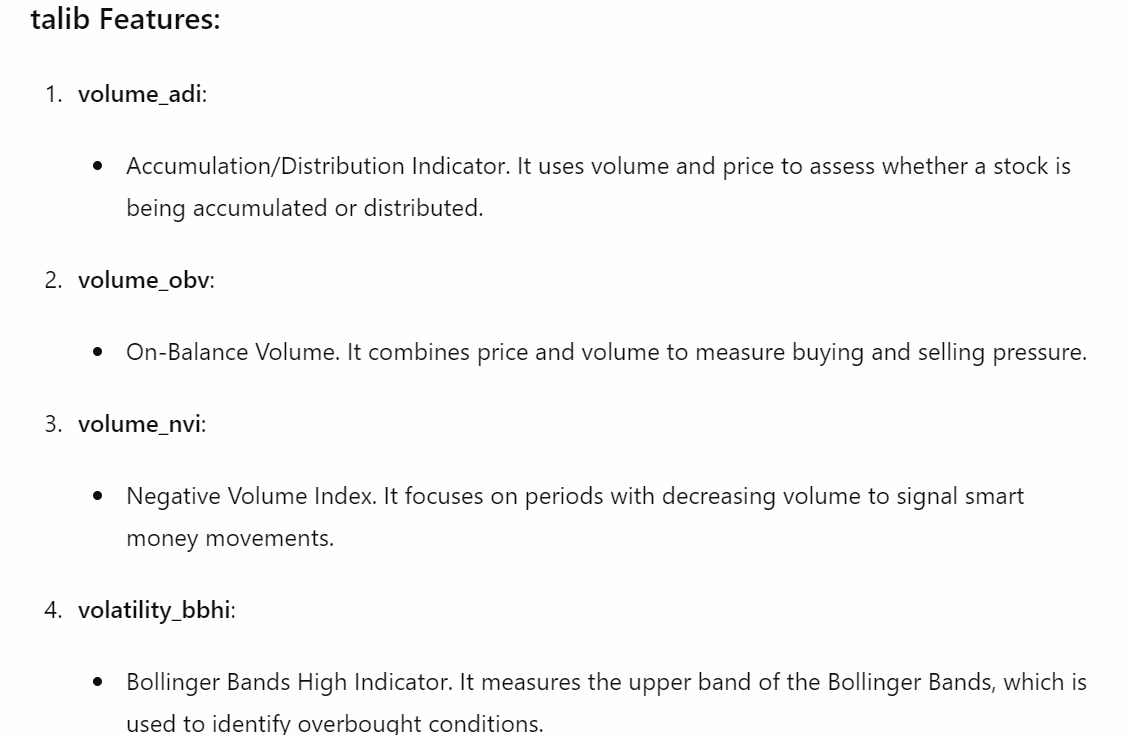
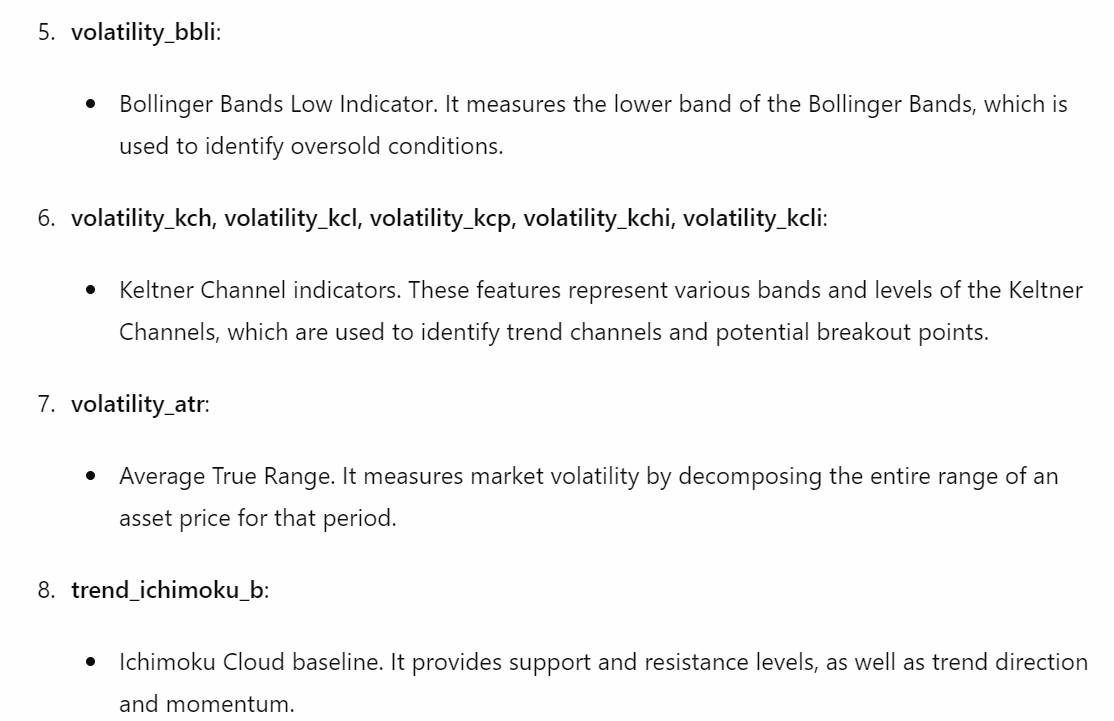
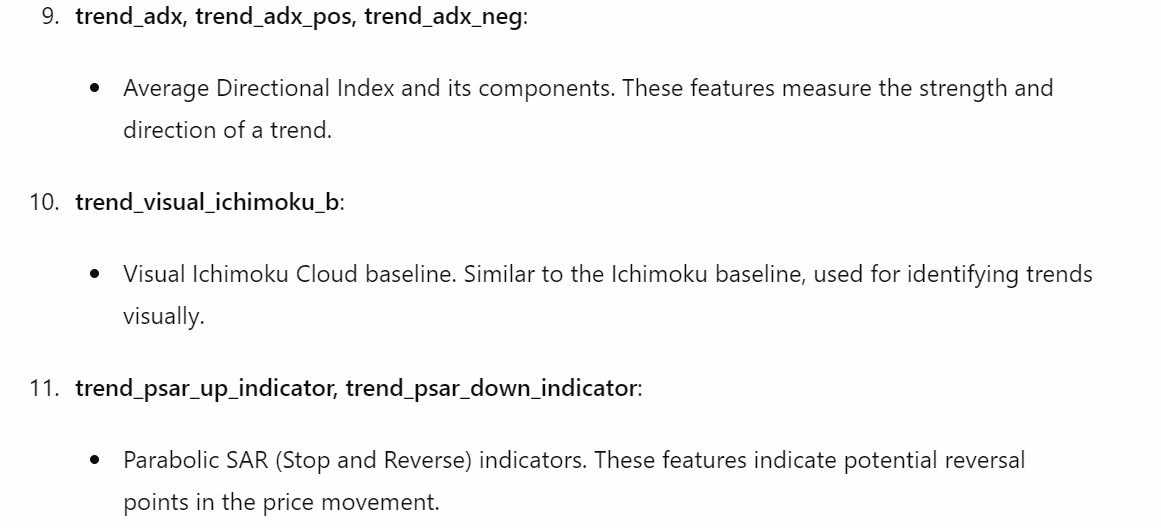

In [149]:
custom_fc_parameters = {
    'cwt_coefficients': [{'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)}],
    'cwt_coefficients': [{'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)}],
    'quantile': [{'q': 0.9}, {'q': 0.8}, {'q': 0.7}, {'q': 0.6}, {'q': 0.4}, {'q': 0.3}, {'q': 0.2}, {'q': 0.1}],
    'fft_coefficient': [{'attr': 'real', 'coeff': 0}, {'attr': 'abs', 'coeff': 0}],
    'root_mean_square': None,
    'abs_energy': None,
    'benford_correlation': None
}

def calc_final_features(i):
    ticker = candle_data['Ticker'].unique()[i]
    df = candle_data[candle_data['Ticker'] == ticker]
    
    df_prepared = df[['Date', 'Open','High','Low','Close','Volume']].copy()
    
    # Add volume indicators
    df_prepared['volume_adi'] = ta.volume.acc_dist_index(df_prepared['High'], df_prepared['Low'], df_prepared['Close'], df_prepared['Volume'])
    df_prepared['volume_obv'] = ta.volume.on_balance_volume(df_prepared['Close'], df_prepared['Volume'])
    df_prepared['volume_nvi'] = ta.volume.negative_volume_index(df_prepared['Close'], df_prepared['Volume'])

    # Add volatility indicators
    df_prepared['volatility_bbhi'] = ta.volatility.bollinger_hband_indicator(df_prepared['Close'])
    df_prepared['volatility_bbli'] = ta.volatility.bollinger_lband_indicator(df_prepared['Close'])
    df_prepared['volatility_kch'] = ta.volatility.keltner_channel_hband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['volatility_kcl'] = ta.volatility.keltner_channel_lband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['volatility_kcp'] = ta.volatility.keltner_channel_pband(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['volatility_kchi'] = ta.volatility.keltner_channel_hband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['volatility_kcli'] = ta.volatility.keltner_channel_lband_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['volatility_atr'] = ta.volatility.average_true_range(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])

    # Add trend indicators
    df_prepared['trend_ichimoku_b'] = ta.trend.ichimoku_base_line(df_prepared['High'], df_prepared['Low'])
    df_prepared['trend_adx'] = ta.trend.adx(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['trend_adx_pos'] = ta.trend.adx_pos(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['trend_adx_neg'] = ta.trend.adx_neg(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['trend_visual_ichimoku_b'] = ta.trend.ichimoku_base_line(df_prepared['High'], df_prepared['Low'])  # Same as trend_ichimoku_b
    df_prepared['trend_psar_up_indicator'] = ta.trend.psar_up_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_prepared['trend_psar_down_indicator'] = ta.trend.psar_down_indicator(df_prepared['High'], df_prepared['Low'], df_prepared['Close'])
    df_talib = df_prepared.copy()
    
    df_prepared = df[['Date', 'Close']].copy()
    df_prepared['id'] = range(len(df_prepared))

    # Assuming df_forecasting is your DataFrame and already prepared
    features = extract_features(
        df_prepared,
        column_id='id',
        column_sort='Date',
        default_fc_parameters=custom_fc_parameters,
        show_warnings=False,
        n_jobs=1
    )
    features = features[:-1]
    features['Date'] = df['Date'].iloc[1:].values
    columns = ['Date'] + [col for col in features.columns if col != 'Date']
    features = features[columns]
    df_tsfresh = features.copy()
    
    final_features = pd.merge(df_talib, df_tsfresh, on='Date')
    return final_features

In [150]:
# candle_data = pd.read_excel('combine_data.xlsx')

final_features_dict = defaultdict()

for i in range(len(candle_data['Ticker'].unique())):
    final_features = calc_final_features(i)
    final_features_dict[i] = final_features
    
    print('i = ', i)
    
    with open('final_features_dict.pkl', 'wb') as f:
        pickle.dump(final_features_dict, f)
        
    print('saved')
    print()

Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 545.45it/s]


i =  0
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 541.92it/s]


i =  1
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 569.74it/s]


i =  2
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 489.39it/s]


i =  3
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 562.44it/s]


i =  4
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 570.88it/s]


i =  5
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 601.41it/s]


i =  6
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.14it/s]


i =  7
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.01it/s]


i =  8
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 616.43it/s]


i =  9
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 608.06it/s]


i =  10
saved



Feature Extraction: 100%|██████████| 874/874 [00:01<00:00, 572.36it/s]


i =  11
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 628.23it/s]


i =  12
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.25it/s]


i =  13
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 606.29it/s]


i =  14
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.52it/s]


i =  15
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.54it/s]


i =  16
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.16it/s]


i =  17
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.24it/s]


i =  18
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 600.43it/s]


i =  19
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.80it/s]


i =  20
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 610.71it/s]


i =  21
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.19it/s]


i =  22
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.13it/s]


i =  23
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.61it/s]


i =  24
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.95it/s]


i =  25
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.31it/s]


i =  26
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.43it/s]


i =  27
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 559.31it/s]


i =  28
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.18it/s]


i =  29
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.84it/s]


i =  30
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 558.53it/s]


i =  31
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.83it/s]


i =  32
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.56it/s]


i =  33
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.44it/s]


i =  34
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.10it/s]


i =  35
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.04it/s]


i =  36
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.98it/s]


i =  37
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.77it/s]


i =  38
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.01it/s]


i =  39
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.17it/s]


i =  40
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.04it/s]


i =  41
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.06it/s]


i =  42
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 551.85it/s]


i =  43
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.89it/s]


i =  44
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.44it/s]


i =  45
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.60it/s]


i =  46
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.93it/s]


i =  47
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.63it/s]


i =  48
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 553.32it/s]


i =  49
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 564.15it/s]


i =  50
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.25it/s]


i =  51
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.55it/s]


i =  52
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.14it/s]


i =  53
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.92it/s]


i =  54
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.17it/s]


i =  55
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.05it/s]


i =  56
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.41it/s]


i =  57
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.37it/s]


i =  58
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.92it/s]


i =  59
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.56it/s]


i =  60
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 570.56it/s]


i =  61
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.09it/s]


i =  62
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.93it/s]


i =  63
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.34it/s]


i =  64
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 508.53it/s]


i =  65
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.71it/s]


i =  66
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.93it/s]


i =  67
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.25it/s]


i =  68
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.11it/s]


i =  69
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.45it/s]


i =  70
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.33it/s]


i =  71
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.26it/s]


i =  72
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.67it/s]


i =  73
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 611.29it/s]


i =  74
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.04it/s]


i =  75
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.06it/s]


i =  76
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.72it/s]


i =  77
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.41it/s]


i =  78
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.60it/s]


i =  79
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 609.52it/s]


i =  80
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.33it/s]


i =  81
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.89it/s]


i =  82
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.48it/s]


i =  83
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.54it/s]


i =  84
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 567.11it/s]


i =  85
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.47it/s]


i =  86
saved



Feature Extraction: 100%|██████████| 1059/1059 [00:01<00:00, 590.01it/s]


i =  87
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.84it/s]


i =  88
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.30it/s]


i =  89
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.75it/s]


i =  90
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 558.62it/s]


i =  91
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.01it/s]


i =  92
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.02it/s]


i =  93
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.32it/s]


i =  94
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.35it/s]


i =  95
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.00it/s]


i =  96
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.02it/s]


i =  97
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.75it/s]


i =  98
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.41it/s]


i =  99
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.20it/s]


i =  100
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.90it/s]


i =  101
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.03it/s]


i =  102
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 565.14it/s]


i =  103
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.73it/s]


i =  104
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.77it/s]


i =  105
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.22it/s]


i =  106
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.55it/s]


i =  107
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.50it/s]


i =  108
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.96it/s]


i =  109
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.82it/s]


i =  110
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.95it/s]


i =  111
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.55it/s]


i =  112
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.77it/s]


i =  113
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.46it/s]


i =  114
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 572.01it/s]


i =  115
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 611.08it/s]


i =  116
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 602.25it/s]


i =  117
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.04it/s]


i =  118
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.30it/s]


i =  119
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.11it/s]


i =  120
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 572.57it/s]


i =  121
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.26it/s]


i =  122
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 508.60it/s]


i =  123
saved



Feature Extraction: 100%|██████████| 596/596 [00:01<00:00, 590.40it/s]


i =  124
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.30it/s]


i =  125
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.14it/s]


i =  126
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.37it/s]


i =  127
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.68it/s]


i =  128
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.71it/s]


i =  129
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.82it/s]


i =  130
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 554.55it/s]


i =  131
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.84it/s]


i =  132
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.13it/s]


i =  133
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.19it/s]


i =  134
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.99it/s]


i =  135
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.74it/s]


i =  136
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.73it/s]


i =  137
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.81it/s]


i =  138
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.15it/s]


i =  139
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.87it/s]


i =  140
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.62it/s]


i =  141
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.16it/s]


i =  142
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.05it/s]


i =  143
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.64it/s]


i =  144
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 543.84it/s]


i =  145
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.50it/s]


i =  146
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.26it/s]


i =  147
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.85it/s]


i =  148
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.57it/s]


i =  149
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.75it/s]


i =  150
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.65it/s]


i =  151
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.86it/s]


i =  152
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.45it/s]


i =  153
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.78it/s]


i =  154
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.58it/s]


i =  155
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 572.13it/s]


i =  156
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 565.58it/s]


i =  157
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.88it/s]


i =  158
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.25it/s]


i =  159
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.05it/s]


i =  160
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.37it/s]


i =  161
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.59it/s]


i =  162
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.34it/s]


i =  163
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 601.39it/s]


i =  164
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.26it/s]


i =  165
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.26it/s]


i =  166
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.41it/s]


i =  167
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.65it/s]


i =  168
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.07it/s]


i =  169
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 572.60it/s]


i =  170
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.12it/s]


i =  171
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.41it/s]


i =  172
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.16it/s]


i =  173
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.06it/s]


i =  174
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.89it/s]


i =  175
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.70it/s]


i =  176
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.90it/s]


i =  177
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.57it/s]


i =  178
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.00it/s]


i =  179
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.01it/s]


i =  180
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 511.87it/s]


i =  181
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.03it/s]


i =  182
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.57it/s]


i =  183
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.55it/s]


i =  184
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.14it/s]


i =  185
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.73it/s]


i =  186
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.42it/s]


i =  187
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.80it/s]


i =  188
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.33it/s]


i =  189
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.44it/s]


i =  190
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.73it/s]


i =  191
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.62it/s]


i =  192
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.74it/s]


i =  193
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.79it/s]


i =  194
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.29it/s]


i =  195
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 600.75it/s]


i =  196
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.61it/s]


i =  197
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.10it/s]


i =  198
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.15it/s]


i =  199
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.07it/s]


i =  200
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.69it/s]


i =  201
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.65it/s]


i =  202
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.44it/s]


i =  203
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.77it/s]


i =  204
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.02it/s]


i =  205
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.52it/s]


i =  206
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.45it/s]


i =  207
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.47it/s]


i =  208
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.02it/s]


i =  209
saved



Feature Extraction: 100%|██████████| 367/367 [00:00<00:00, 591.45it/s]


i =  210
saved



Feature Extraction: 100%|██████████| 45/45 [00:00<00:00, 610.37it/s]


i =  211
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.99it/s]


i =  212
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.47it/s]


i =  213
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 600.92it/s]


i =  214
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.06it/s]


i =  215
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.93it/s]


i =  216
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.90it/s]


i =  217
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 557.99it/s]


i =  218
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.71it/s]


i =  219
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.38it/s]


i =  220
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.44it/s]


i =  221
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 601.06it/s]


i =  222
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.19it/s]


i =  223
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.68it/s]


i =  224
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 601.16it/s]


i =  225
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.42it/s]


i =  226
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.91it/s]


i =  227
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.23it/s]


i =  228
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.42it/s]


i =  229
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.17it/s]


i =  230
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.18it/s]


i =  231
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 509.45it/s]


i =  232
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.77it/s]


i =  233
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.72it/s]


i =  234
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.50it/s]


i =  235
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.75it/s]


i =  236
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.85it/s]


i =  237
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 607.13it/s]


i =  238
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.05it/s]


i =  239
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.51it/s]


i =  240
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.21it/s]


i =  241
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.59it/s]


i =  242
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.06it/s]


i =  243
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.84it/s]


i =  244
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 600.68it/s]


i =  245
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.58it/s]


i =  246
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.04it/s]


i =  247
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.31it/s]


i =  248
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.88it/s]


i =  249
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.80it/s]


i =  250
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.53it/s]


i =  251
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.14it/s]


i =  252
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 561.95it/s]


i =  253
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.60it/s]


i =  254
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.51it/s]


i =  255
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.39it/s]


i =  256
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 602.41it/s]


i =  257
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.63it/s]


i =  258
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.29it/s]


i =  259
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.59it/s]


i =  260
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.20it/s]


i =  261
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.42it/s]


i =  262
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.12it/s]


i =  263
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.41it/s]


i =  264
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 558.16it/s]


i =  265
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.74it/s]


i =  266
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 606.43it/s]


i =  267
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.61it/s]


i =  268
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 607.15it/s]


i =  269
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.73it/s]


i =  270
saved



Feature Extraction: 100%|██████████| 272/272 [00:00<00:00, 574.44it/s]


i =  271
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.07it/s]


i =  272
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.98it/s]


i =  273
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.55it/s]


i =  274
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.30it/s]


i =  275
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.04it/s]


i =  276
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 562.64it/s]


i =  277
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.62it/s]


i =  278
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.82it/s]


i =  279
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.66it/s]


i =  280
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.01it/s]


i =  281
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.80it/s]


i =  282
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 560.79it/s]


i =  283
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.47it/s]


i =  284
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.66it/s]


i =  285
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 511.44it/s]


i =  286
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.33it/s]


i =  287
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.96it/s]


i =  288
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.98it/s]


i =  289
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.04it/s]


i =  290
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.60it/s]


i =  291
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.20it/s]


i =  292
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.67it/s]


i =  293
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.82it/s]


i =  294
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.59it/s]


i =  295
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.48it/s]


i =  296
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.76it/s]


i =  297
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.80it/s]


i =  298
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.92it/s]


i =  299
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.40it/s]


i =  300
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.73it/s]


i =  301
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.90it/s]


i =  302
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.19it/s]


i =  303
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.61it/s]


i =  304
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.08it/s]


i =  305
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 556.43it/s]


i =  306
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.32it/s]


i =  307
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.99it/s]


i =  308
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.06it/s]


i =  309
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.78it/s]


i =  310
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.25it/s]


i =  311
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 562.86it/s]


i =  312
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.25it/s]


i =  313
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.12it/s]


i =  314
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.35it/s]


i =  315
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.57it/s]


i =  316
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.22it/s]


i =  317
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.27it/s]


i =  318
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.00it/s]


i =  319
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 471.13it/s]


i =  320
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 565.27it/s]


i =  321
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.58it/s]


i =  322
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.66it/s]


i =  323
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.50it/s]


i =  324
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.07it/s]


i =  325
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.73it/s]


i =  326
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.98it/s]


i =  327
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.59it/s]


i =  328
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.35it/s]


i =  329
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.46it/s]


i =  330
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.36it/s]


i =  331
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.80it/s]


i =  332
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.12it/s]


i =  333
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.99it/s]


i =  334
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.13it/s]


i =  335
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.87it/s]


i =  336
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.85it/s]


i =  337
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 600.34it/s]


i =  338
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.45it/s]


i =  339
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.25it/s]


i =  340
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 566.23it/s]


i =  341
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.69it/s]


i =  342
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.06it/s]


i =  343
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.51it/s]


i =  344
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.87it/s]


i =  345
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.03it/s]


i =  346
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.22it/s]


i =  347
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.16it/s]


i =  348
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.56it/s]


i =  349
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.87it/s]


i =  350
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 563.20it/s]


i =  351
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.20it/s]


i =  352
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 606.84it/s]


i =  353
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.07it/s]


i =  354
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.74it/s]


i =  355
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.92it/s]


i =  356
saved



Feature Extraction: 100%|██████████| 1059/1059 [00:01<00:00, 586.70it/s]


i =  357
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 563.36it/s]


i =  358
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.76it/s]


i =  359
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.27it/s]


i =  360
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.37it/s]


i =  361
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.34it/s]


i =  362
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.88it/s]


i =  363
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.95it/s]


i =  364
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.87it/s]


i =  365
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.61it/s]


i =  366
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.76it/s]


i =  367
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.31it/s]


i =  368
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.45it/s]


i =  369
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 577.43it/s]


i =  370
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.98it/s]


i =  371
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.00it/s]


i =  372
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.95it/s]


i =  373
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.98it/s]


i =  374
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 566.55it/s]


i =  375
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.96it/s]


i =  376
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.18it/s]


i =  377
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.69it/s]


i =  378
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 567.50it/s]


i =  379
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 611.16it/s]


i =  380
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.01it/s]


i =  381
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.96it/s]


i =  382
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.83it/s]


i =  383
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.44it/s]


i =  384
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.70it/s]


i =  385
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.05it/s]


i =  386
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.78it/s]


i =  387
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.26it/s]


i =  388
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.27it/s]


i =  389
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.89it/s]


i =  390
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 599.32it/s]


i =  391
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.40it/s]


i =  392
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.92it/s]


i =  393
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.29it/s]


i =  394
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.43it/s]


i =  395
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.88it/s]


i =  396
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.62it/s]


i =  397
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 570.47it/s]


i =  398
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.40it/s]


i =  399
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.42it/s]


i =  400
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.38it/s]


i =  401
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.74it/s]


i =  402
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.65it/s]


i =  403
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 563.11it/s]


i =  404
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 503.23it/s]


i =  405
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.85it/s]


i =  406
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 564.53it/s]


i =  407
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.15it/s]


i =  408
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 596.48it/s]


i =  409
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 565.97it/s]


i =  410
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.27it/s]


i =  411
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 544.76it/s]


i =  412
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.98it/s]


i =  413
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.93it/s]


i =  414
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.63it/s]


i =  415
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.60it/s]


i =  416
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.03it/s]


i =  417
saved



Feature Extraction: 100%|██████████| 45/45 [00:00<00:00, 579.23it/s]

i =  418


saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.57it/s]


i =  419
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 616.36it/s]


i =  420
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.66it/s]


i =  421
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.48it/s]


i =  422
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.88it/s]


i =  423
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.45it/s]


i =  424
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.35it/s]


i =  425
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 560.43it/s]


i =  426
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.14it/s]


i =  427
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.32it/s]


i =  428
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.18it/s]


i =  429
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 569.73it/s]


i =  430
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.82it/s]


i =  431
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.88it/s]


i =  432
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 564.27it/s]


i =  433
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.34it/s]


i =  434
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 555.67it/s]


i =  435
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.50it/s]


i =  436
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 505.03it/s]


i =  437
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.73it/s]


i =  438
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.92it/s]


i =  439
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.78it/s]


i =  440
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 582.25it/s]


i =  441
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 590.83it/s]


i =  442
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.71it/s]


i =  443
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.23it/s]


i =  444
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 591.82it/s]


i =  445
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.84it/s]


i =  446
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 586.83it/s]


i =  447
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 579.02it/s]


i =  448
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.02it/s]


i =  449
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 574.89it/s]


i =  450
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.18it/s]


i =  451
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 594.52it/s]


i =  452
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.15it/s]


i =  453
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 585.02it/s]


i =  454
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.13it/s]


i =  455
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 576.09it/s]


i =  456
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.11it/s]


i =  457
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.38it/s]


i =  458
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 588.89it/s]


i =  459
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.51it/s]


i =  460
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 543.45it/s]


i =  461
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.07it/s]


i =  462
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.06it/s]


i =  463
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 597.95it/s]


i =  464
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.44it/s]


i =  465
saved



Feature Extraction: 100%|██████████| 167/167 [00:00<00:00, 568.70it/s]


i =  466
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.35it/s]


i =  467
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 562.27it/s]


i =  468
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 527.95it/s]


i =  469
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 603.78it/s]


i =  470
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.99it/s]


i =  471
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.00it/s]


i =  472
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 559.37it/s]


i =  473
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.35it/s]


i =  474
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.34it/s]


i =  475
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.37it/s]


i =  476
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.42it/s]


i =  477
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 573.29it/s]


i =  478
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 571.79it/s]


i =  479
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 563.70it/s]


i =  480
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.24it/s]


i =  481
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 580.76it/s]


i =  482
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.10it/s]


i =  483
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 587.05it/s]


i =  484
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 595.61it/s]


i =  485
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 593.97it/s]


i =  486
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 583.86it/s]


i =  487
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.98it/s]


i =  488
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 578.25it/s]


i =  489
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 560.14it/s]


i =  490
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 575.59it/s]


i =  491
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 598.63it/s]


i =  492
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 581.85it/s]


i =  493
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 584.25it/s]


i =  494
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 572.50it/s]


i =  495
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 568.40it/s]


i =  496
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.61it/s]


i =  497
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 589.59it/s]


i =  498
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 592.58it/s]


i =  499
saved



Feature Extraction: 100%|██████████| 1257/1257 [00:02<00:00, 605.47it/s]


i =  500
saved



In [141]:
final_features_dict.keys()

dict_keys([0, 1])

In [142]:
final_features_dict[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_nvi', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kch', 'volatility_kcl', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_atr', 'trend_ichimoku_b', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_visual_ichimoku_b',
       'trend_psar_up_indicator', 'trend_psar_down_indicator',
       'Close__sum_values',
       'Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'Close__quantile__q_0.9', 'Close__quantile__q_0.8',
       'Close__quantile__q_0.7', 'Close__quantile__q_0.6',
       'Close__quantile__q_0.4', 'Close__quantile__q_0.3',
       'Close__quantile__q_0.2', 'Close__quantile__q_0.1',
       'Close__fft_coefficient__attr_"real"__coeff_0',
       'Close__fft_coefficient__attr_"abs"__coeff_0', 'Close__minimum',
       'Close__absolute_maximum', 'Close__maximum', 'Close__root_mean_square',
       'Close__mean', 'Clos

In [144]:
final_features_dict[1]['Close__fft_coefficient__attr_"abs"__coeff_0']

0       43.240002
1       43.830002
2       44.380001
3       44.590000
4       44.919998
          ...    
1251    84.779999
1252    82.540001
1253    81.110001
1254    82.059998
1255    83.639999
Name: Close__fft_coefficient__attr_"abs"__coeff_0, Length: 1256, dtype: float64

In [145]:
final_features_dict[0]['Close__fft_coefficient__attr_"abs"__coeff_0']

0       137.725754
1       139.306015
2       140.710709
3       141.229095
4       141.312714
           ...    
1251     99.669998
1252     98.680000
1253     97.559998
1254     98.199997
1255    100.139999
Name: Close__fft_coefficient__attr_"abs"__coeff_0, Length: 1256, dtype: float64

In [151]:
import pandas as pd
df = pd.read_pickle('final_features_dict.pkl')

In [153]:
df.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [154]:
df[0]

,Date,Open,High,Low,Close,Volume,volume_adi,volume_obv,volume_nvi,volatility_bbhi,...,Close__quantile__q_0.6,Close__quantile__q_0.4,Close__quantile__q_0.3,Close__quantile__q_0.2,Close__quantile__q_0.1,"Close__fft_coefficient__attr_""real""__coeff_0","Close__fft_coefficient__attr_""abs""__coeff_0",Close__root_mean_square,Close__abs_energy,Close__benford_correlation
0,2019-06-07,138.428101,139.707352,137.658859,139.306015,2413169,2.161397e+06,6697002,1011.473970,0.0,...,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,137.725754,18968.383260,0.864123
1,2019-06-10,140.560196,142.324417,140.359528,140.710709,2700090,4.264708e+05,9397092,1011.473970,0.0,...,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,139.306015,19406.165815,0.864123
2,2019-06-11,142.065216,142.441467,140.886291,141.229095,2663731,-1.062939e+06,12060823,1015.200303,0.0,...,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,140.710709,19799.503515,0.864123
3,2019-06-12,142.031769,142.265884,140.961533,141.312714,2591014,-2.258755e+06,14651837,1015.801376,0.0,...,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,141.229095,19945.657416,0.864123
4,2019-06-13,141.605347,142.056854,140.359528,141.178925,2561234,-2.347079e+06,12090603,1014.839658,0.0,...,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,141.312714,19969.283025,0.864123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2024-05-28,99.559998,100.110001,97.820000,98.680000,4360900,-5.821975e+07,-217813861,1280.743718,0.0,...,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,99.669998,9934.108535,-0.297356
1252,2024-05-29,97.800003,97.900002,96.760002,97.559998,4826600,-5.627221e+07,-222640461,1280.743718,0.0,...,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,98.680000,9737.742461,-0.297356
1253,2024-05-30,97.690002,98.230003,96.889999,98.199997,4520300,-5.195436e+07,-218120161,1289.145473,0.0,...,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,97.559998,9517.953124,-0.297356
1254,2024-05-31,98.059998,100.250000,97.419998,100.139999,21754400,-3.189112e+07,-196365761,1289.145473,0.0,...,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,98.199997,9643.239401,-0.297356


In [155]:
df[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_nvi', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kch', 'volatility_kcl', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_atr', 'trend_ichimoku_b', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_visual_ichimoku_b',
       'trend_psar_up_indicator', 'trend_psar_down_indicator',
       'Close__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)',
       'Close__quantile__q_0.9', 'Close__quantile__q_0.8',
       'Close__quantile__q_0.7', 'Close__quantile__q_0.6',
       'Close__quantile__q_0.4', 'Close__quantile__q_0.3',
       'Close__quantile__q_0.2', 'Close__quantile__q_0.1',
       'Close__fft_coefficient__attr_"real"__coeff_0',
       'Close__fft_coefficient__attr_"abs"__coeff_0',
       'Close__root_mean_square', 'Close__abs_energy',
       'Close__benford_correlation'],
      dtype='object')

In [156]:
len(df[0].columns)

38